# **Problem Statement**

## Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description

The data provided is a transformed version of the original data which was collected using sensors.

- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.

Both the datasets consist of 40 predictor variables and 1 target variable.

#  - **Checkpoint 1:**

## **Critical Thinking:**

- Before we delve deeper into the project there are 2 very imoprtant observations we must call out:
  - **1: Cost Structure of Model Outcomes :**There are different costs associated to 3 different consequences:
    - **Replacement** - Assuming cost is ~ 1,000 USD
      - Will be represented by False Negative (**Recall**)  because it misses on detecting a failure, leading to replacement
    - **Repair** - Assuming cost is ~ 500 USD
      - Will be represented by True Positives (**Accuracy**) because it will call for a repair in time to avoid replacement
    - **Inspection** - Assuming cost is ~ 200 USD
      - Will be represented by False Positives (**Precision**) because it alarms a failure when there isn't any issues
  - **2: Cost-Aware Learning Strategy:** We will implement class weighting to prioritize failures (1) in model training. By increasing the weight of class 1, the model will focus more on detecting actual failures (maximizing Recall), which directly reduces the costliest outcome: replacement due to missed failures

- Consider going to **Multi-Class** for future data: Consider training with inspect, repair, replace as the dependent variable to assign a threshold with level of urgency, in order to prioritize different potential failures instead of 1/0.

## **Installing and Importing the necessary libraries**

In [2]:
# Installing the libraries with the specified version
!pip install --no-deps tensorflow==2.18.0 scikit-learn==1.3.2 matplotlib===3.8.3 seaborn==0.13.2 numpy==1.26.4 pandas==2.2.2 -q --user --no-warn-script-location

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.0 MB/s eta 0:00:00


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Splitting, preprocessing, and imputation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score,
                             recall_score, precision_score, classification_report,
                             ConfusionMatrixDisplay)

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Utilities
import warnings
warnings.filterwarnings("ignore")
import time
import random

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

## **Loading the Data**

In [5]:
dtrain = pd.read_csv('/content/Train.csv')
dtest = pd.read_csv('/content/Test.csv')

# **Data Overview**

### **Training Data**

In [6]:
dtrain.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 41 columns]

In [10]:
dtrain.tail()

V1         V2        V3        V4        V5        V6        V7  \
19995 -2.071318  -1.088279 -0.796174 -3.011720 -2.287540  2.807310  0.481428   
19996  2.890264   2.483069  5.643919  0.937053 -1.380870  0.412051 -1.593386   
19997 -3.896979  -3.942407 -0.351364 -2.417462  1.107546 -1.527623 -3.519882   
19998 -3.187322 -10.051662  5.695955 -4.370053 -5.354758 -1.873044 -3.947210   
19999 -2.686903   1.961187  6.137088  2.600133  2.657241 -4.290882 -2.344267   

             V8        V9       V10  ...       V32       V33       V34  \
19995  0.105171 -0.586599 -2.899398  ... -8.273996  5.745013  0.589014   
19996 -5.762498  2.150096  0.272302  ... -4.159092  1.181466 -0.742412   
19997  2.054792 -0.233996 -0.357687  ...  7.112162  1.476080 -3.953710   
19998  0.679420 -2.389254  5.456756  ...  0.402812  3.163661  3.752095   
19999  0.974004 -1.027462  0.497421  ...  6.620811 -1.988786 -1.348901   

            V35       V36       V37       V38       V39       V40  Target  
19995 -0.649988 -3.043174  2.216461  0.608723  0.178193  2.927755       1  
19996  5.368979 -0.693028 -1.668971  3.659954  0.819863 -1.987265       0  
19997  1.855555  5.029209  2.082588 -6.409304  1.477138 -0.874148       0  
19998  8.529894  8.450626  0.203958 -7.129918  4.249394 -6.112267       0  
19999  3.951801  5.449706 -0.455411 -2.202056  1.678229 -1.974413       0  

[5 rows x 41 columns]

In [12]:
dtrain.shape

(20000, 41)

In [14]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [18]:
dtrain.describe().T

count      mean       std        min       25%       50%       75%  \
V1      19982.0 -0.271996  3.441625 -11.876451 -2.737146 -0.747917  1.840112   
V2      19982.0  0.440430  3.150784 -12.319951 -1.640674  0.471536  2.543967   
V3      20000.0  2.484699  3.388963 -10.708139  0.206860  2.255786  4.566165   
V4      20000.0 -0.083152  3.431595 -15.082052 -2.347660 -0.135241  2.130615   
V5      20000.0 -0.053752  2.104801  -8.603361 -1.535607 -0.101952  1.340480   
V6      20000.0 -0.995443  2.040970 -10.227147 -2.347238 -1.000515  0.380330   
V7      20000.0 -0.879325  1.761626  -7.949681 -2.030926 -0.917179  0.223695   
V8      20000.0 -0.548195  3.295756 -15.657561 -2.642665 -0.389085  1.722965   
V9      20000.0 -0.016808  2.160568  -8.596313 -1.494973 -0.067597  1.409203   
V10     20000.0 -0.012998  2.193201  -9.853957 -1.411212  0.100973  1.477045   
V11     20000.0 -1.895393  3.124322 -14.832058 -3.922404 -1.921237  0.118906   
V12     20000.0  1.604825  2.930454 -12.948007 -0.396514  1.507841  3.571454   
V13     20000.0  1.580486  2.874658 -13.228247 -0.223545  1.637185  3.459886   
V14     20000.0 -0.950632  1.789651  -7.738593 -2.170741 -0.957163  0.270677   
V15     20000.0 -2.414993  3.354974 -16.416606 -4.415322 -2.382617 -0.359052   
V16     20000.0 -2.925225  4.221717 -20.374158 -5.634240 -2.682705 -0.095046   
V17     20000.0 -0.134261  3.345462 -14.091184 -2.215611 -0.014580  2.068751   
V18     20000.0  1.189347  2.592276 -11.643994 -0.403917  0.883398  2.571770   
V19     20000.0  1.181808  3.396925 -13.491784 -1.050168  1.279061  3.493299   
V20     20000.0  0.023608  3.669477 -13.922659 -2.432953  0.033415  2.512372   
V21     20000.0 -3.611252  3.567690 -17.956231 -5.930360 -3.532888 -1.265884   
V22     20000.0  0.951835  1.651547 -10.122095 -0.118127  0.974687  2.025594   
V23     20000.0 -0.366116  4.031860 -14.866128 -3.098756 -0.262093  2.451750   
V24     20000.0  1.134389  3.912069 -16.387147 -1.468062  0.969048  3.545975   
V25     20000.0 -0.002186  2.016740  -8.228266 -1.365178  0.025050  1.397112   
V26     20000.0  1.873785  3.435137 -11.834271 -0.337863  1.950531  4.130037   
V27     20000.0 -0.612413  4.368847 -14.904939 -3.652323 -0.884894  2.189177   
V28     20000.0 -0.883218  1.917713  -9.269489 -2.171218 -0.891073  0.375884   
V29     20000.0 -0.985625  2.684365 -12.579469 -2.787443 -1.176181  0.629773   
V30     20000.0 -0.015534  3.005258 -14.796047 -1.867114  0.184346  2.036229   
V31     20000.0  0.486842  3.461384 -13.722760 -1.817772  0.490304  2.730688   
V32     20000.0  0.303799  5.500400 -19.876502 -3.420469  0.052073  3.761722   
V33     20000.0  0.049825  3.575285 -16.898353 -2.242857 -0.066249  2.255134   
V34     20000.0 -0.462702  3.183841 -17.985094 -2.136984 -0.255008  1.436935   
V35     20000.0  2.229620  2.937102 -15.349803  0.336191  2.098633  4.064358   
V36     20000.0  1.514809  3.800860 -14.833178 -0.943809  1.566526  3.983939   
V37     20000.0  0.011316  1.788165  -5.478350 -1.255819 -0.128435  1.175533   
V38     20000.0 -0.344025  3.948147 -17.375002 -2.987638 -0.316849  2.279399   
V39     20000.0  0.890653  1.753054  -6.438880 -0.272250  0.919261  2.057540   
V40     20000.0 -0.875630  3.012155 -11.023935 -2.940193 -0.920806  1.119897   
Target  20000.0  0.055500  0.228959   0.000000  0.000000  0.000000  0.000000   

              max  
V1      15.493002  
V2      13.089269  
V3      17.090919  
V4      13.236381  
V5       8.133797  
V6       6.975847  
V7       8.006091  
V8      11.679495  
V9       8.137580  
V10      8.108472  
V11     11.826433  
V12     15.080698  
V13     15.419616  
V14      5.670664  
V15     12.246455  
V16     13.583212  
V17     16.756432  
V18     13.179863  
V19     13.237742  
V20     16.052339  
V21     13.840473  
V22      7.409856  
V23     14.458734  
V24     17.163291  
V25      8.223389  
V26     16.836410  
V27     17.560404  
V28      6.527643  
V29     10.722055  
V30     12.505812  
V31     17.255090  
V32     2

In [19]:
dtrain.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [28]:
#Target value count
dtrain['Target'].value_counts(1)

Target
0    0.9445
1    0.0555
Name: proportion, dtype: float64

### **Conclusion of Training** Data set:

- Data Seriously **imbalanced** with:
  - *94% = 0* (no failure)
  - 6% = 1 (failure)
    - We need to add a lot more weights to 1 (failure) if we want to prioritize avoiding replacement
- There are very little **missing values**
  - Data will inputed with *mean* and copy will be saved and used to proceed with EDA and Training/Testing
    - Column V1=18 missing
    - Column V2=18 missing
- Data is transformed and features are hidden, thus very little exploration on data values can be made
- Rows = 20,000
- Columns = 41

In [29]:
dtrain1 = dtrain.copy()

In [31]:
dtrain1.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [32]:
numeric_cols = dtrain1.select_dtypes(include=['float64', 'int64']).columns


In [33]:
dtrain1[numeric_cols] = dtrain1[numeric_cols].fillna(dtrain1[numeric_cols].mean())

In [34]:
dtrain1.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [36]:
## Saving the copy to use for future
dtrain1.to_csv('dtrain1.csv', index=False)

In [46]:
dtrain1 = pd.read_csv('/content/dtrain1.csv')

### **Test Data**

In [7]:
dtest.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   

         V8        V9       V10  ...       V32       V33       V34       V35  \
0  4.722989  1.206140 -0.341909  ...  2.291204 -5.411388  0.870073  0.574479   
1 -4.405744 -0.332869  1.966794  ... -2.474936  2.493582  0.315165  2.059288   
2  1.347309 -1.732348  0.466500  ... -1.318888 -2.997464  0.459664  0.619774   
3  0.269493  1.322436  0.702345  ...  3.517918 -3.074085 -0.284220  0.954576   
4  0.965043  1.918379 -2.774855  ...  1.773841 -1.501573 -2.226702  4.776830   

        V36       V37        V38       V39       V40  Target  
0  4.157191  1.428093 -10.511342  0.454664 -1.448363       0  
1  0.683859 -0.485452   5.128350  1.720744 -1.488235       0  
2  5.631504  1.323512  -1.752154  1.808302  1.675748       0  
3  3.029331 -1.367198  -3.412140  0.906000 -2.450889       0  
4 -6.559698 -0.805551  -0.276007 -3.858207 -0.537694       0  

[5 rows x 41 columns]

In [11]:
dtest.tail()

V1        V2        V3        V4        V5        V6        V7  \
4995 -5.120451  1.634804  1.251259  4.035944  3.291204 -2.932230 -1.328662   
4996 -5.172498  1.171653  1.579105  1.219922  2.529627 -0.668648 -2.618321   
4997 -1.114136 -0.403576 -1.764875 -5.879475  3.571558  3.710802 -2.482952   
4998 -1.703241  0.614650  6.220503 -0.104132  0.955916 -3.278706 -1.633855   
4999 -0.603701  0.959550 -0.720995  8.229574 -1.815610 -2.275547 -2.574524   

            V8        V9       V10  ...       V32       V33        V34  \
4995  1.754066 -2.984586  1.248633  ...  9.979118  0.063438   0.217281   
4996 -2.000545  0.633791 -0.578938  ...  4.423900  2.603811  -2.152170   
4997 -0.307614 -0.921945 -2.999141  ...  3.791778  7.481506 -10.061396   
4998 -0.103936  1.388152 -1.065622  ... -4.100352 -5.949325   0.550372   
4999 -1.041479  4.129645 -2.731288  ...  2.369776 -1.062408   0.790772   

           V35       V36       V37       V38       V39       V40  Target  
4995  3.036388  2.109323 -0.557433  1.938718  0.512674 -2.694194       0  
4996  0.917401  2.156586  0.466963  0.470120  2.196756 -2.376515       0  
4997 -0.387166  1.848509  1.818248 -1.245633 -1.260876  7.474682       0  
4998 -1.573640  6.823936  2.139307 -4.036164  3.436051  0.579249       0  
4999  4.951955 -7.440825 -0.069506 -0.918083 -2.291154 -5.362891       0  

[5 rows x 41 columns]

In [13]:
dtest.shape

(5000, 41)

In [16]:
dtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [20]:
dtest.describe().T

count      mean       std        min       25%       50%       75%  \
V1      4995.0 -0.277622  3.466280 -12.381696 -2.743691 -0.764767  1.831313   
V2      4994.0  0.397928  3.139562 -10.716179 -1.649211  0.427369  2.444486   
V3      5000.0  2.551787  3.326607  -9.237940  0.314931  2.260428  4.587000   
V4      5000.0 -0.048943  3.413937 -14.682446 -2.292694 -0.145753  2.166468   
V5      5000.0 -0.080120  2.110870  -7.711569 -1.615238 -0.131890  1.341197   
V6      5000.0 -1.042138  2.005444  -8.924196 -2.368853 -1.048571  0.307555   
V7      5000.0 -0.907922  1.769017  -8.124230 -2.054259 -0.939695  0.212228   
V8      5000.0 -0.574592  3.331911 -12.252731 -2.642088 -0.357943  1.712896   
V9      5000.0  0.030121  2.174139  -6.785495 -1.455712 -0.079891  1.449548   
V10     5000.0  0.018524  2.145437  -8.170956 -1.353320  0.166292  1.511248   
V11     5000.0 -2.008615  3.112220 -13.151753 -4.050432 -2.043122  0.044069   
V12     5000.0  1.576413  2.907401  -8.164048 -0.449674  1.488253  3.562626   
V13     5000.0  1.622456  2.882892 -11.548209 -0.126012  1.718649  3.464604   
V14     5000.0 -0.921097  1.803470  -7.813929 -2.110952 -0.896011  0.272324   
V15     5000.0 -2.452174  3.387041 -15.285768 -4.479072 -2.417131 -0.432943   
V16     5000.0 -3.018503  4.264407 -20.985779 -5.648343 -2.773763 -0.178105   
V17     5000.0 -0.103721  3.336513 -13.418281 -2.227683  0.047462  2.111907   
V18     5000.0  1.195606  2.586403 -12.214016 -0.408850  0.881395  2.604014   
V19     5000.0  1.210490  3.384662 -14.169635 -1.026394  1.295864  3.526278   
V20     5000.0  0.138429  3.657171 -13.719620 -2.325454  0.193386  2.539550   
V21     5000.0 -3.664398  3.577841 -16.340707 -5.944369 -3.662870 -1.329645   
V22     5000.0  0.961960  1.640414  -6.740239 -0.047728  0.986020  2.029321   
V23     5000.0 -0.422182  4.056714 -14.422274 -3.162690 -0.279222  2.425911   
V24     5000.0  1.088841  3.968207 -12.315545 -1.623203  0.912815  3.537195   
V25     5000.0  0.061235  2.010227  -6.770139 -1.298377  0.076703  1.428491   
V26     5000.0  1.847261  3.400330 -11.414019 -0.242470  1.917032  4.156106   
V27     5000.0 -0.552397  4.402947 -13.177038 -3.662591 -0.871982  2.247257   
V28     5000.0 -0.867678  1.926181  -7.933388 -2.159811 -0.930695  0.420587   
V29     5000.0 -1.095805  2.655454  -9.987800 -2.861373 -1.340547  0.521843   
V30     5000.0 -0.118699  3.023292 -12.438434 -1.996743  0.112463  1.946450   
V31     5000.0  0.468810  3.446324 -11.263271 -1.822421  0.485742  2.779008   
V32     5000.0  0.232567  5.585628 -17.244168 -3.556267 -0.076694  3.751857   
V33     5000.0 -0.080115  3.538624 -14.903781 -2.348121 -0.159713  2.099160   
V34     5000.0 -0.392663  3.166101 -14.699725 -2.009604 -0.171745  1.465402   
V35     5000.0  2.211205  2.948426 -12.260591  0.321818  2.111750  4.031639   
V36     5000.0  1.594845  3.774970 -12.735567 -0.866066  1.702964  4.104409   
V37     5000.0  0.022931  1.785320  -5.079070 -1.240526 -0.110415  1.237522   
V38     5000.0 -0.405659  3.968936 -15.334533 -2.984480 -0.381162  2.287998   
V39     5000.0  0.938800  1.716502  -5.451050 -0.208024  0.959152  2.130769   
V40     5000.0 -0.932406  2.978193 -10.076234 -2.986587 -1.002764  1.079738   
Target  5000.0  0.056400  0.230716   0.000000  0.000000  0.000000  0.000000   

              max  
V1      13.504352  
V2      14.079073  
V3      15.314503  
V4      12.140157  
V5       7.672835  
V6       5.067685  
V7       7.616182  
V8      10.414722  
V9       8.850720  
V10      6.598728  
V11      9.956400  
V12     12.983644  
V13     12.620041  
V14      5.734112  
V15     11.673420  
V16     13.975843  
V17     19.776592  
V18     13.642235  
V19     12.427997  
V20     13.870565  
V21     11.046925  
V22      7.505291  
V23     13.180887  
V24     17.806035  
V25      6.556937  
V26     17.528193  
V27     17.290161  
V28      7.415659  
V29     14.039466  
V30     10.314976  
V31     12.558928  
V32     26.539391  
V33     13.323517  
V34     12

In [21]:
dtest.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [39]:
## Target values
dtest['Target'].value_counts(1)

Target
0    0.9436
1    0.0564
Name: proportion, dtype: float64

### **Conclusion of Test** Data:

- Data Seriously **imbalanced** with:
  - *94% = 0* (no failure)
  - 6% = 1 (failure)
    - We need to add a lot more weights to 1 (failure) if we want to prioritize avoiding replacement
- There are very little **missing values**
  - Data will inputed with *mean* and copy will be saved and used to proceed with EDA and Training/Testing
    - Column V1=5 missing
    - Column V2=6 missing
- Data is transformed and features are hidden, thus very little exploration on data values can be made
- Rows = 5,000
- Columns = 41

In [40]:
dtest1 = dtest.copy()

In [42]:
dtest1.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [43]:
numeric_cols = dtest1.select_dtypes(include=['float64', 'int64']).columns


In [45]:
dtest1[numeric_cols] = dtest1[numeric_cols].fillna(dtest1[numeric_cols].mean())

In [47]:
dtest1.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [48]:
## Saving the copy to use for future
dtest1.to_csv('dtest1.csv', index=False)

In [49]:
dtest1 = pd.read_csv('/content/dtest1.csv')

# **Exploratory Data Analysis**

# - **Checkpoint 2:**



## Univariate analysis

In [3]:
dtrain = pd.read_csv('/content/dtrain1.csv')
dtest = pd.read_csv('/content/dtest1.csv')

In [4]:
def comparative_histograms(dtrain, dtest, features, batch_size=4):
    for i in range(0, len(features), batch_size):
        batch_features = features[i:i + batch_size]
        fig, axes = plt.subplots(nrows=2, ncols=len(batch_features), figsize=(5 * len(batch_features), 8))

        for j, col in enumerate(batch_features):
            sns.histplot(dtrain[col], kde=True, ax=axes[0, j], color='steelblue')
            axes[0, j].set_title(f"Train - {col}")
            sns.histplot(dtest[col], kde=True, ax=axes[1, j], color='orange')
            axes[1, j].set_title(f"Test - {col}")

        plt.tight_layout()
        plt.show()

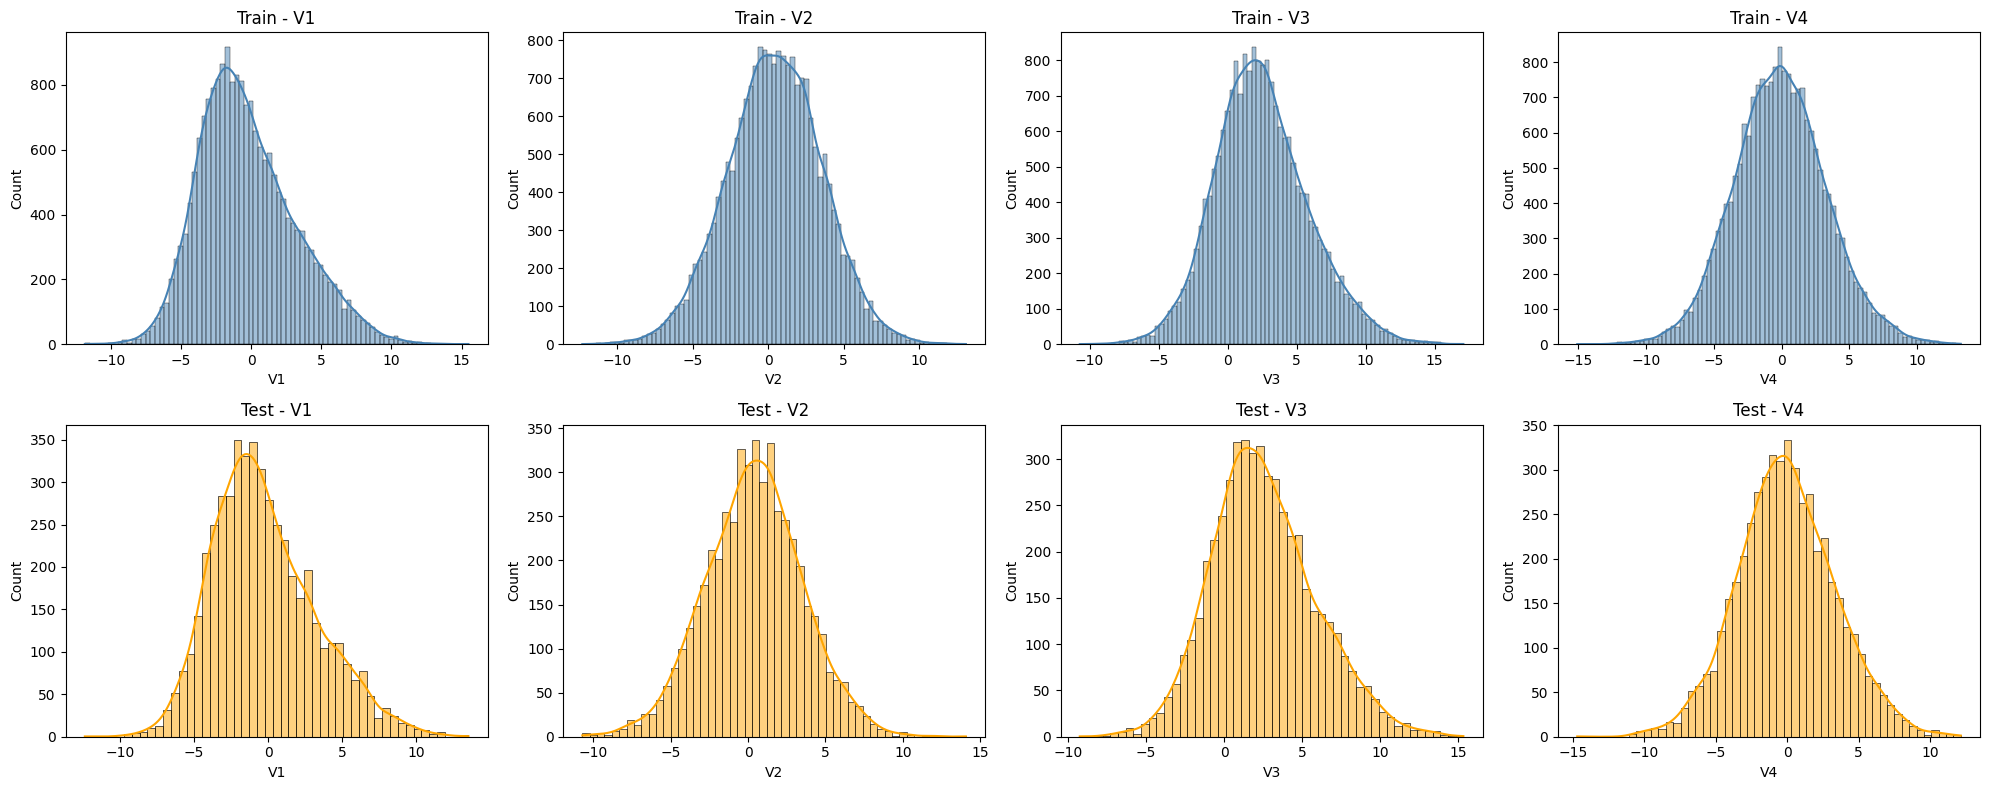

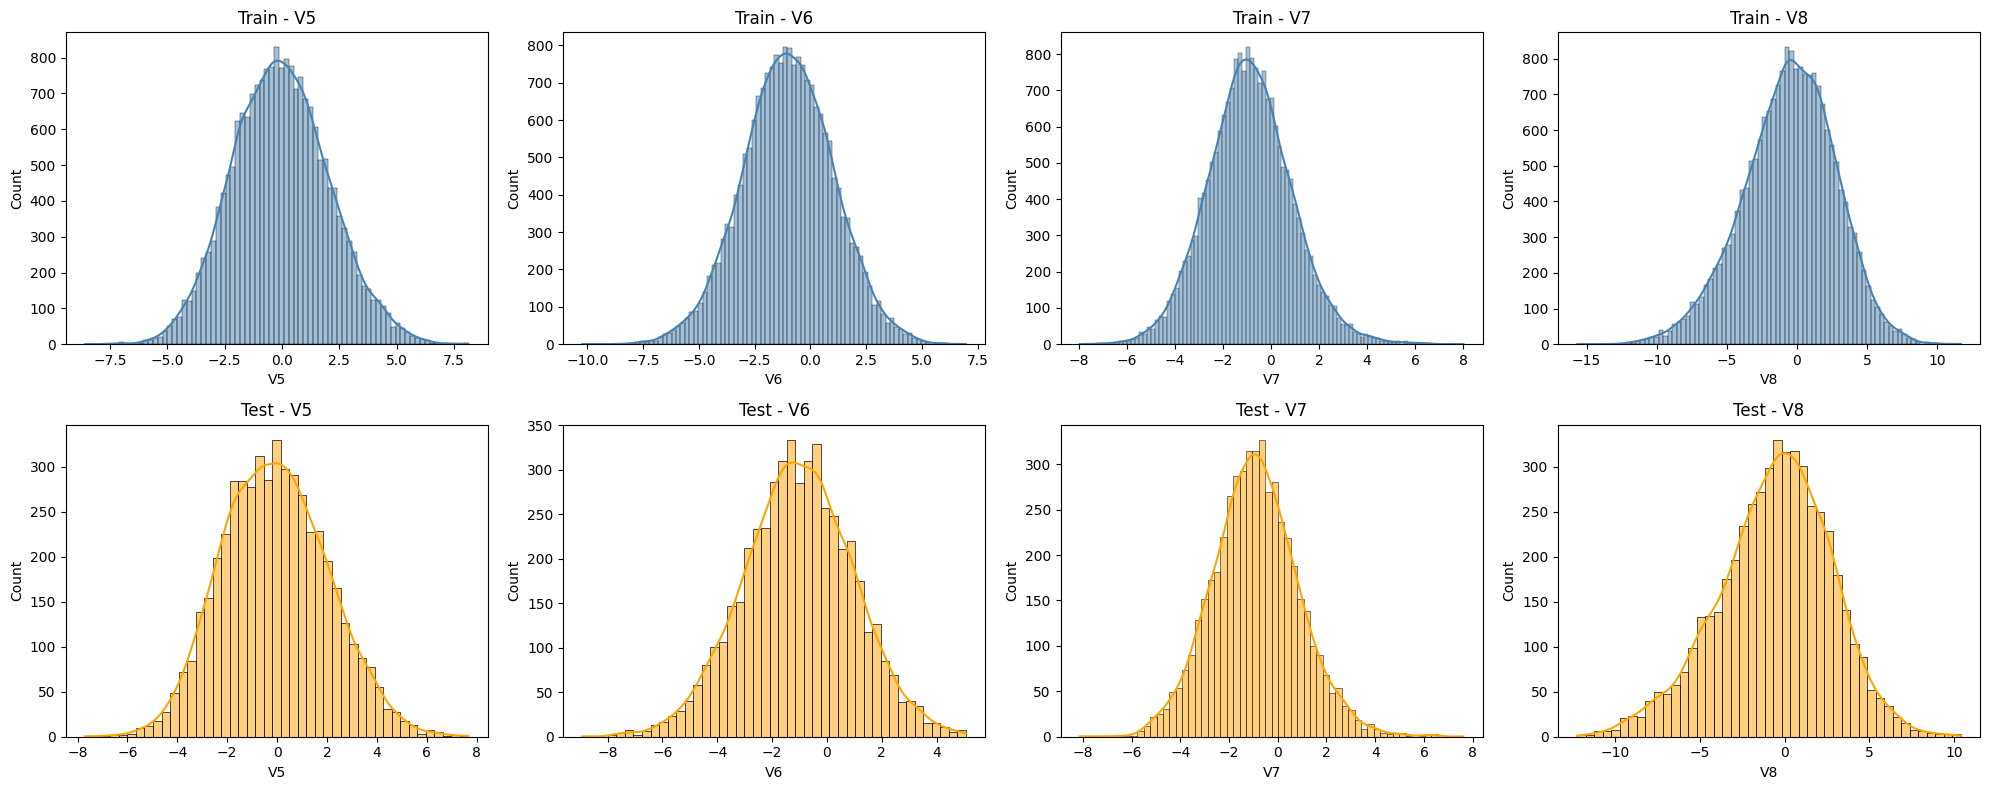

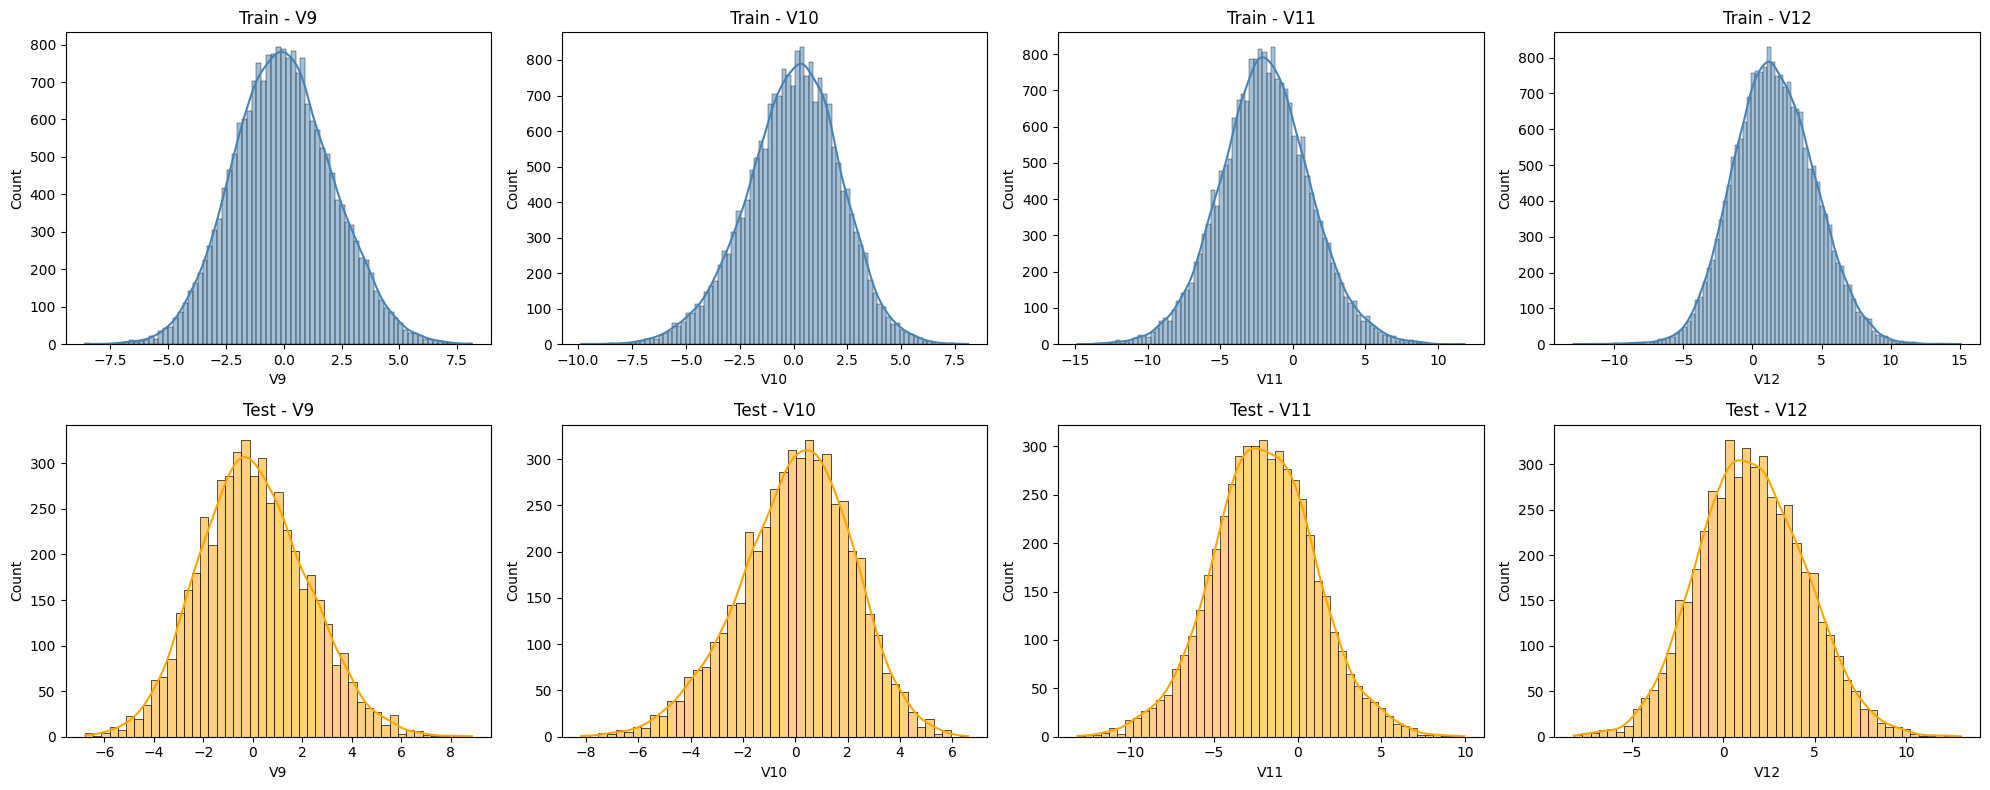

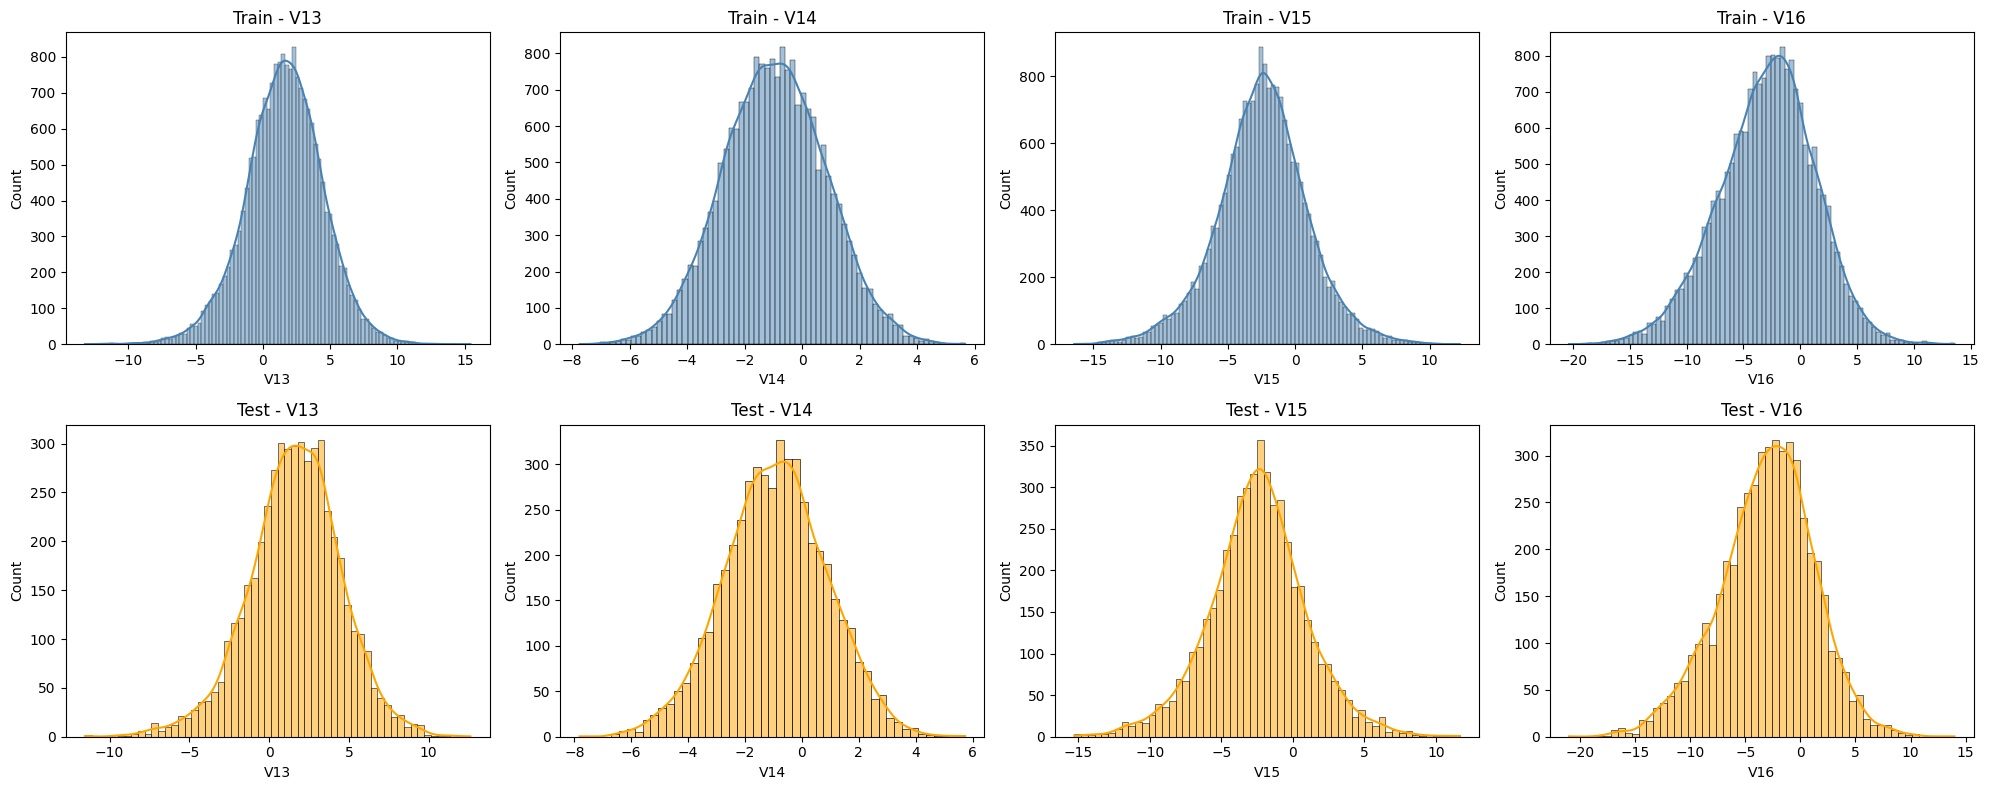

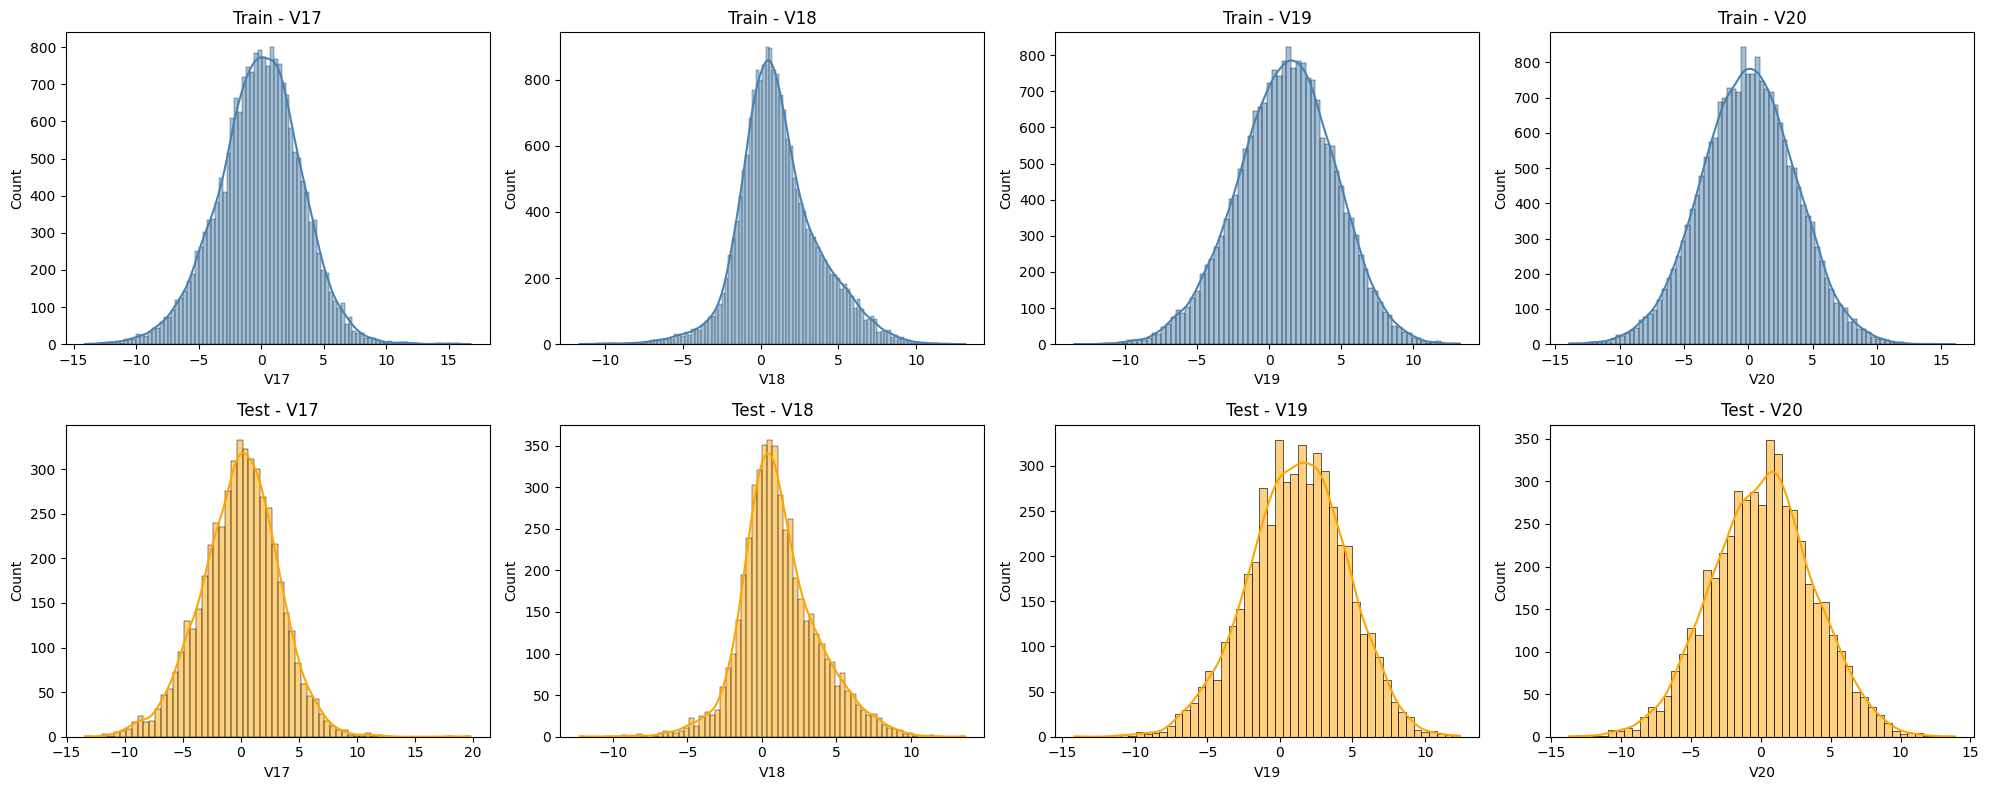

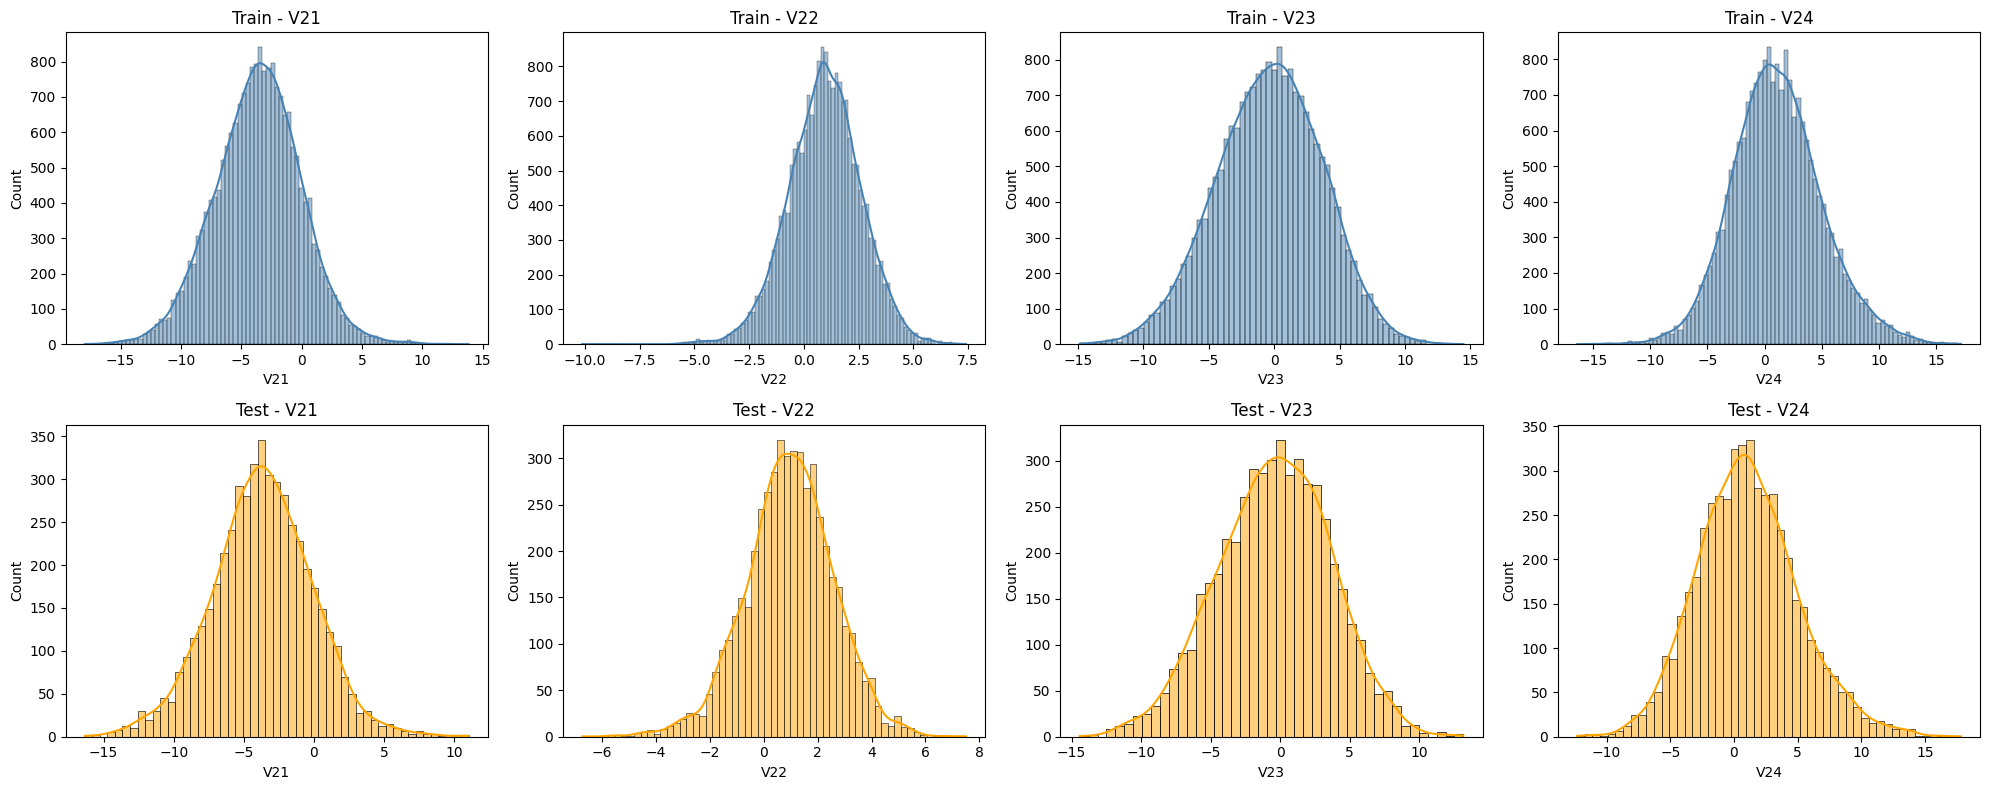

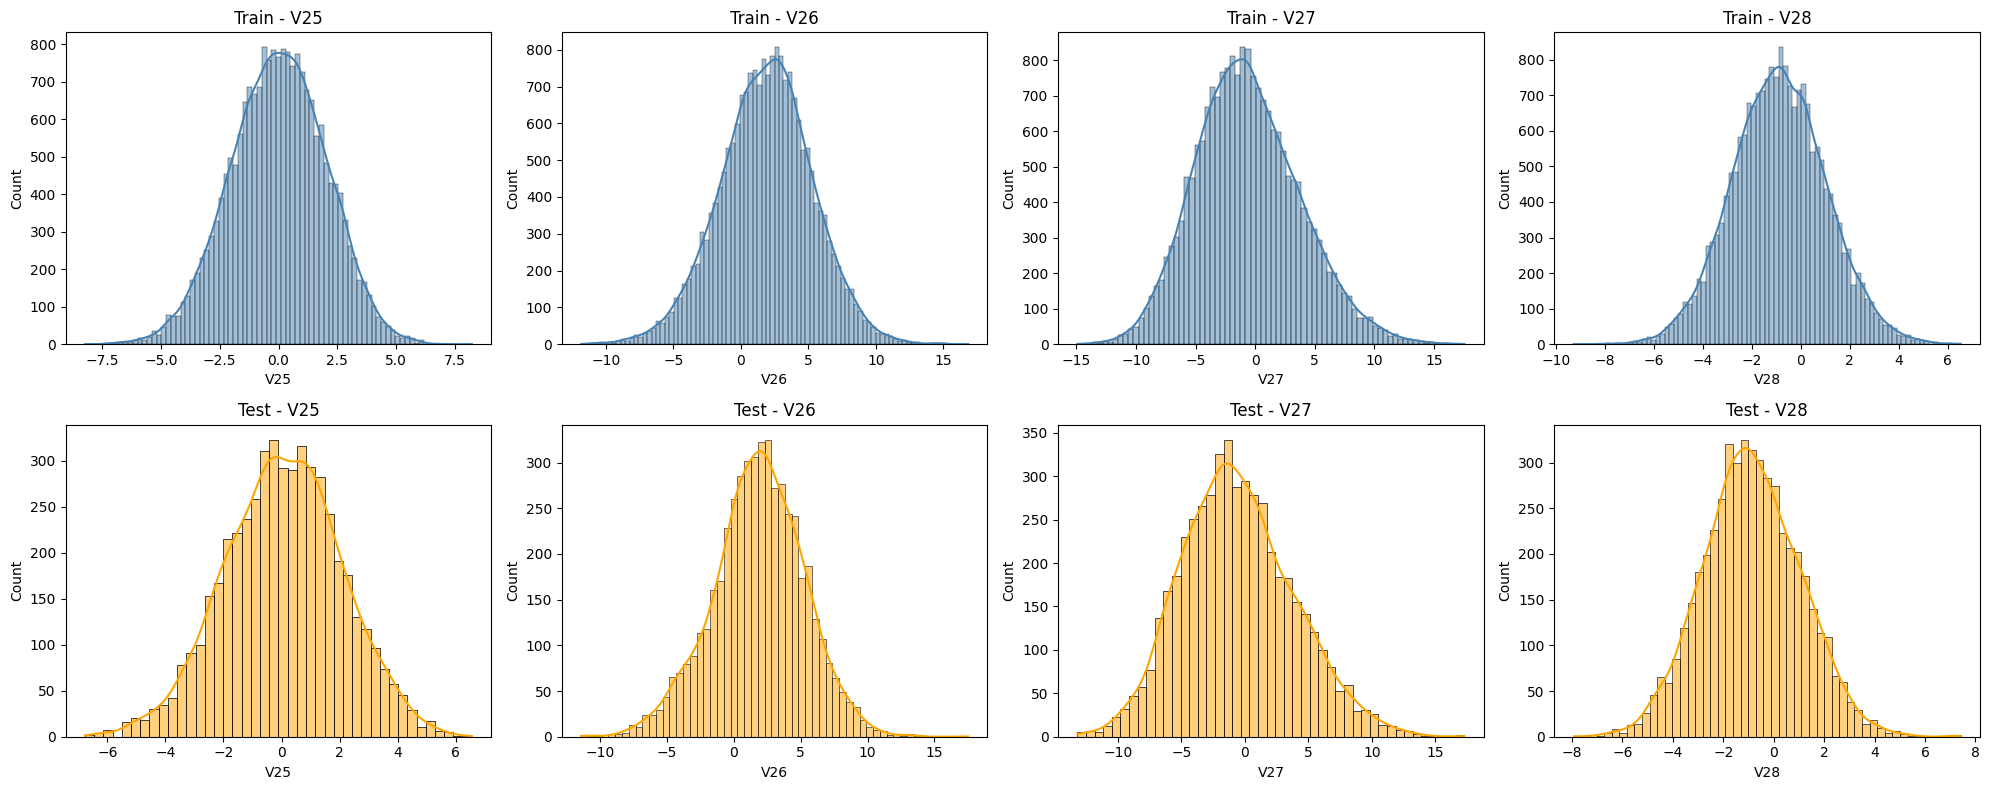

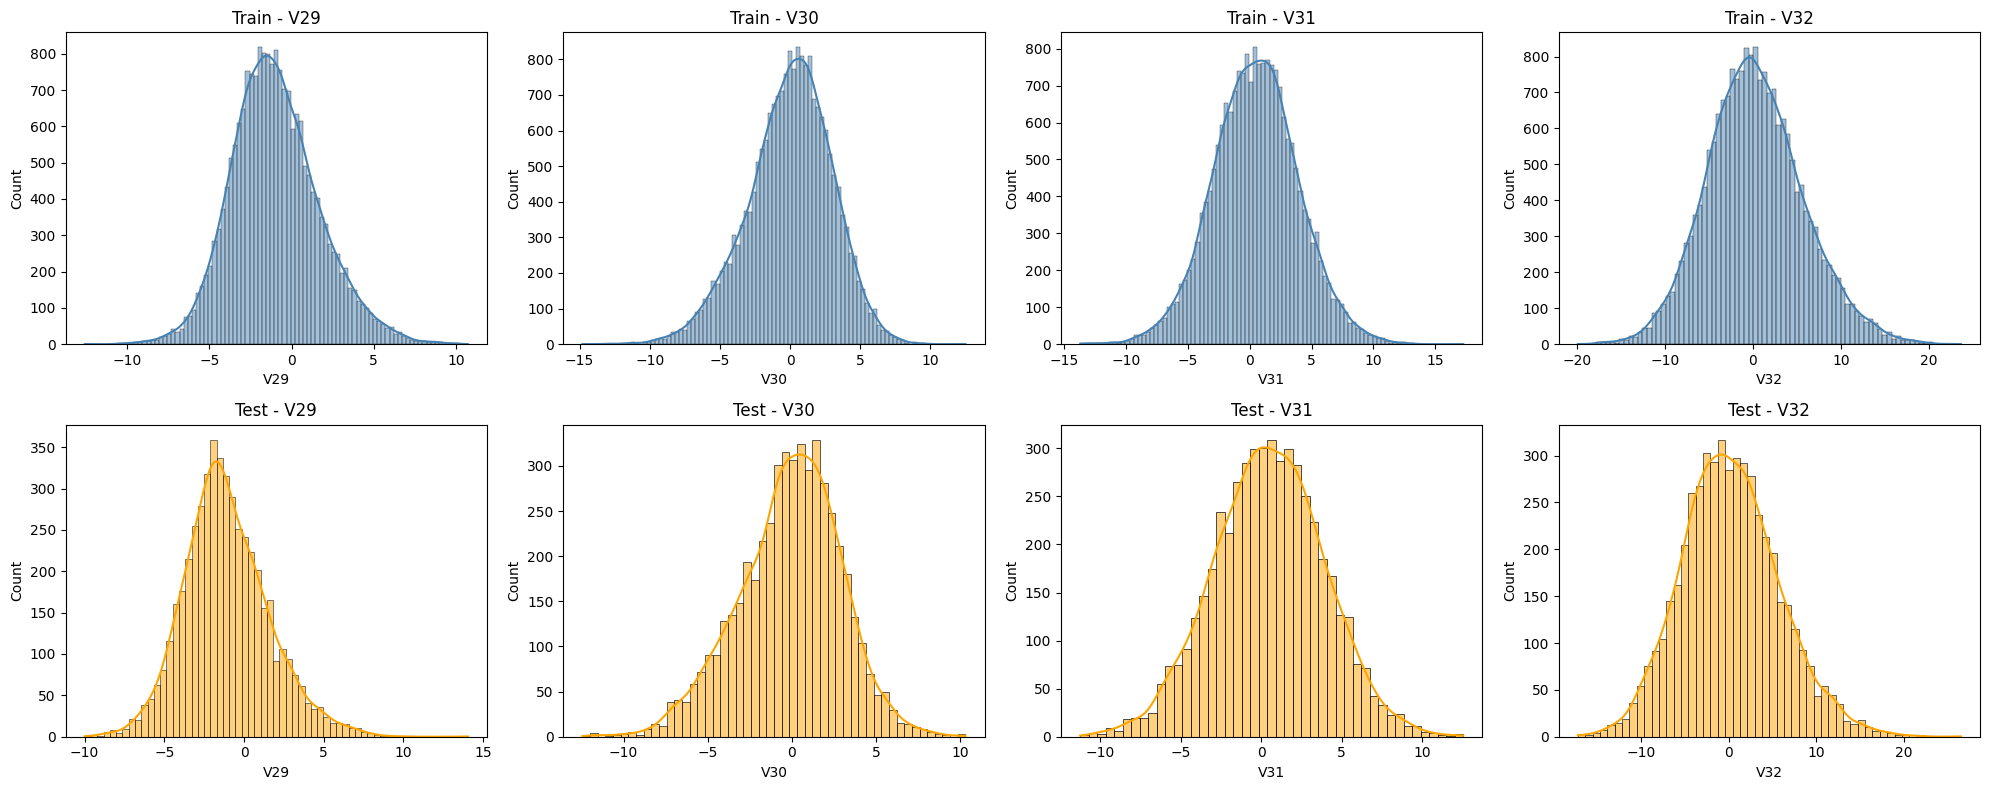

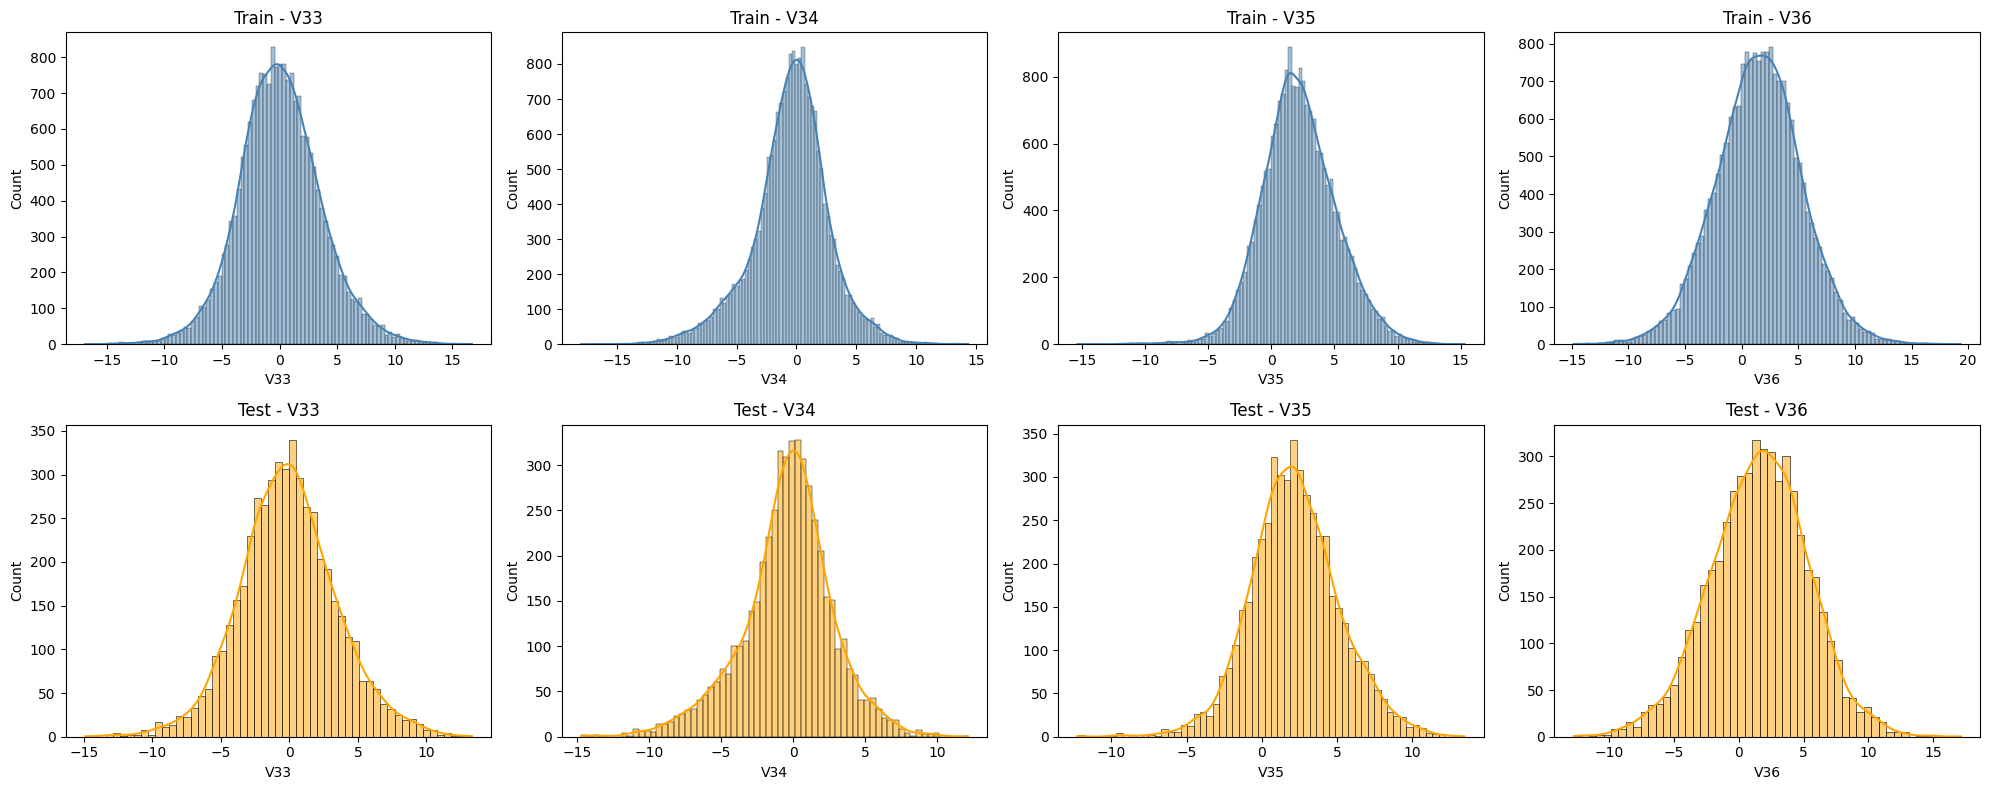

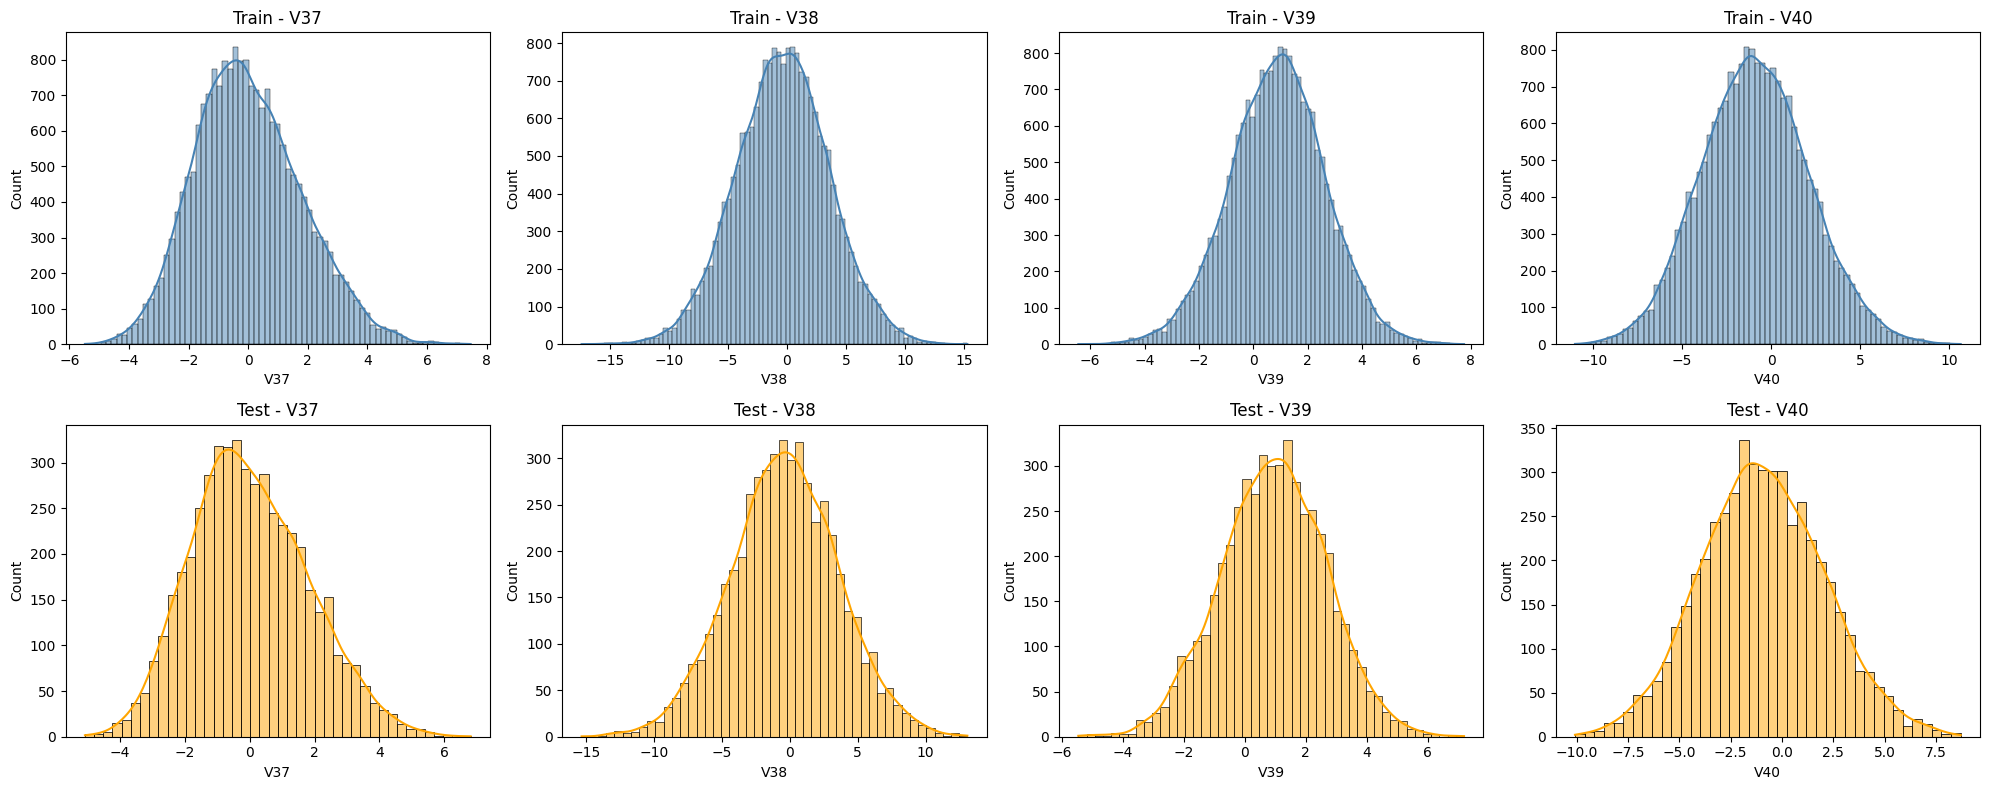

In [5]:
shared_columns = dtrain.columns.intersection(dtest.columns)
comparative_histograms(dtrain, dtest, shared_columns[:-1])

In [9]:
def combined_boxplot_comparison(dtrain, dtest, features, batch_size=4):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i + batch_size]

        # Create labeled copies
        dtrain_temp = dtrain[batch_features].copy()
        dtrain_temp['Dataset'] = 'Train'
        dtest_temp = dtest[batch_features].copy()
        dtest_temp['Dataset'] = 'Test'

        # Combine
        combined_df = pd.concat([dtrain_temp, dtest_temp], axis=0)

        # Melt for Seaborn
        melted_df = pd.melt(combined_df, id_vars='Dataset', value_vars=batch_features,
                            var_name='Feature', value_name='Value')

        # Plot
        plt.figure(figsize=(5 * batch_size, 6))
        sns.boxplot(data=melted_df, x='Feature', y='Value', hue='Dataset')
        plt.title("Side-by-side Boxplot Comparison")
        plt.tight_layout()
        plt.show()

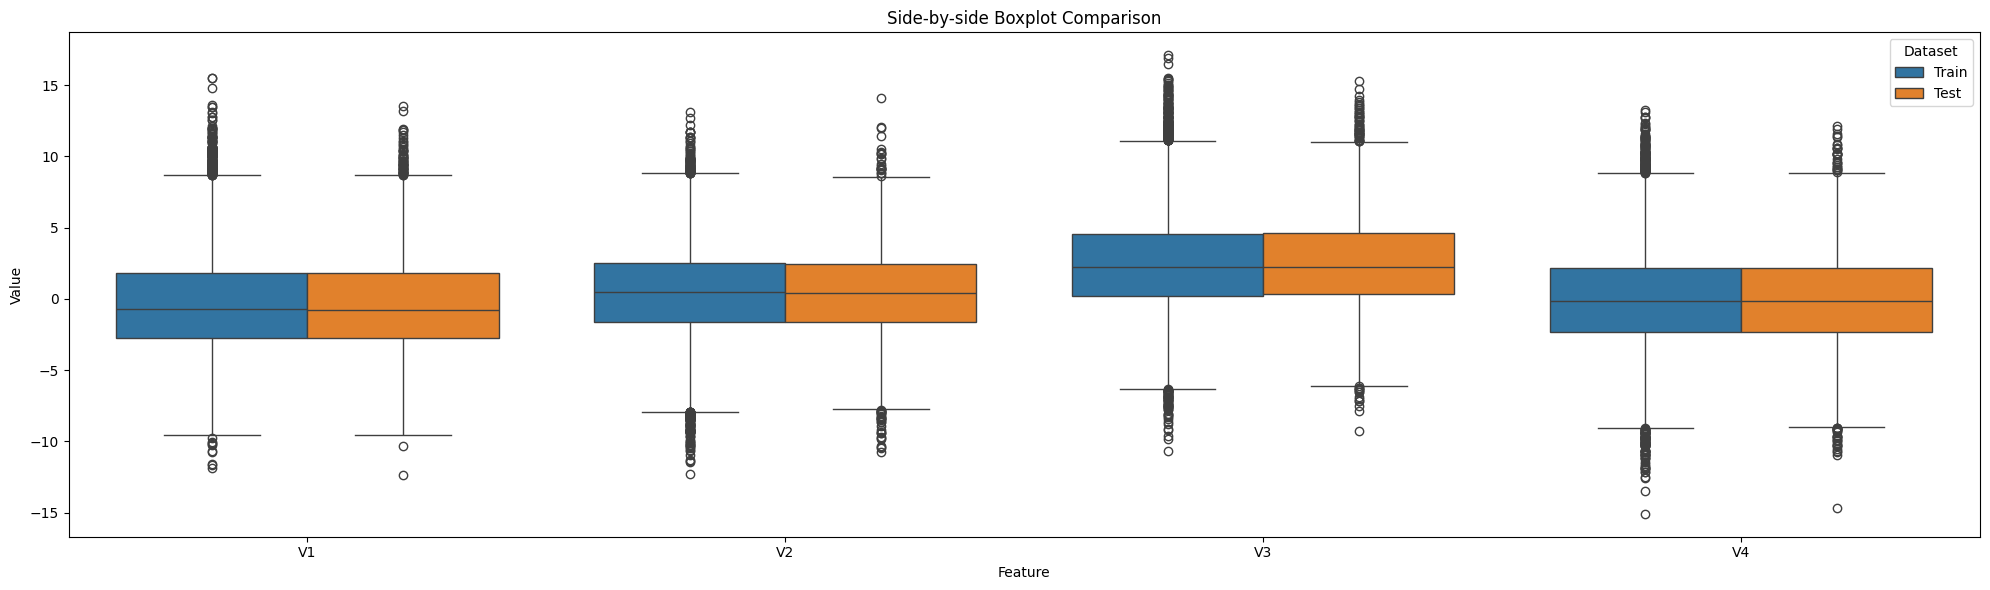

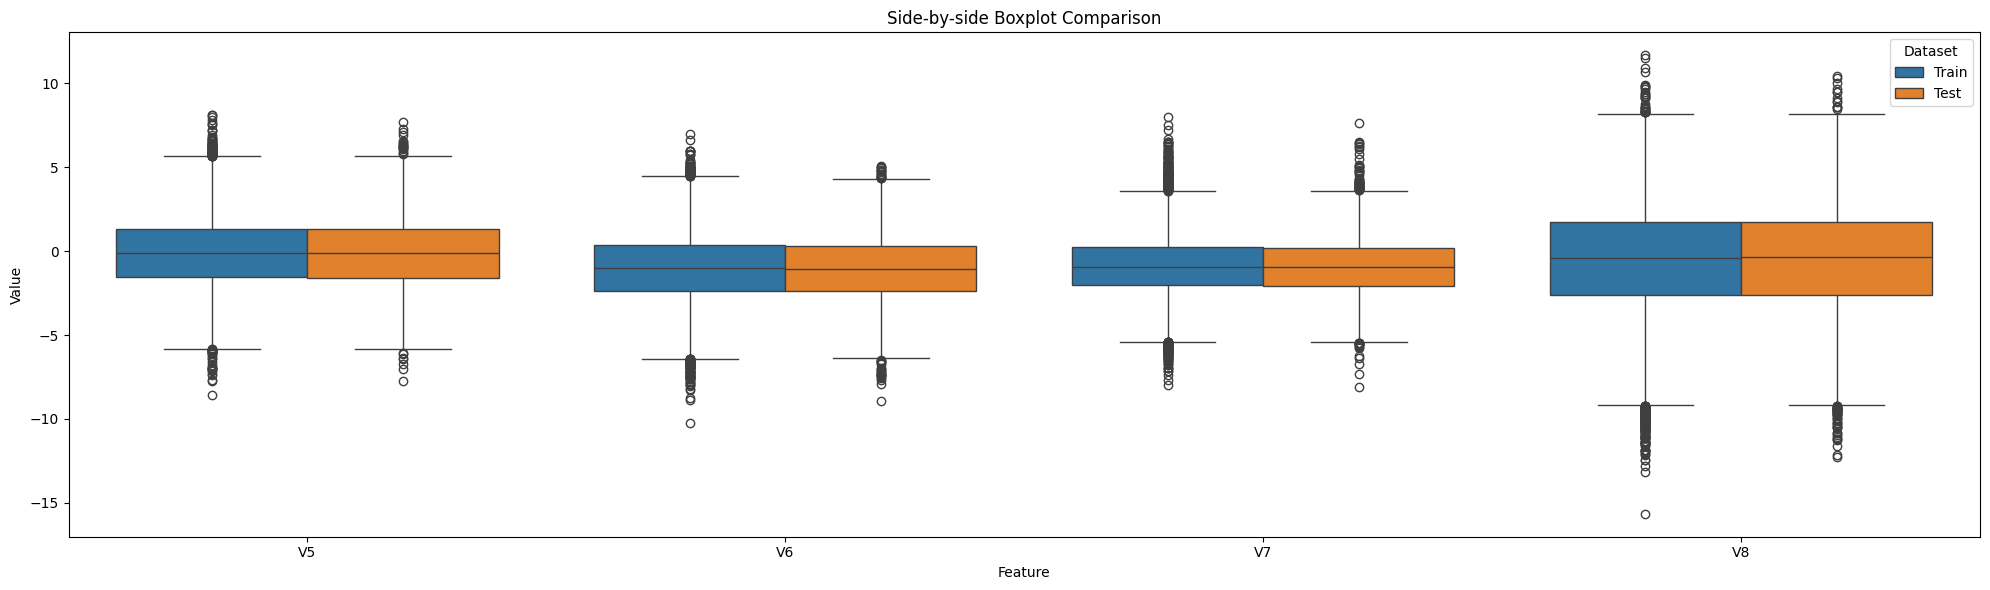

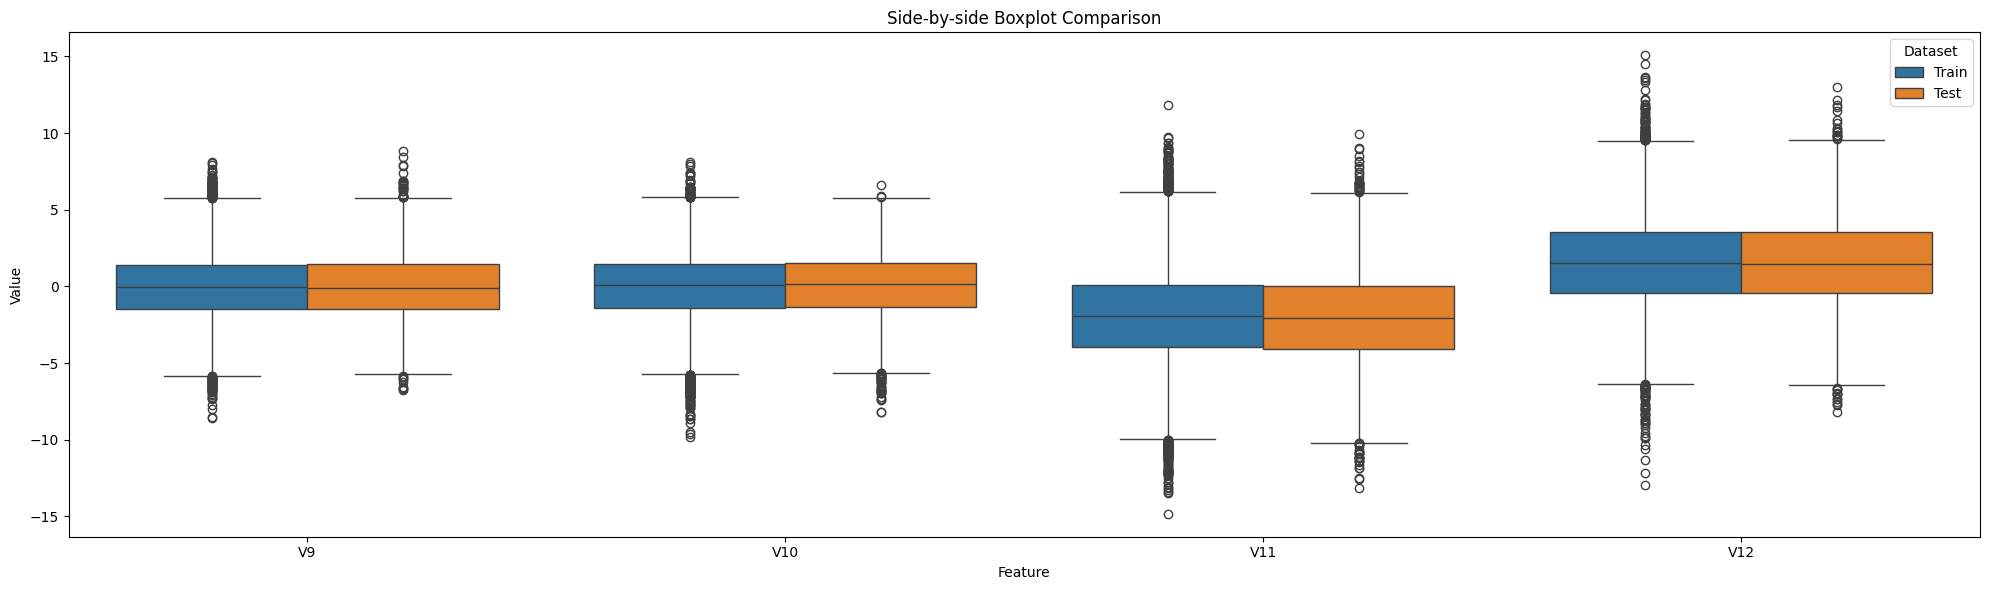

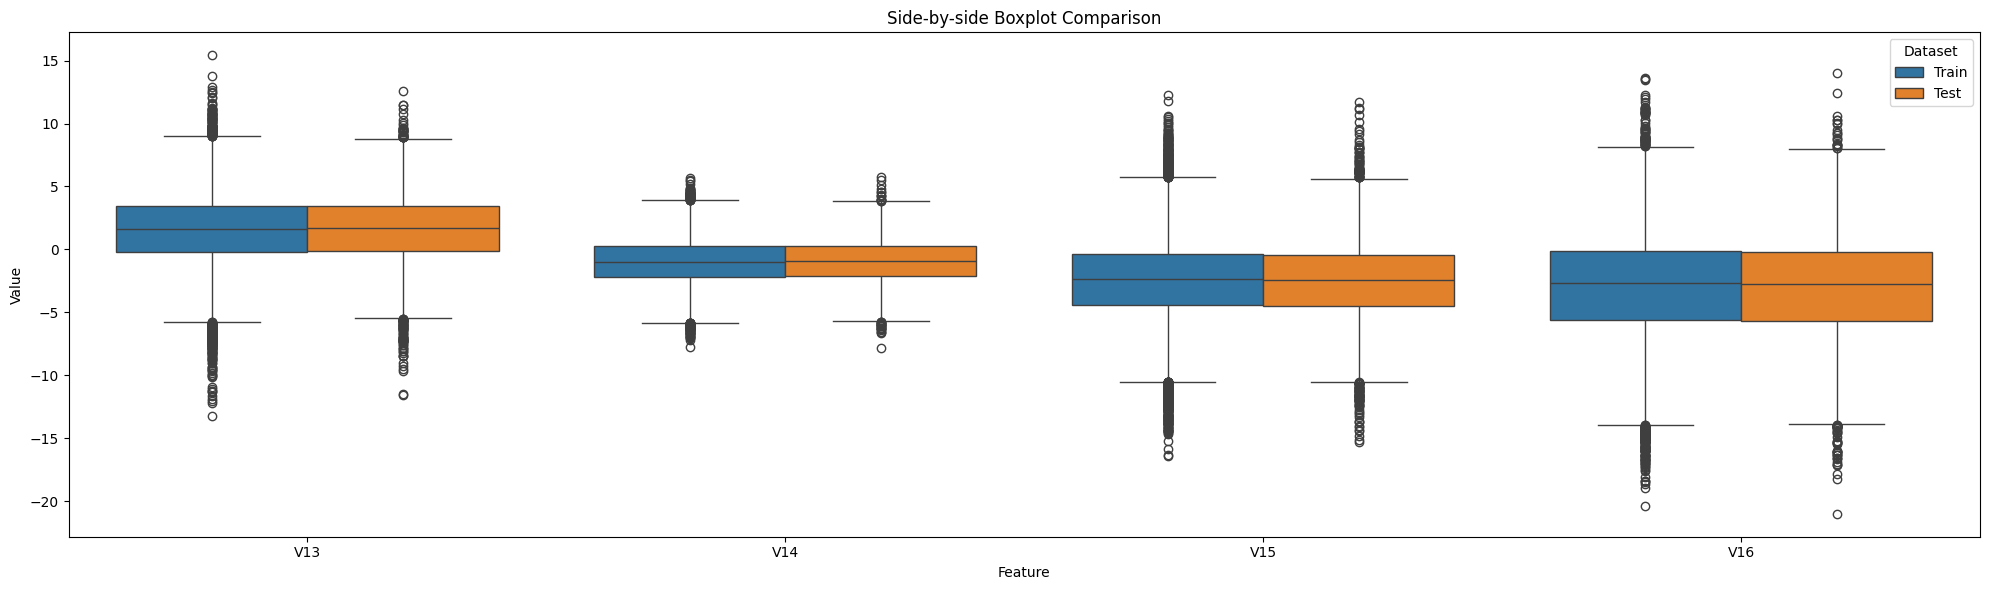

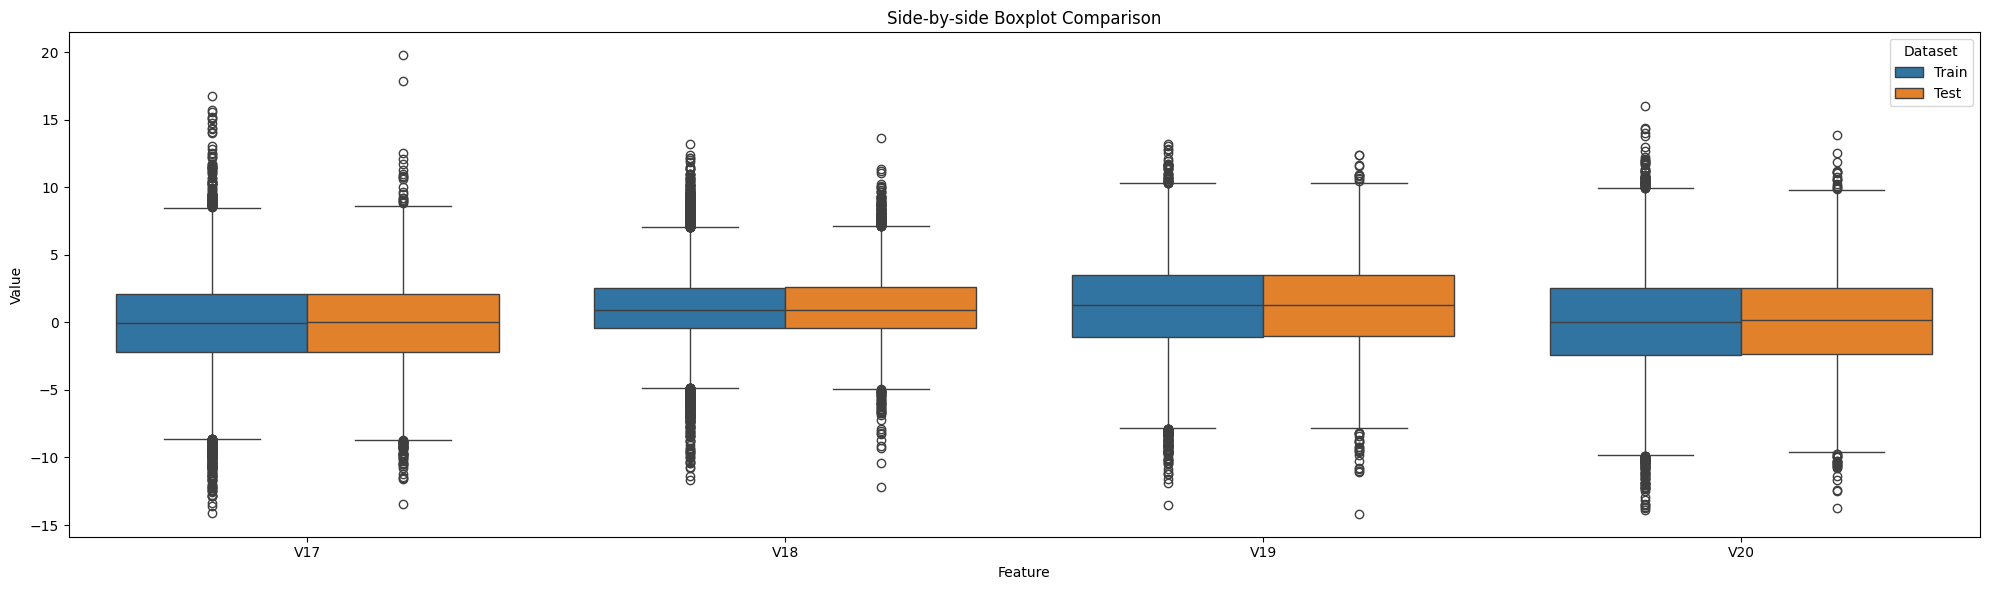

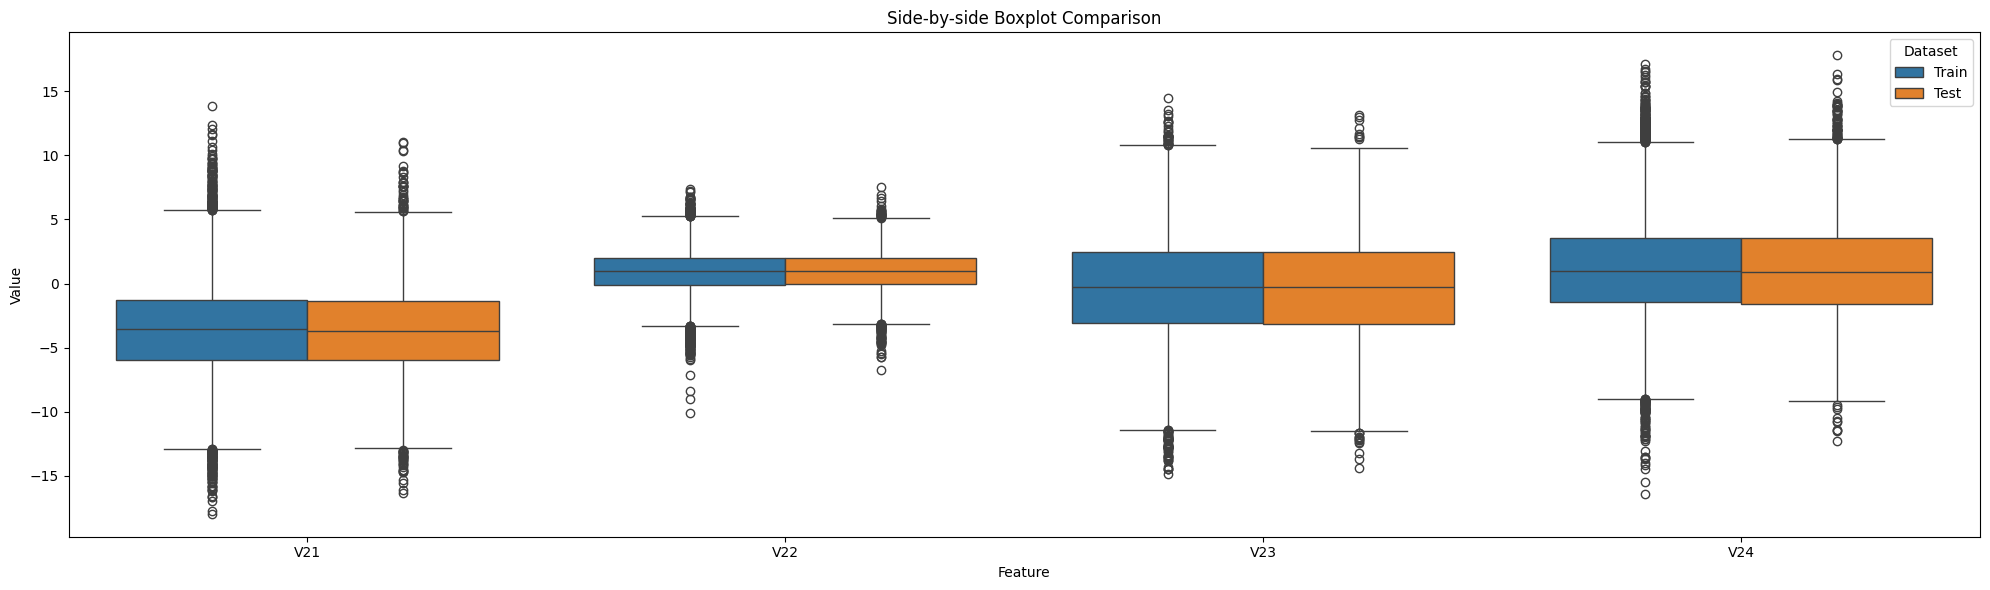

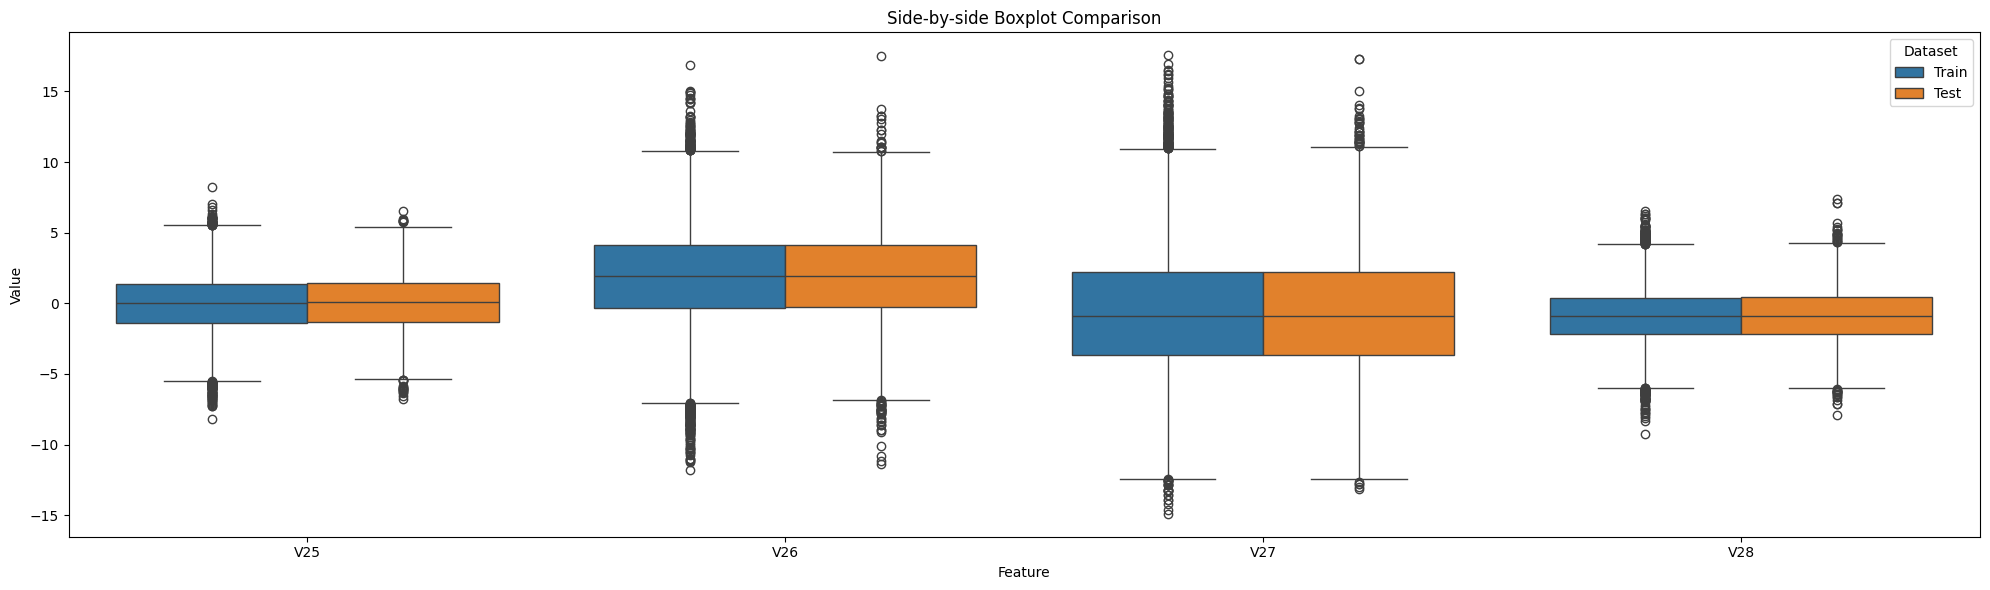

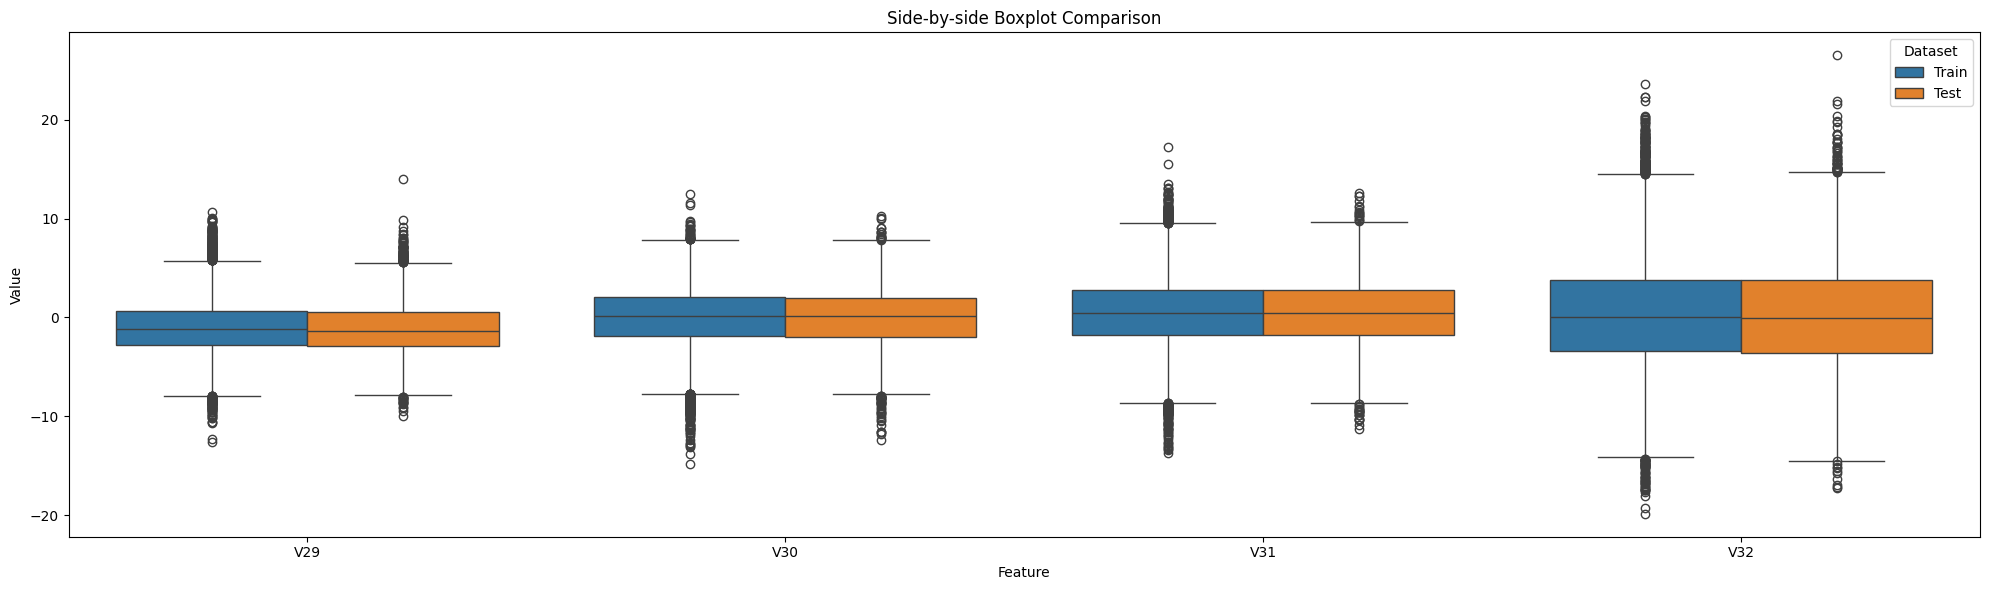

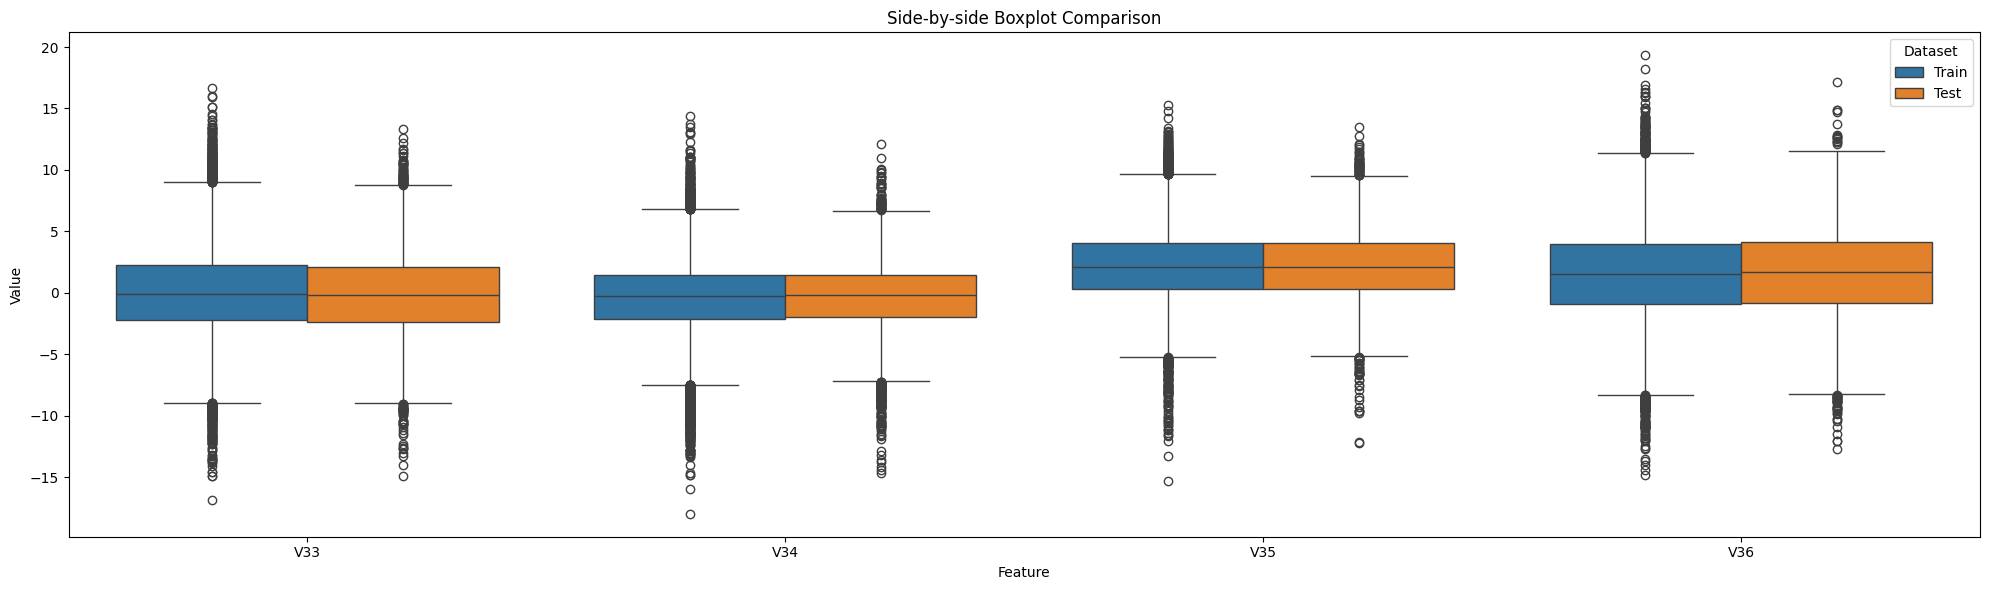

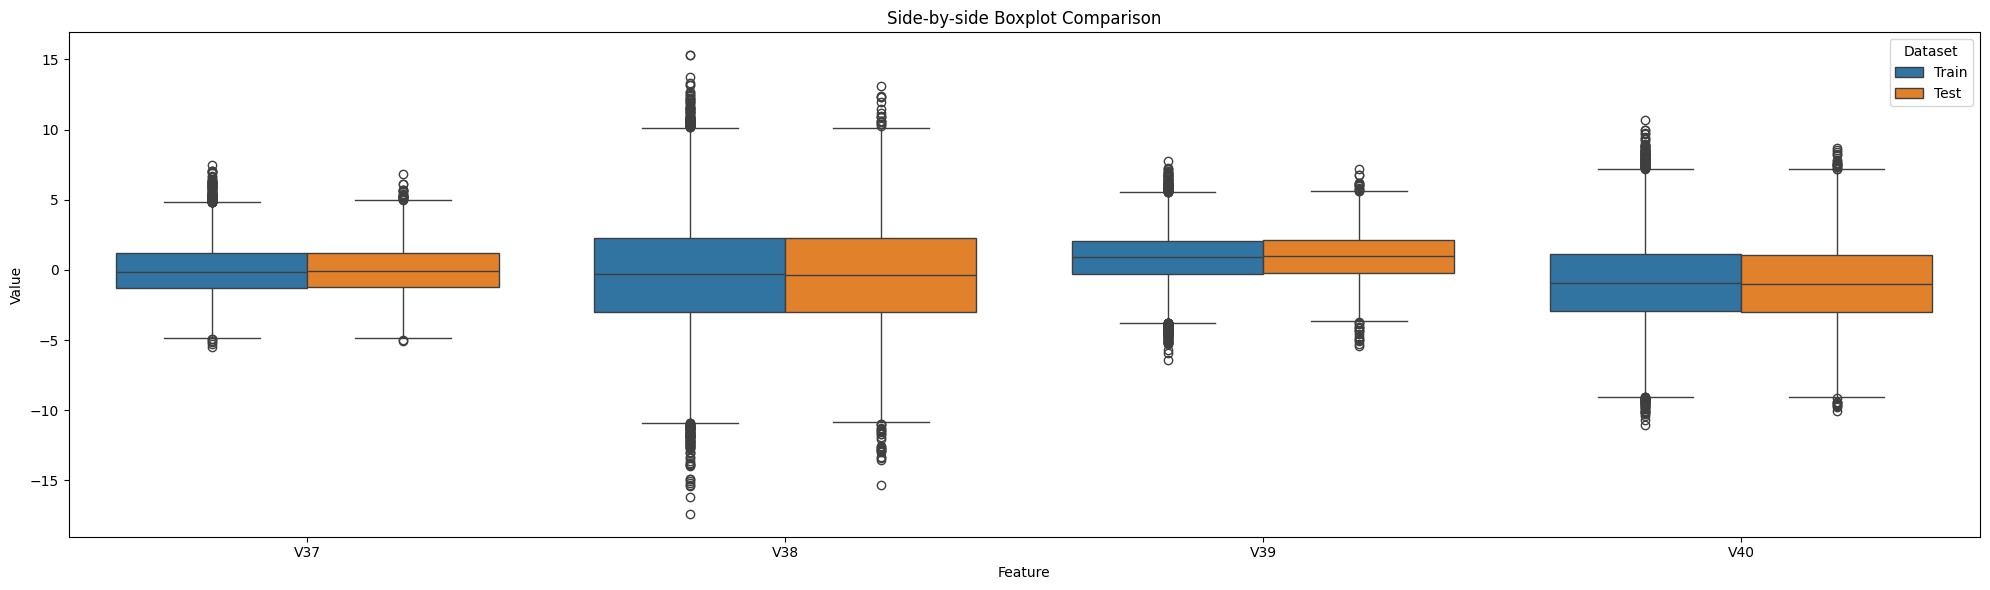

In [11]:
shared_cols = dtrain.columns.intersection(dtest.columns)
combined_boxplot_comparison(dtrain, dtest, shared_cols[:-1])

In [12]:
def combined_violinplot_comparison(dtrain, dtest, features, batch_size=4):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    for i in range(0, len(features), batch_size):
        batch_features = features[i:i + batch_size]

        # Create labeled copies
        dtrain_temp = dtrain[batch_features].copy()
        dtrain_temp['Dataset'] = 'Train'
        dtest_temp = dtest[batch_features].copy()
        dtest_temp['Dataset'] = 'Test'

        # Combine
        combined_df = pd.concat([dtrain_temp, dtest_temp], axis=0)

        # Melt for Seaborn
        melted_df = pd.melt(combined_df, id_vars='Dataset', value_vars=batch_features,
                            var_name='Feature', value_name='Value')

        # Plot
        plt.figure(figsize=(5 * batch_size, 6))
        sns.violinplot(data=melted_df, x='Feature', y='Value', hue='Dataset', split=True)
        plt.title("Side-by-side Violin Plot Comparison")
        plt.tight_layout()
        plt.show()

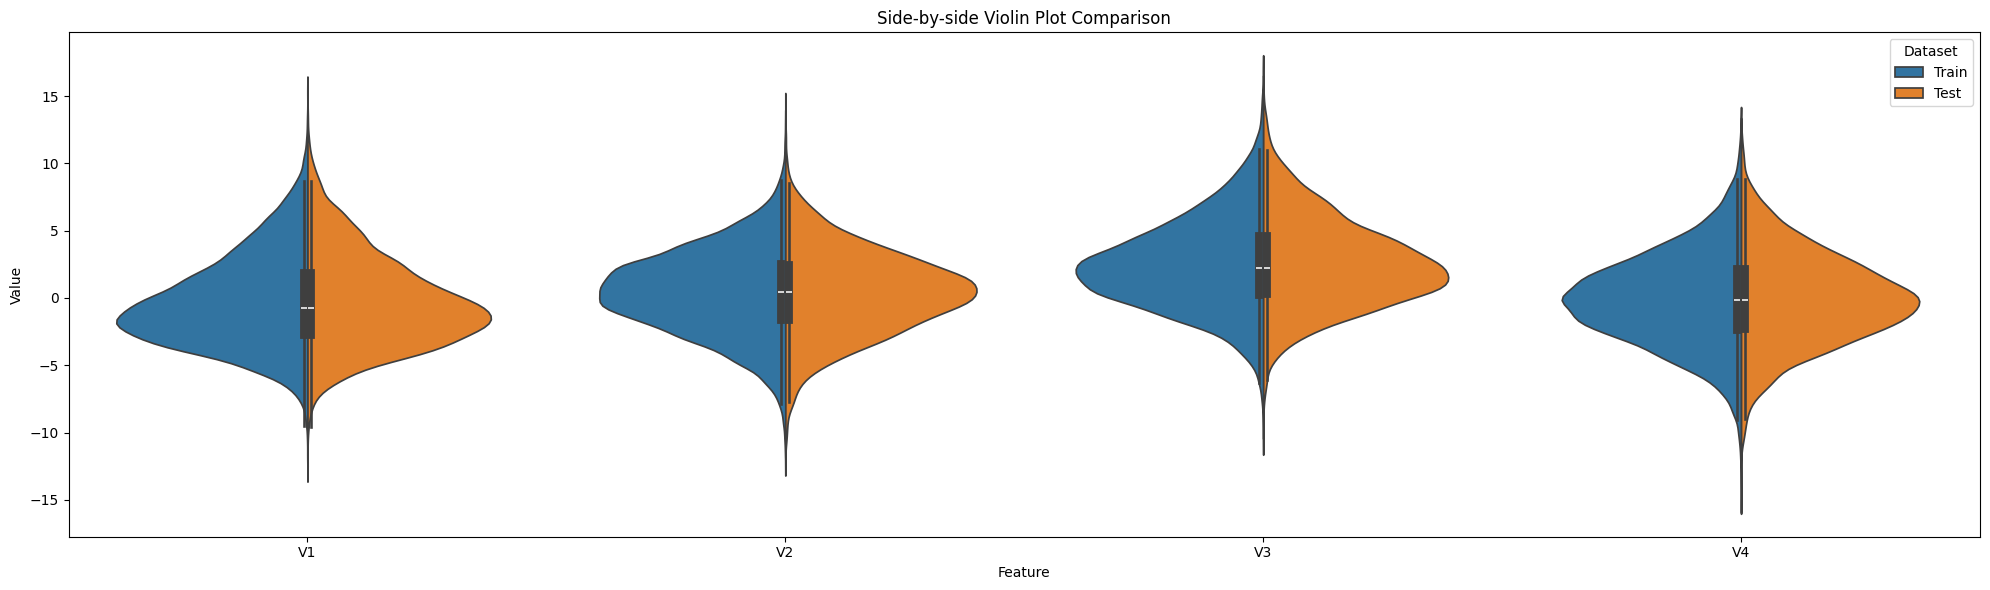

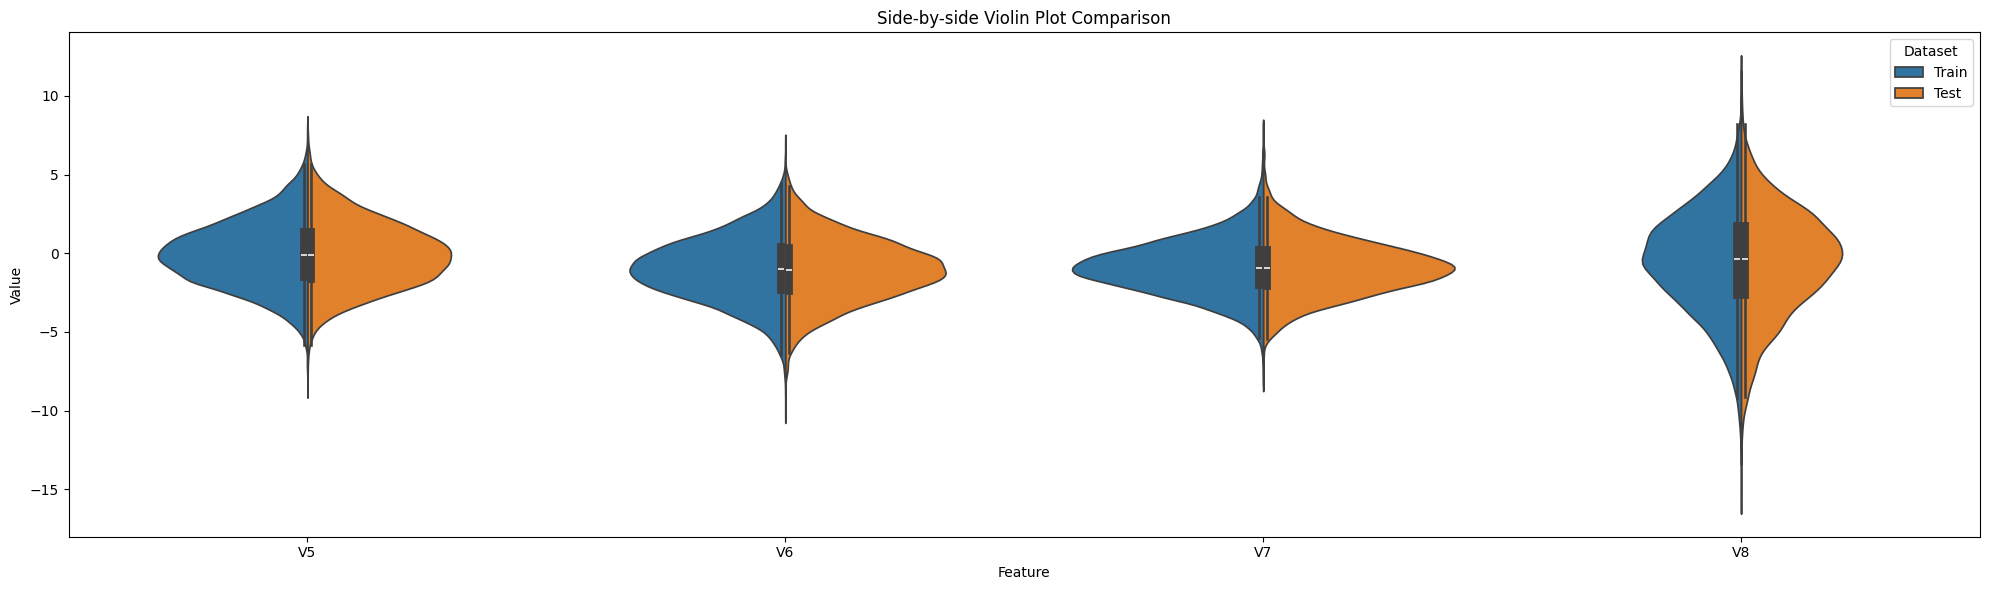

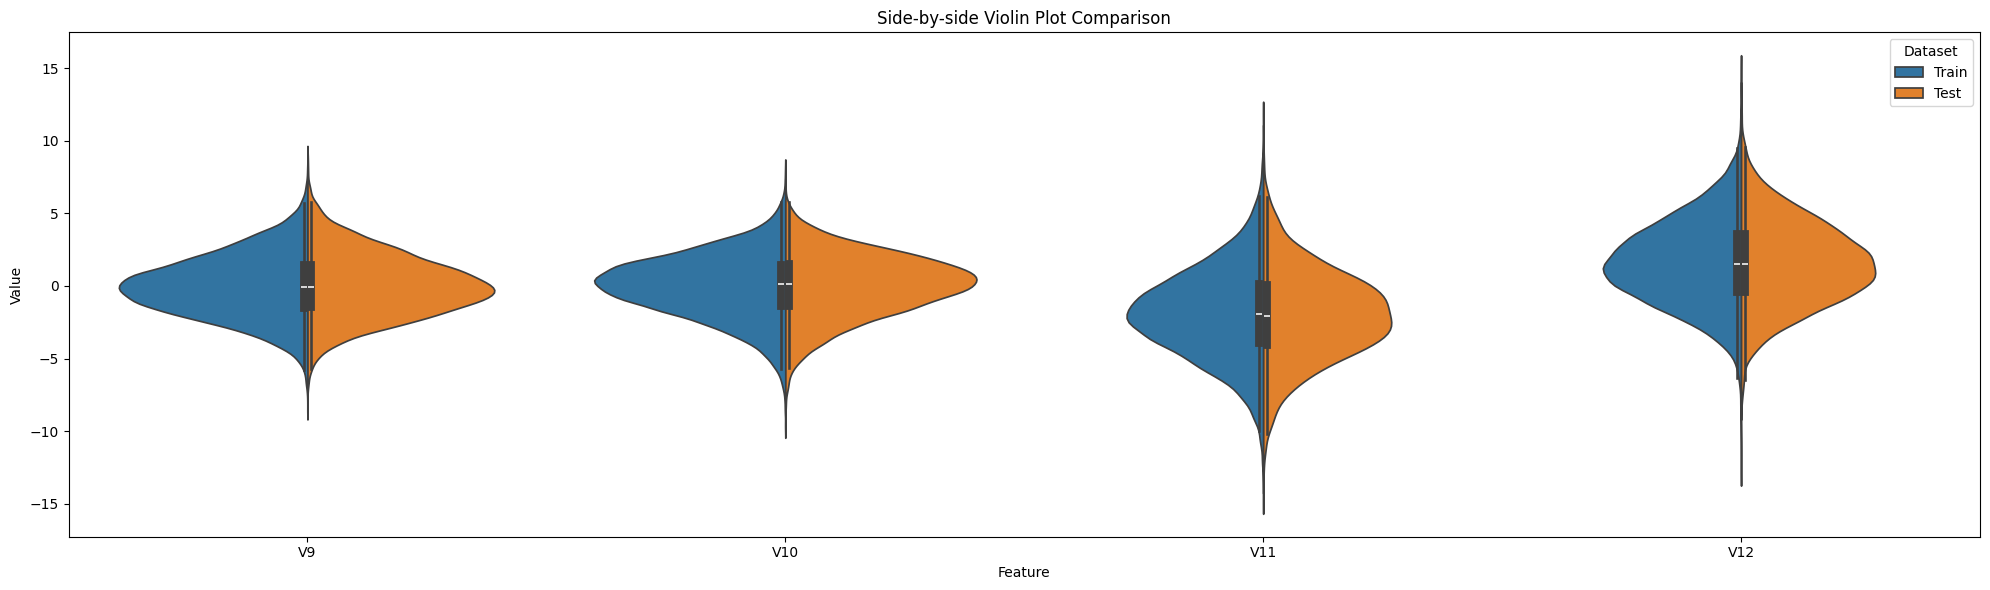

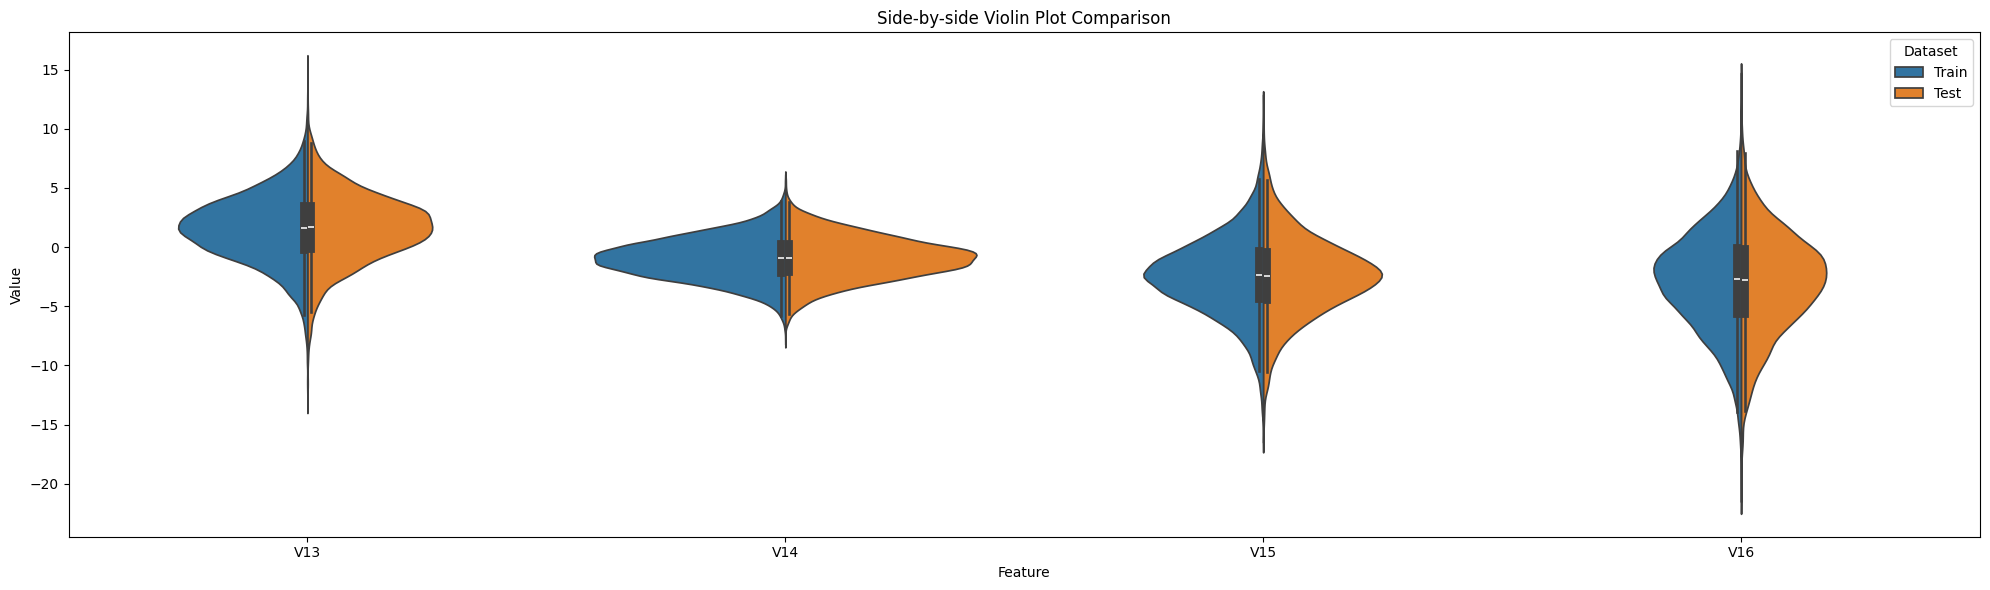

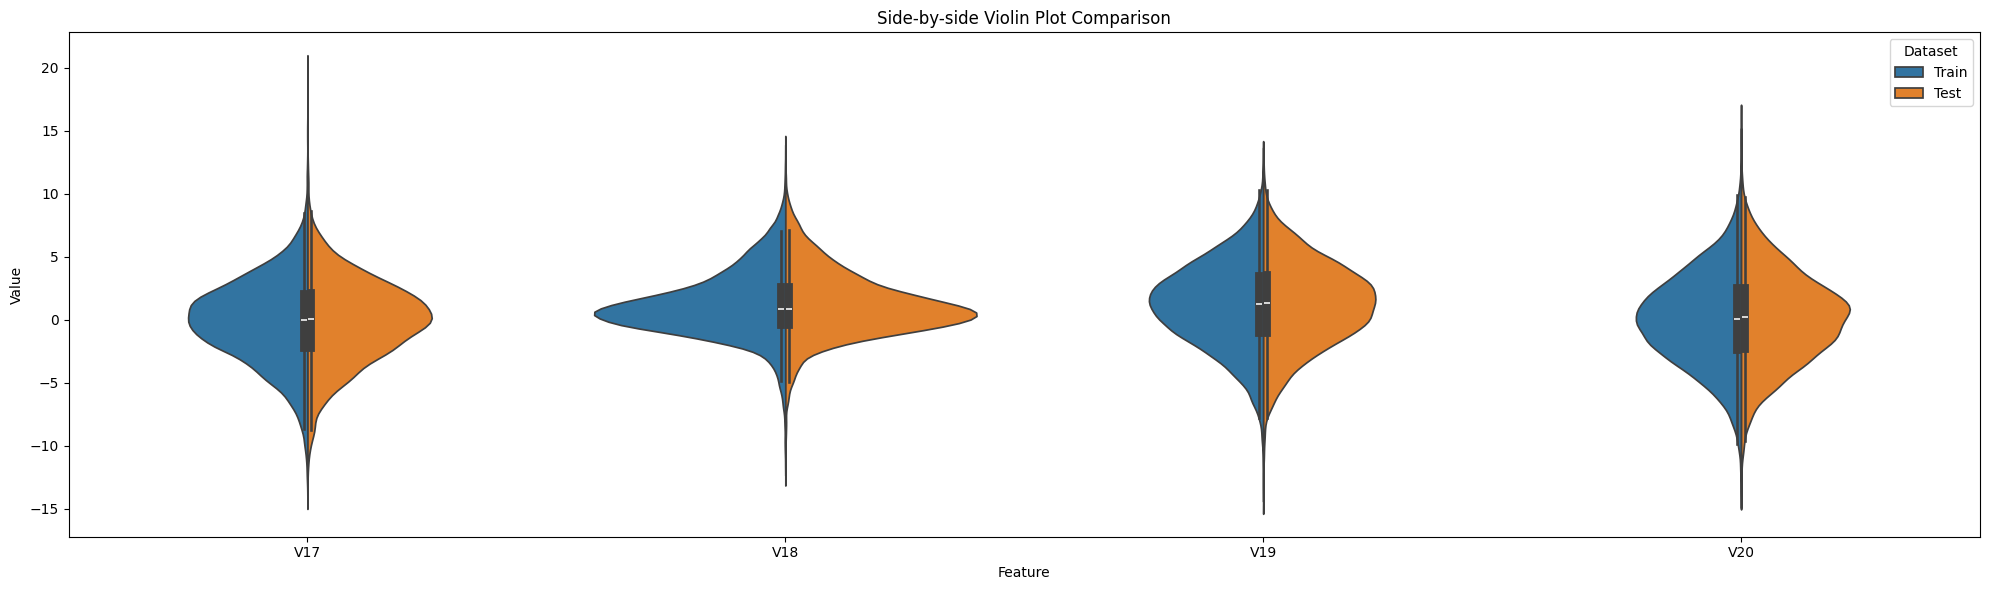

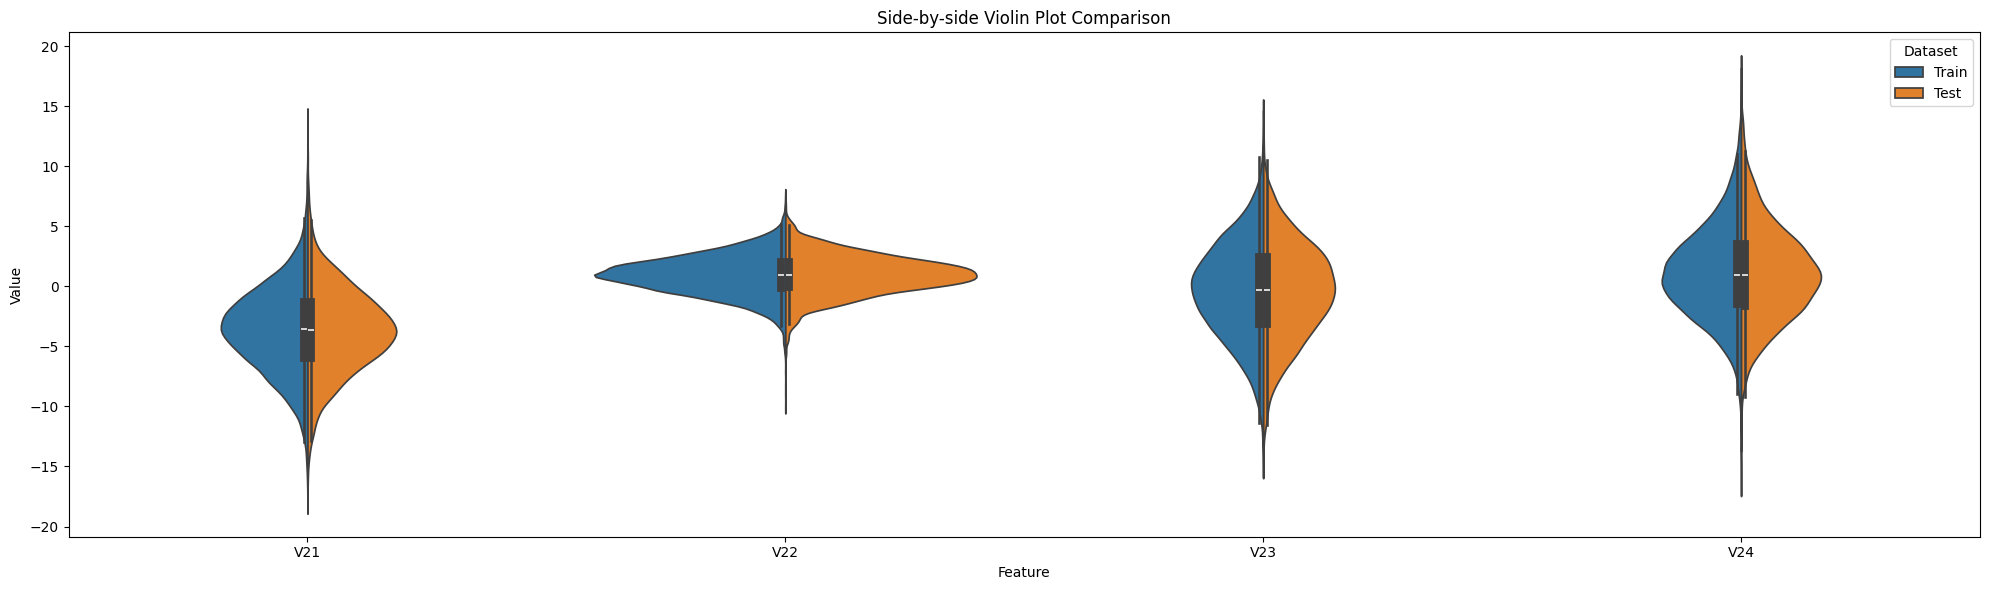

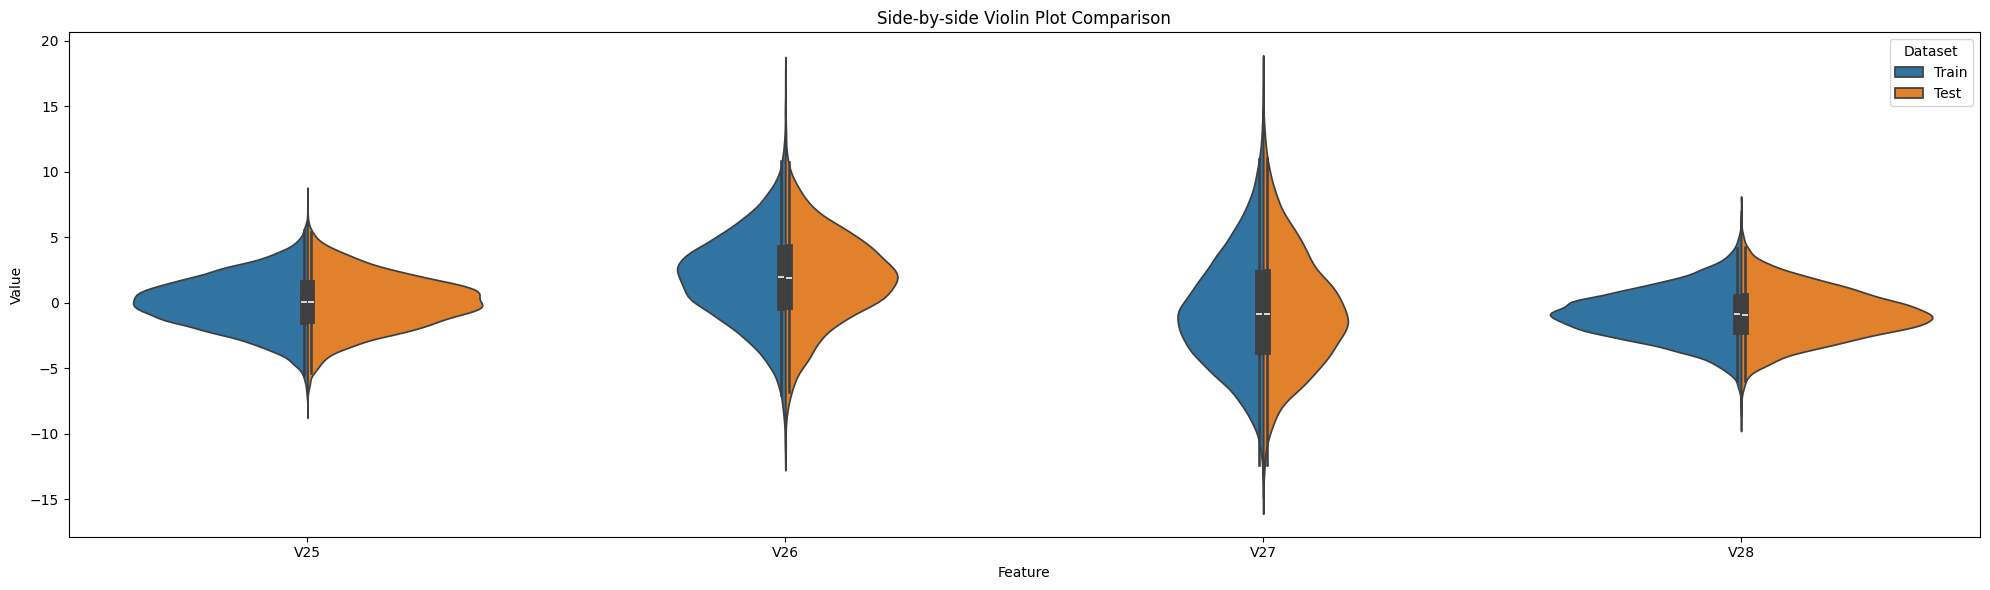

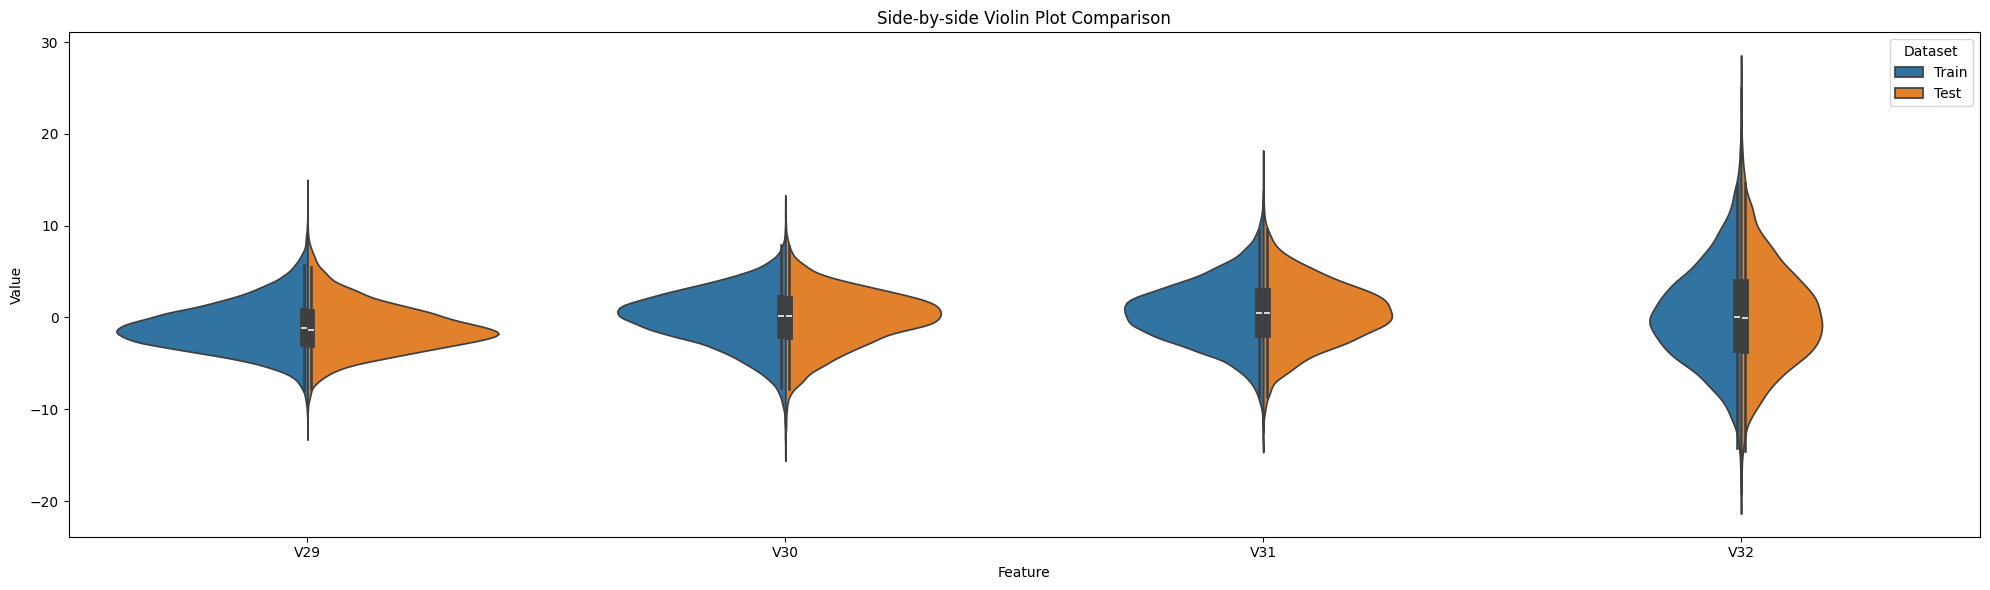

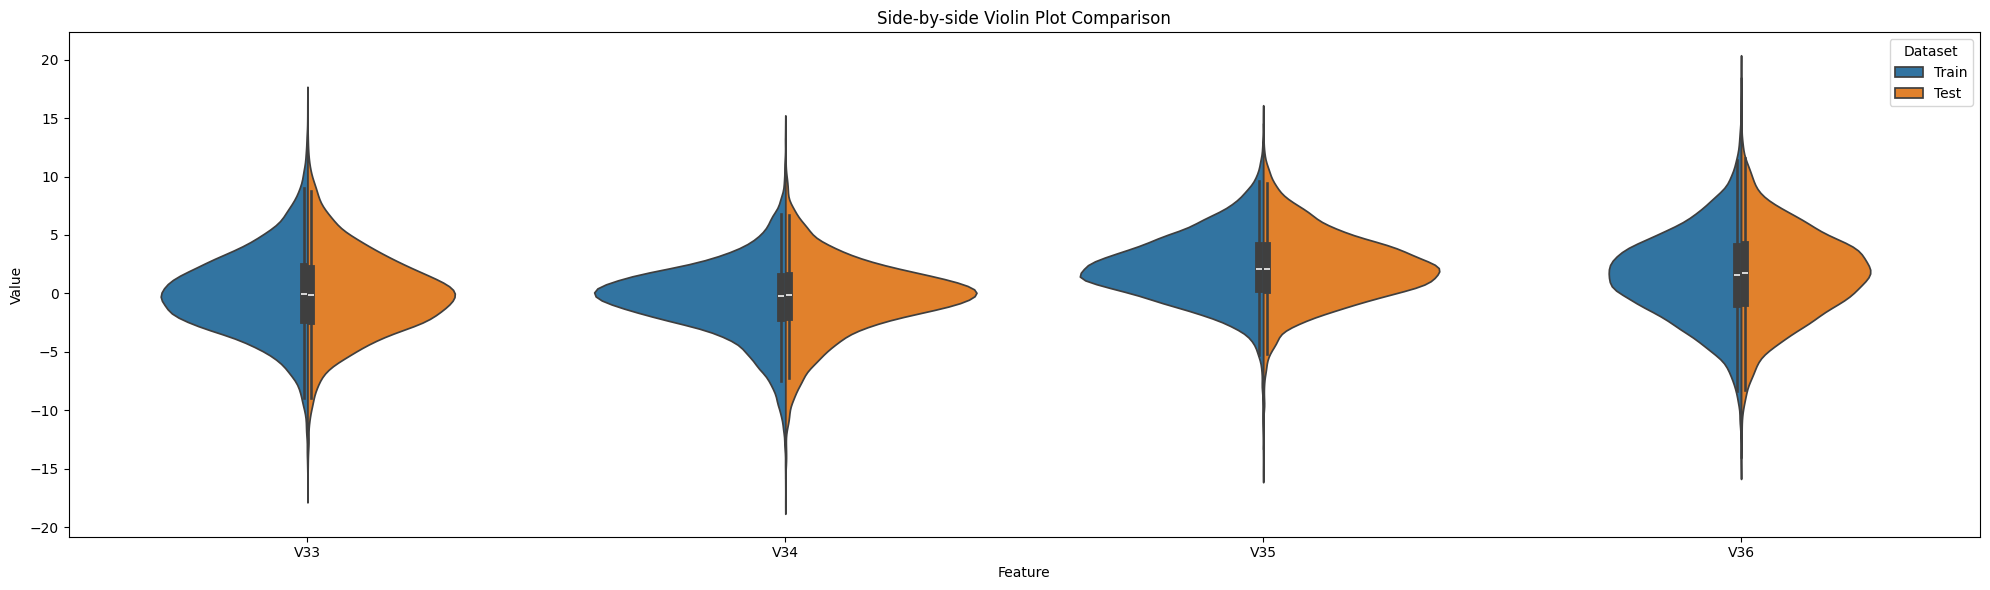

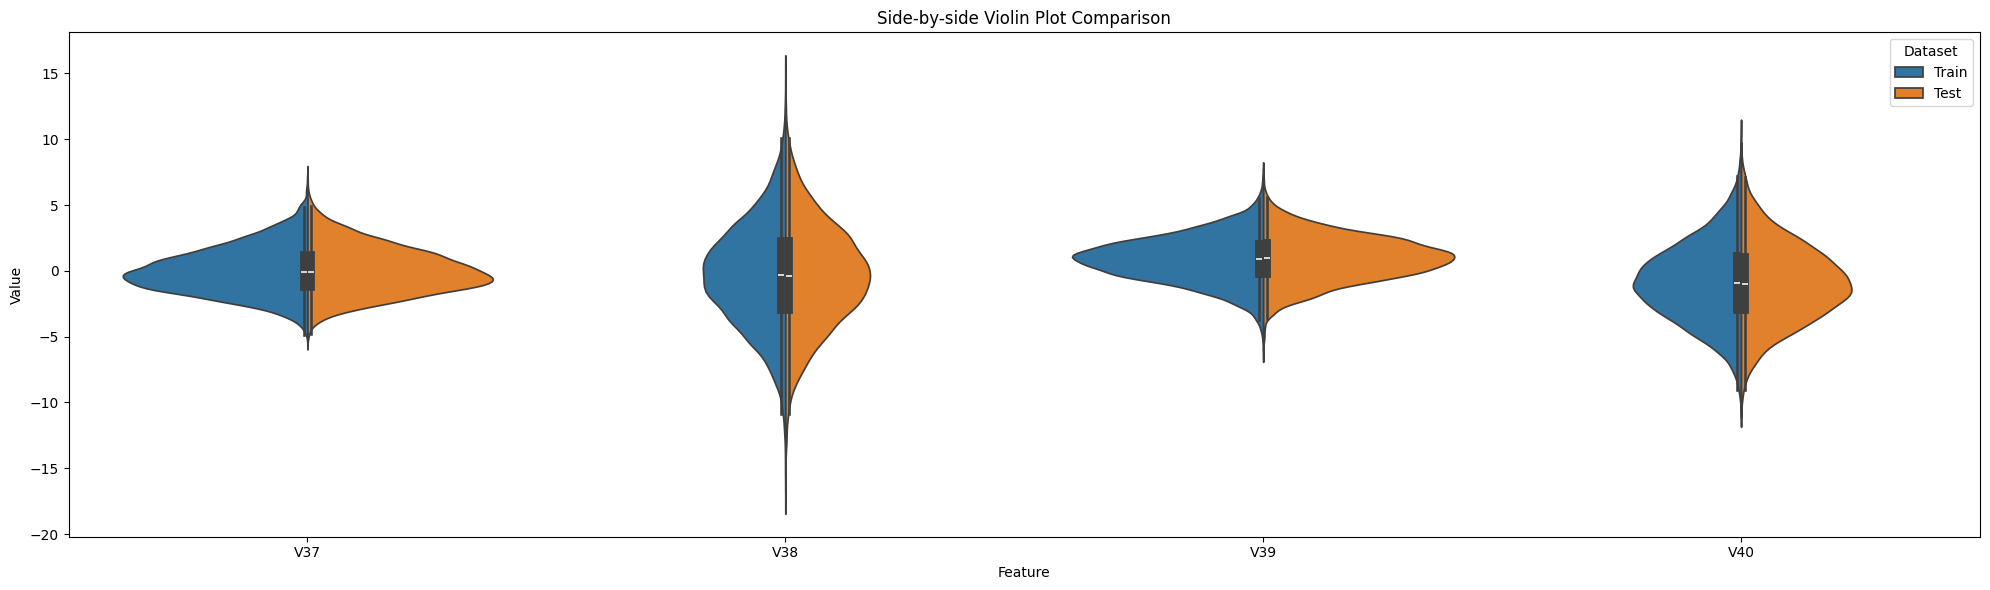

In [13]:
shared_cols = dtrain.columns.intersection(dtest.columns)
combined_violinplot_comparison(dtrain, dtest, shared_cols[:-1])

Text(0.5, 1.0, 'TRAIN Target Class Distribution')

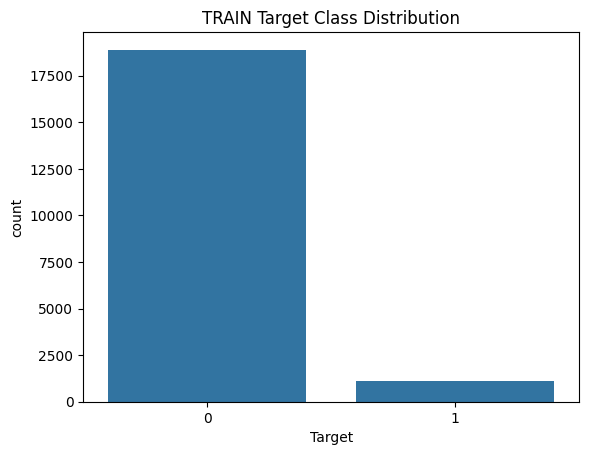

In [15]:
sns.countplot(x=dtrain['Target'])
plt.title("TRAIN Target Class Distribution")

Text(0.5, 1.0, 'TEST Target Class Distribution')

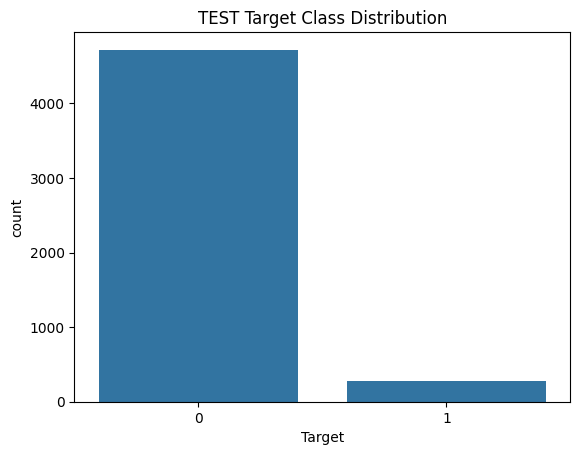

In [16]:
sns.countplot(x=dtest['Target'], color='orange')
plt.title("TEST Target Class Distribution")

### - **Univariate Conclusions on data:**


- **Feature Distribution Integrity:**
  - **Symmetry**: The data distributions for both dtrain and dtest are almost mirror-like across all features, meaning there's no evidence of drift or significant distribution shift between train and test sets. This is excellent — it means the model won't be learning patterns that don't generalize.

  - **Scaling**: The variables appear to have been standardized or normalized (centered around 0 with similar spreads), likely with a transformation such as StandardScaler, which is why mean imputation made sense earlier.

    - **Conclusion**: The preprocessing or feature engineering stage was likely done correctly and consistently for both train and test sets. So: don't need to worry about additional scaling or transformation. EDA confirms feature distribution integrity between datasets — very important for building trustworthy models.

## Bivariate Analysis

In [21]:
dtrain = pd.read_csv('/content/dtrain1.csv')
dtest = pd.read_csv('/content/dtest1.csv')

### - **Training Bivariate:**

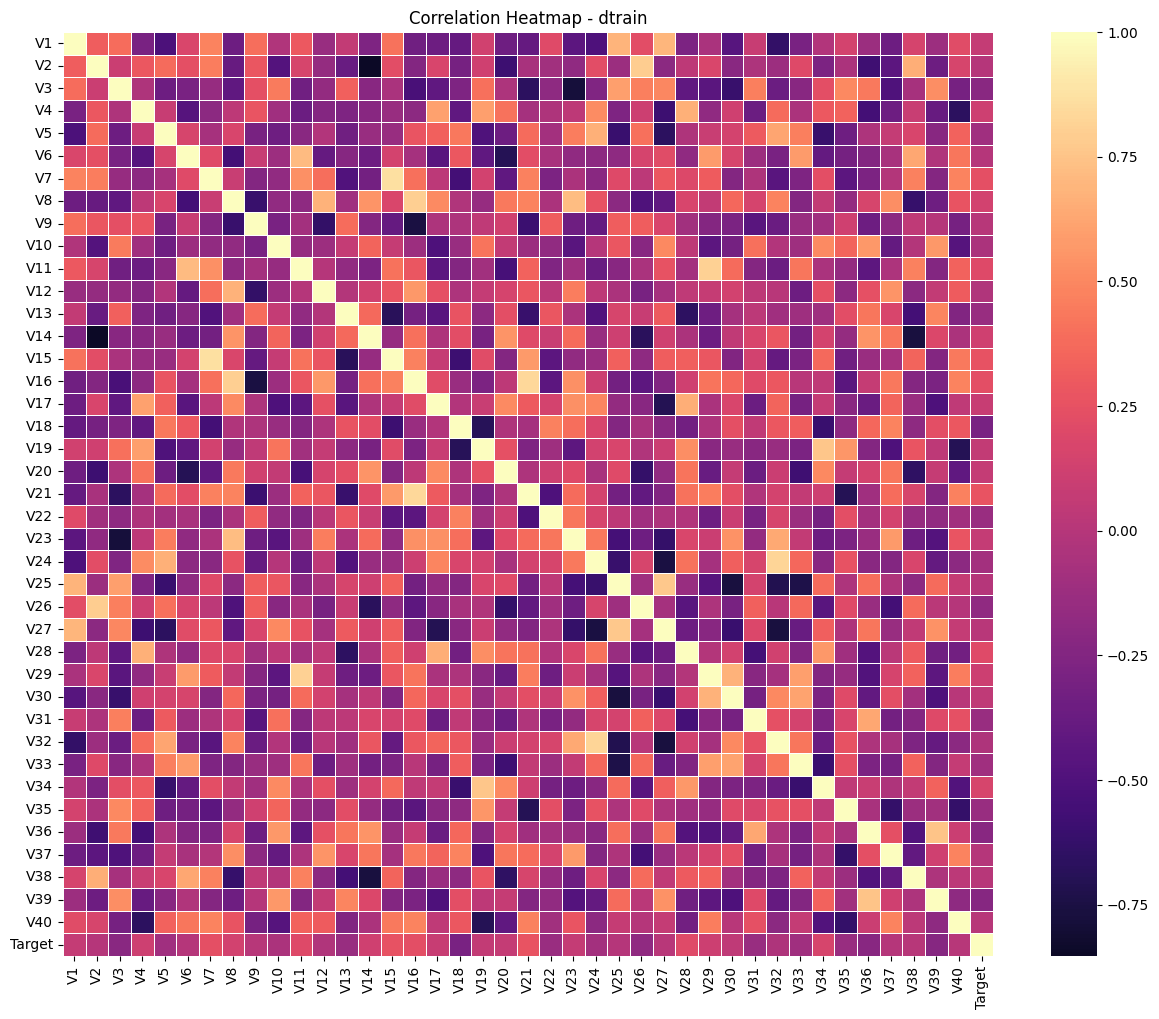

In [19]:
# Compute correlation matrix for training data
corr = dtrain.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='magma', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - dtrain")
plt.show()

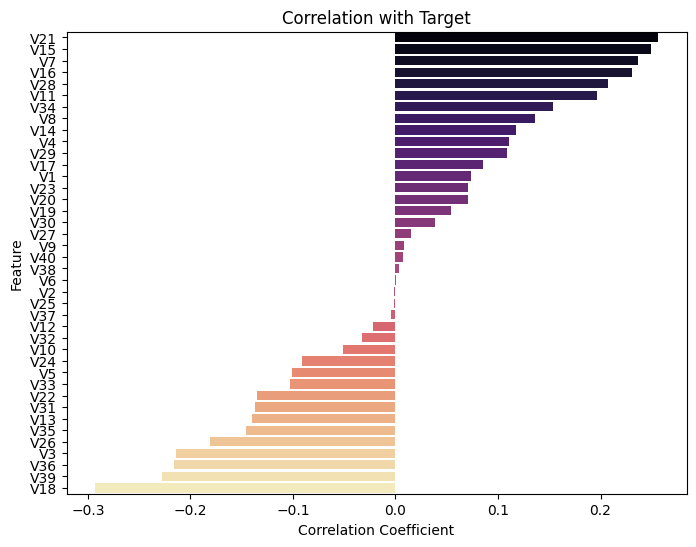

In [20]:
target_corr = corr['Target'].drop('Target').sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='magma')
plt.title("Correlation with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

In [24]:
def violinplot_by_target(data, features, target_col='Target', n_cols=4):
    import math

    n_rows = math.ceil(len(features) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axs = axs.flatten()

    for i, col in enumerate(features):
        sns.violinplot(x=target_col, y=col, data=data, ax=axs[i], palette="Set2")
        axs[i].set_title(f'{col} by {target_col}')

    for i in range(len(features), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

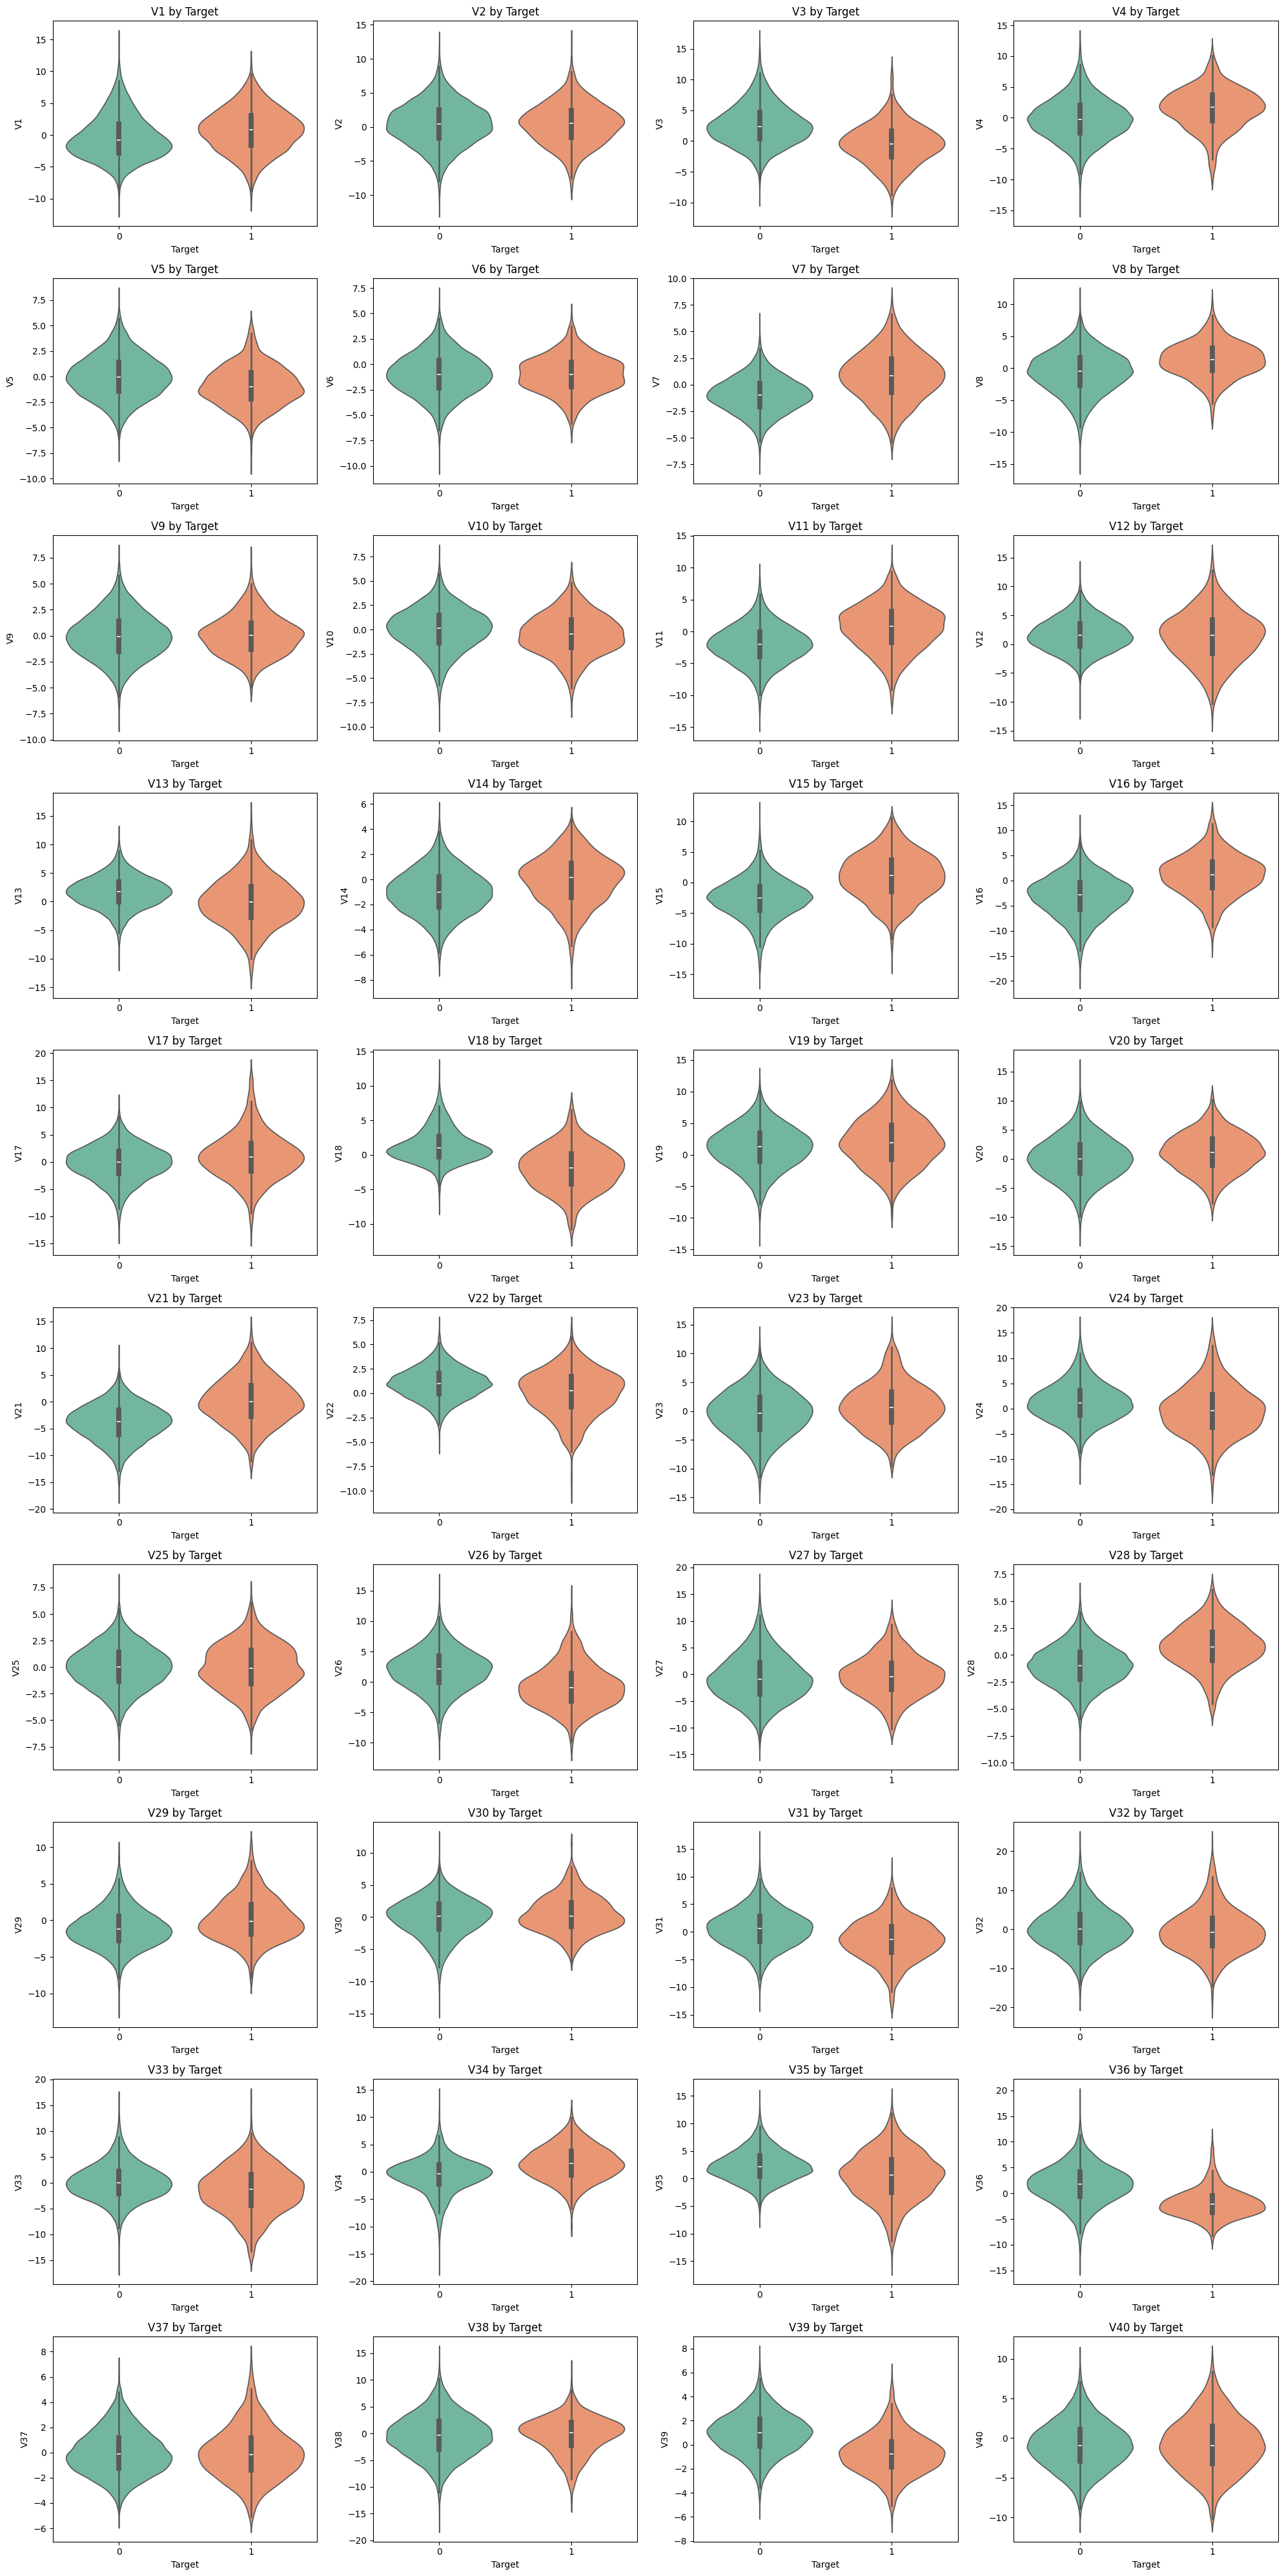

In [25]:
violinplot_by_target(dtrain, dtrain.columns[:-1])

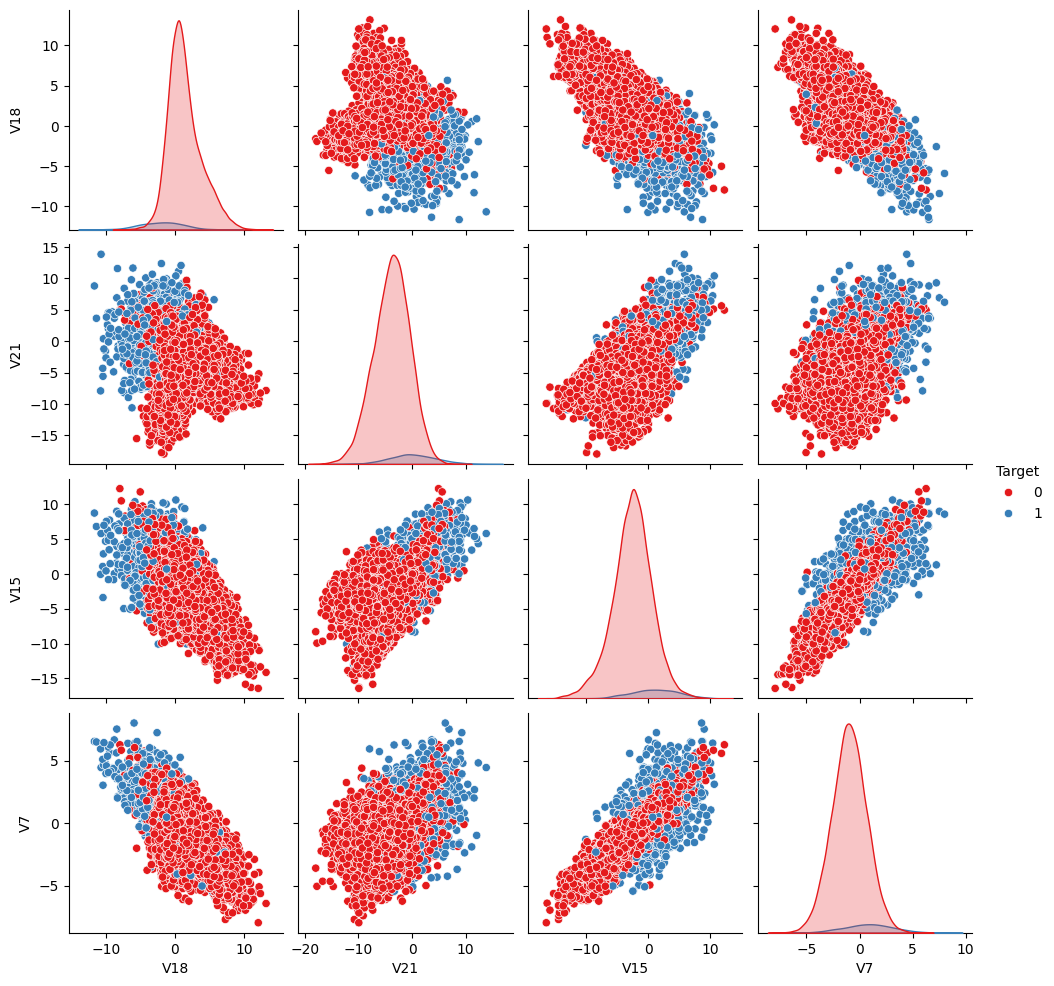

In [27]:
# Top correlated features (absolute value)
corr_with_target = dtrain.corr()['Target'].abs().sort_values(ascending=False)
top_features = corr_with_target[1:5].index.tolist()  # Exclude 'target' itself

# Pairplot
sns.pairplot(dtrain[top_features + ['Target']], hue='Target', palette='Set1')
plt.show()


- **Training Conclusion**:
  - Feature selection: We now have a sense of which variables contribute more toward predicting the target.
  - Dimensionality reduction: We could filter out features with nearly zero correlation if they’re also uninformative via other techniques (like variance threshold or feature importance from tree models if data and features weren't transformed).
  - Correlations between –0.3 and 0.2 are weak to moderate at best, which is not a major concern for collinearity, especially for neural nets that handle redundant info better than linear models.
  - Pairplot:
  We explored the top features most correlated with the target using a seaborn pairplot and KDE plots (diagonal).Although correlation values are modest (ranging from -0.3 to 0.2), the distribution patterns are visibly different between the two classes (Target = 0 vs. Target = 1), especially in variables like V18, V21, V15, and V7.
    - V18 and V21 show an inverse relationship, where higher values of V18 correspond to lower values of V21, with class 1 (Target = 1) clustered in distinct regions — a promising signal for learnable separation.
    - Despite class imbalance (~5% positives), KDE plots reveal class-specific density peaks, suggesting these features may hold predictive value for classification.
    - Since the data is already normalized, this analysis confirms that transformation was applied consistently, and the distributions remain informative for training.
    - These insights validate that the selected features can help in model learning and should be retained during model training, especially in architectures like neural networks that benefit from normalized, distinguishable input spaces.


### - **Test Data Bivariate:**

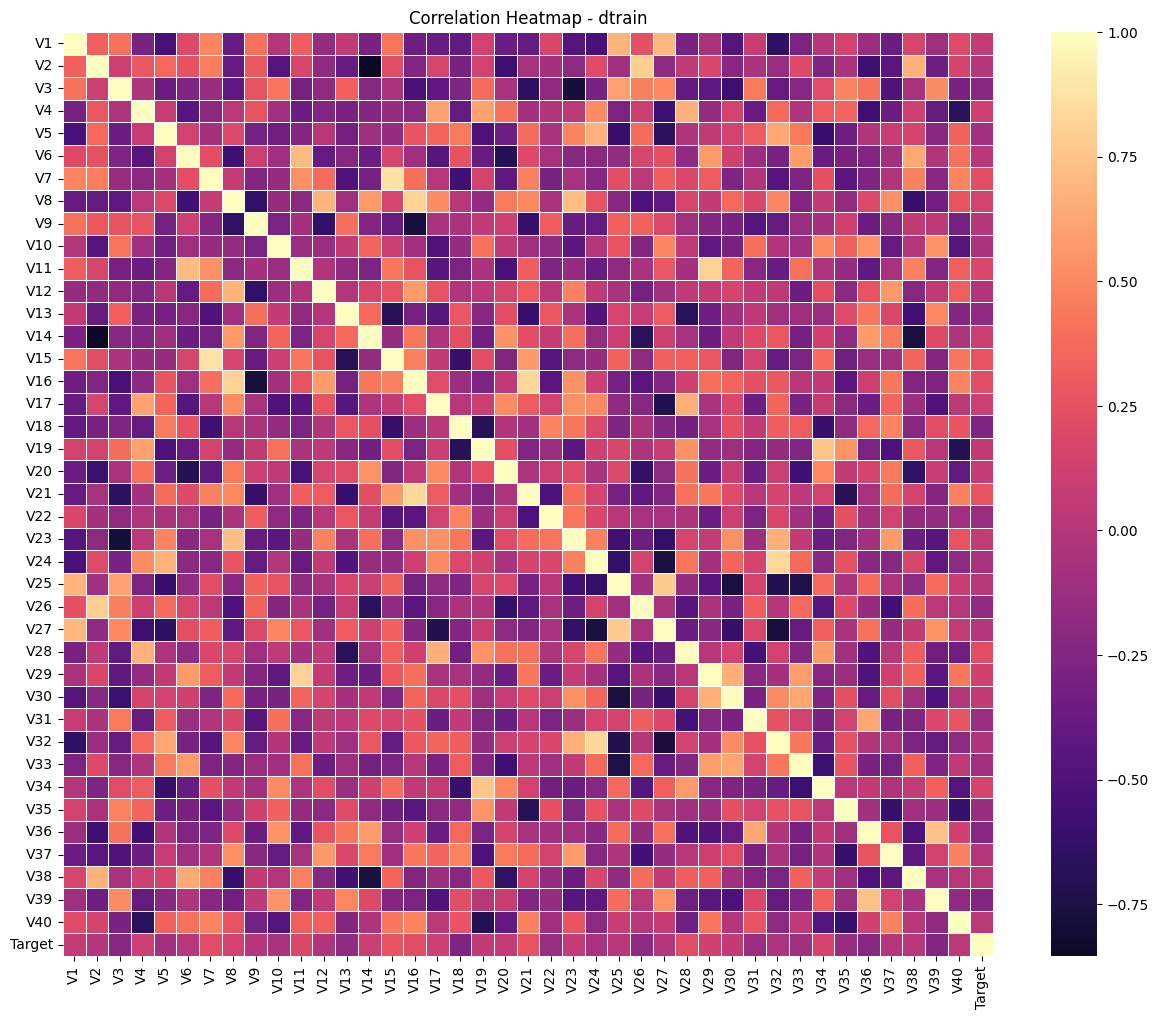

In [22]:
# Compute correlation matrix for testing data
corr = dtest.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='magma', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - dtrain")
plt.show()

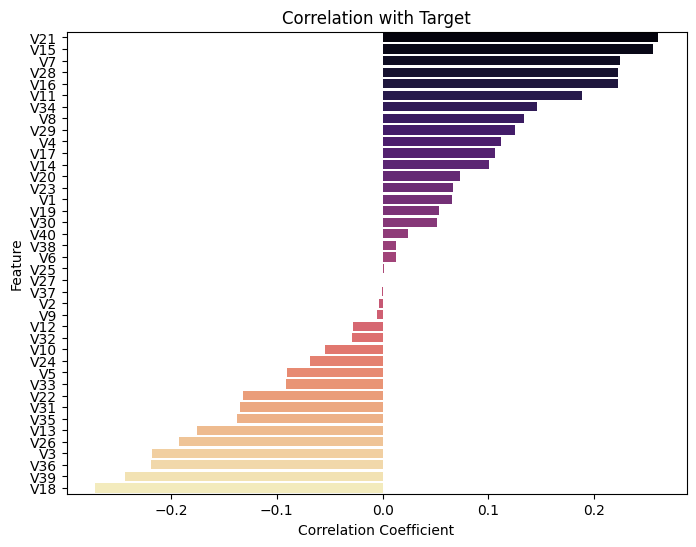

In [23]:
target_corr = corr['Target'].drop('Target').sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='magma')
plt.title("Correlation with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

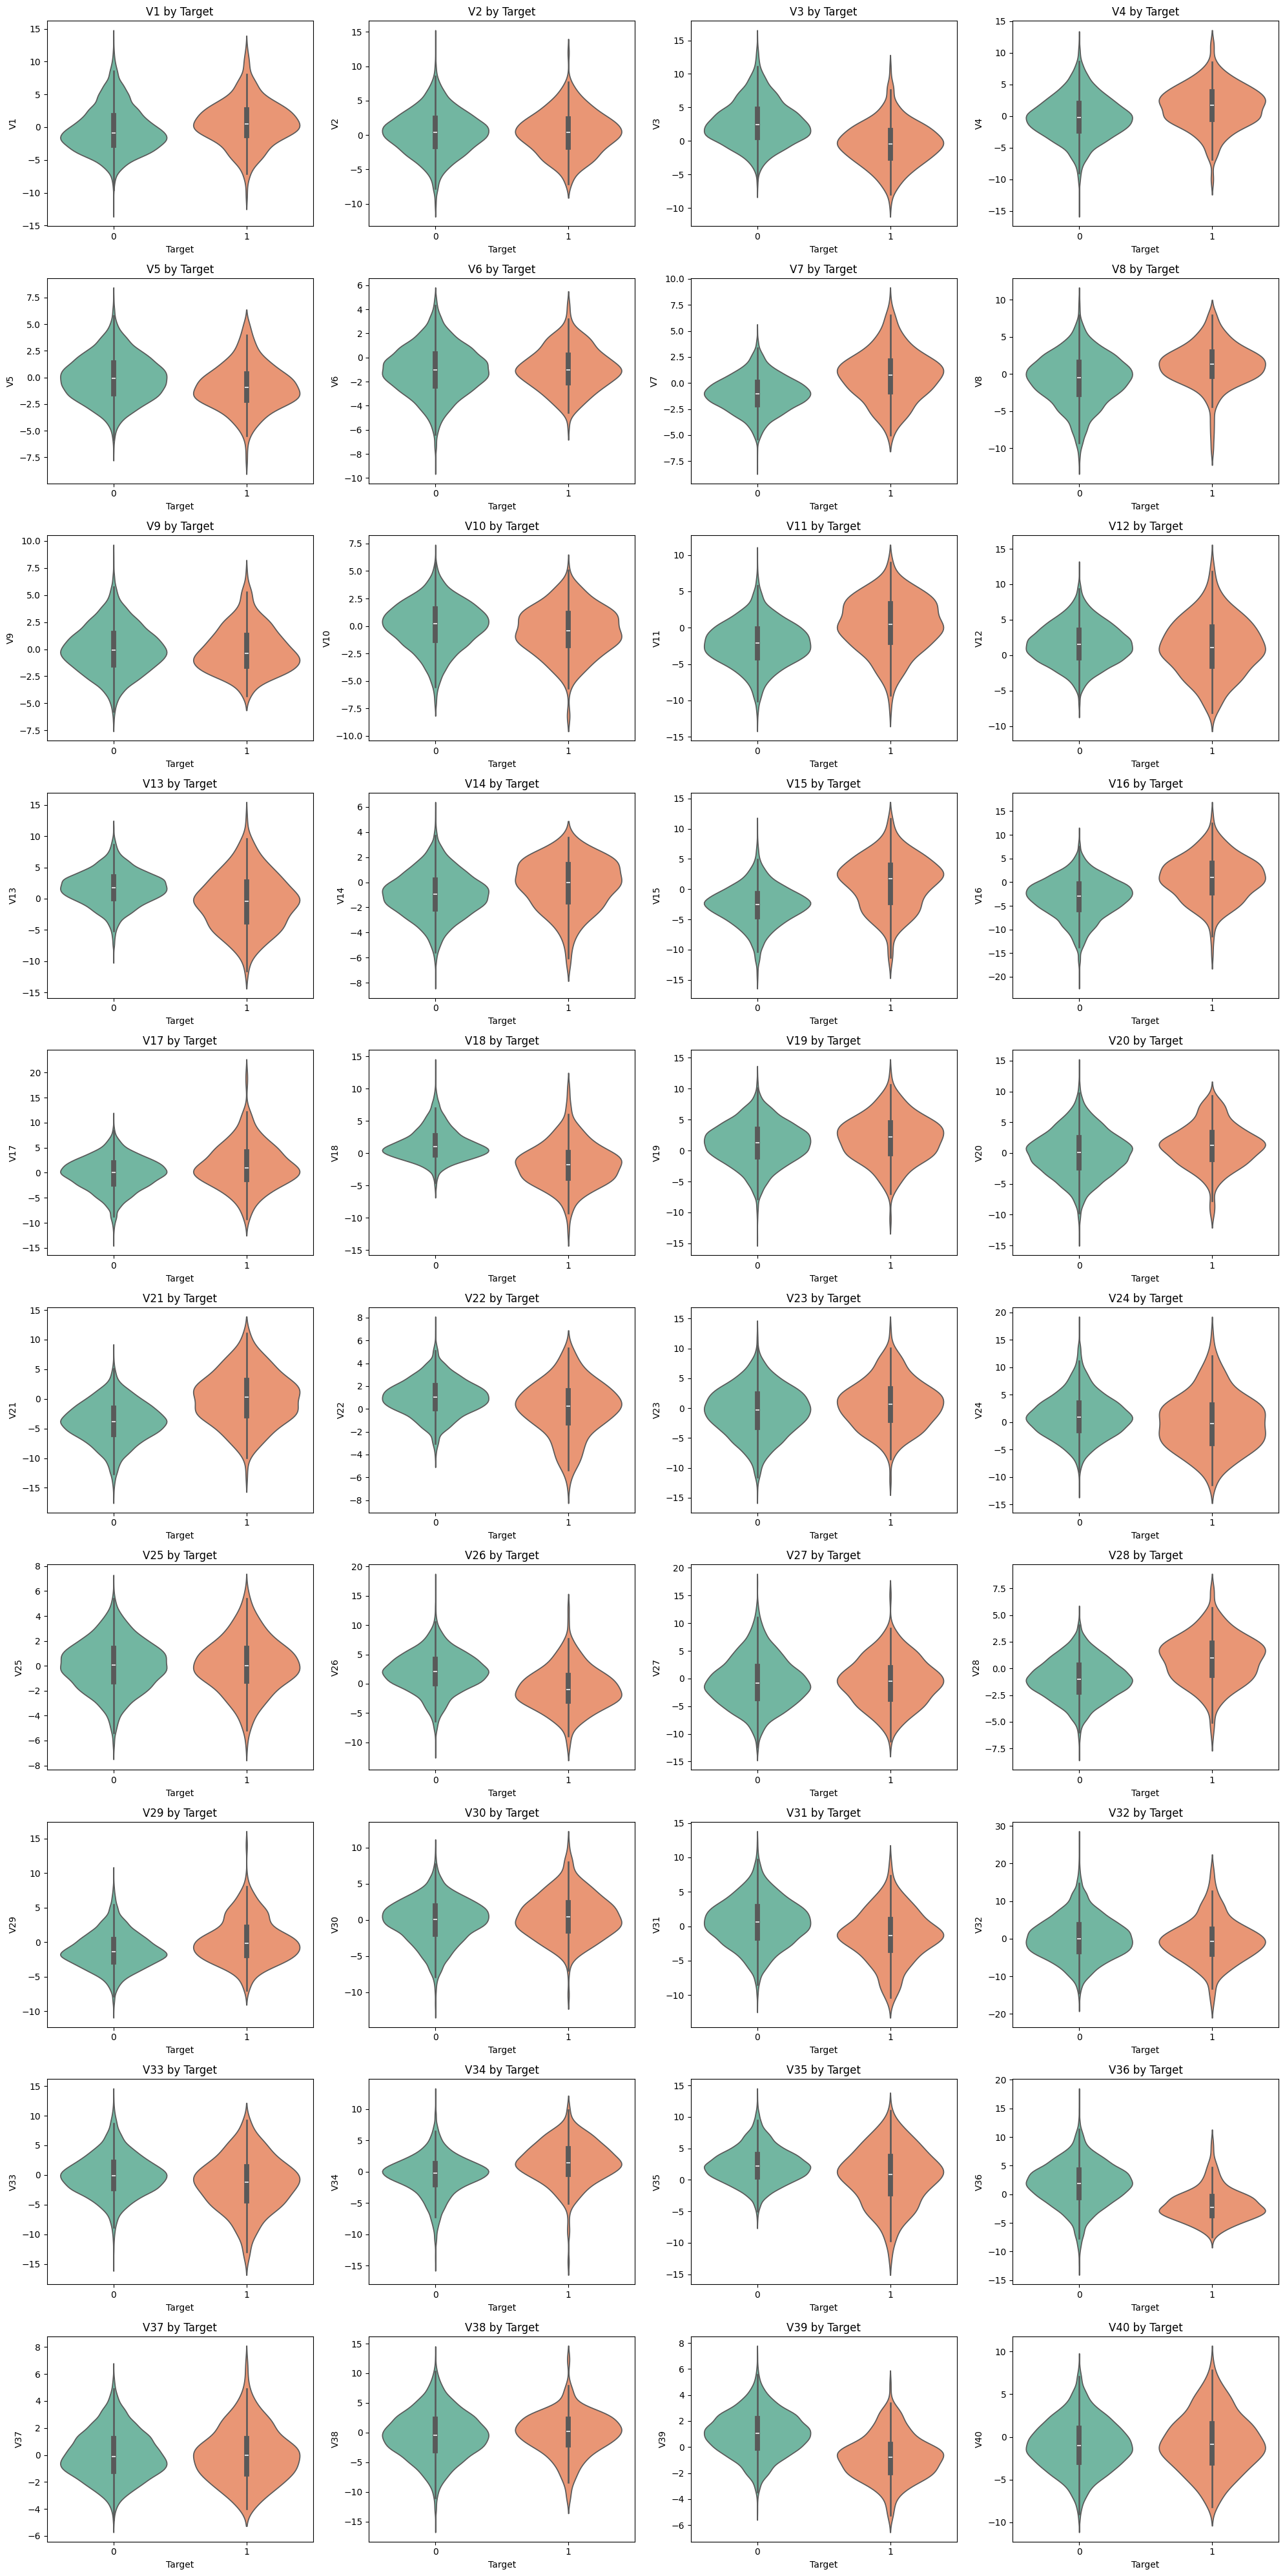

In [26]:
violinplot_by_target(dtest, dtrain.columns[:-1])

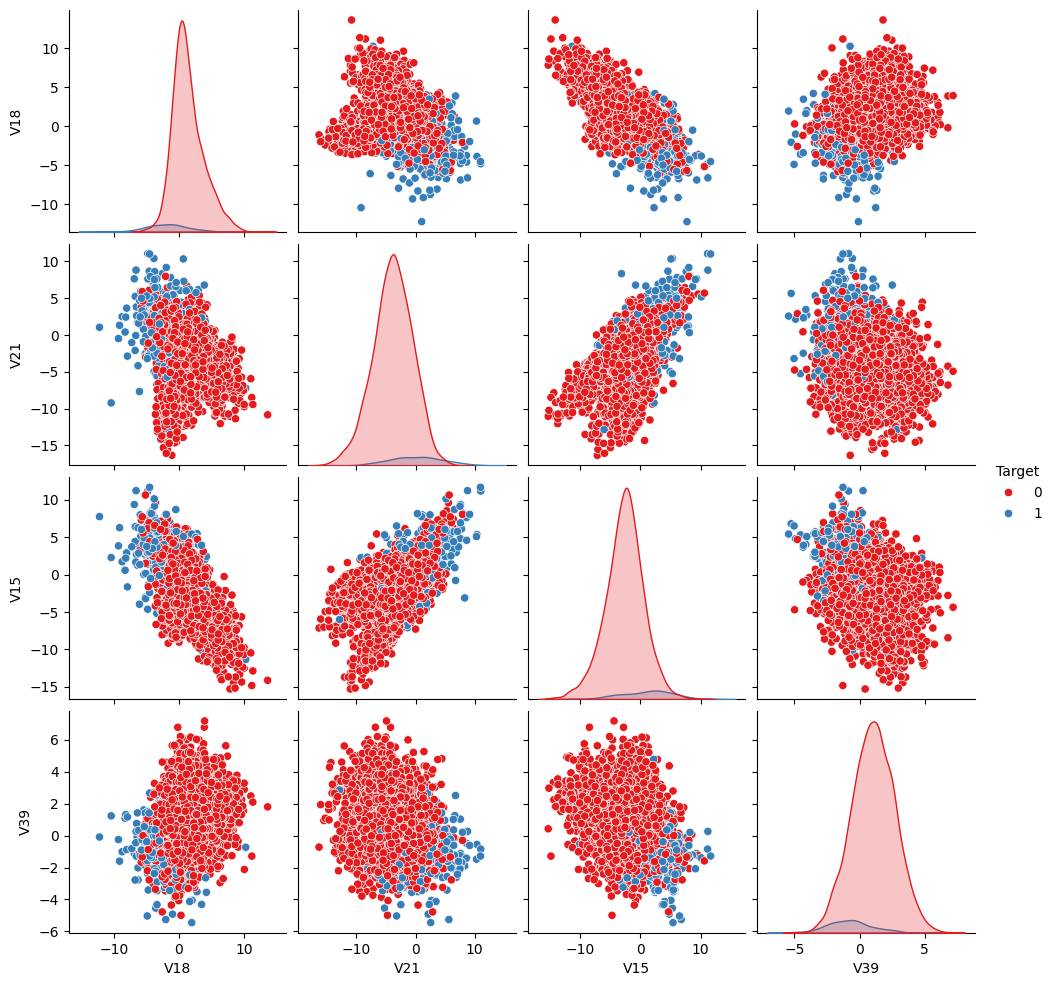

In [28]:
# Top correlated features (absolute value)
corr_with_target = dtest.corr()['Target'].abs().sort_values(ascending=False)
top_features = corr_with_target[1:5].index.tolist()  # Exclude 'target' itself

# Pairplot
sns.pairplot(dtest[top_features + ['Target']], hue='Target', palette='Set1')
plt.show()

- **Test Conclusion**:
  - Feature selection: We now have a sense of which variables contribute more toward predicting the target.
  - Dimensionality reduction: We could filter out features with nearly zero correlation if they’re also uninformative via other techniques (like variance threshold or feature importance from tree models if data and features weren't transformed).
  - Correlations between –0.2 and 0.2 are weak to moderate at best, which is not a major concern for collinearity, especially for neural nets that handle redundant info better than linear models.
  - Pairplot: We visualized the same top correlated features (V18, V21, V15, V39) from the test dataset to compare their bivariate relationships and class separation patterns.
   - As expected, due to prior normalization, the general distribution shapes and inter-feature relationships are preserved between the train and test sets.
    - KDE plots again confirm distinct class-based density regions, even though Target = 1 remains a minority class (~5%). This reinforces the conclusion that these features are informative for classification.
    - V18 and V21 still show inverse correlation, with clusters of positive class (1) values appearing in tighter, distinguishable regions.
    - V15 and V21 exhibit a strong positive linear relationship, consistent with the training set, and class 1 appears slightly more condensed in this interaction.
    - V39, although less correlated, still contributes useful distributional asymmetry between classes.
      - This consistency suggests no feature distribution shift between dtrain and dtest, confirming that the transformation pipeline was applied properly and uniformly.
      - These features remain viable inputs for neural networks, especially given that class-based separation is observable even in high-dimensional space.


## **EDA Conclusions:**


  - The dataset appears to be consistently preprocessed, with both train and test sets undergoing identical transformation methods. No additional preprocessing is currently required.

  - Low-correlation features may be considered for removal to reduce dimensionality and potential noise; however, this decision should be validated through feature importance analysis or model performance impact.

  - A deeper neural network architecture is recommended, as it enables the model to learn meaningful feature interactions and assign internal weights through backpropagation — effectively capturing the predictive signals even from weakly correlated features.

  - Class Imbalance severe in both Training and Testing:
    - 0 ~ 95%
    - 1 ~ 5%

# **Data Preprocessing**

# - **Checkpoint 3**

- **3 Different approaches:**
  - **1:** Fix Threshold, Layers, and Class Weights
  - **2:** Fix Threshold and Class Weights
  - **3:** Fix Architecture, change class Weights and Threshold

- **Assumptions:**
  - **Class weighting** modifies the model’s training process to focus more on minority class (failures), which improves the internal learning of failure patterns.
  - **Threshold tuning** is applied after training and adjusts how probability outputs are interpreted to favor detection of failures.
  - These two techniques are **complementary and should be used together** for imbalanced and cost-sensitive problems.

- **Initial Model Suggestion:**
  - Selected a **Dense Neural Network (MLP)** with two hidden layers (128, 64 neurons) and ReLU activations.
  - Applied **Dropout regularization** to prevent overfitting.
  - Used **sigmoid** output for binary classification to allow **threshold tuning** later.
  - Chose **Adam optimizer** with learning rate 0.001 for stable and adaptive training.
  - Included **Recall**, **Precision**, and **Accuracy** as metrics for monitoring cost-sensitive performance.

- **Consider requesting time stamp:**
  - If the dataset includes time-series records for individual machines or components, the temporal structure could be leveraged using **RNN** architectures (e.g., LSTM/GRU). This would enable the model to learn degradation patterns that unfold over time.

## **Training Restart:**

In [12]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [13]:
dtrain = pd.read_csv('/content/dtrain1.csv')
dtest = pd.read_csv('/content/dtest1.csv')

### - **Define Target:**

In [14]:
X = dtrain.drop(columns=["Target"])
y = dtrain["Target"]

### - **Split Data:**

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### - ***Restarterizer:***

In [161]:
# -- Training Restart & Reproducibility Setup --
tf.keras.utils.set_random_seed(812)  # Sets NumPy, Python, and TF seed
tf.config.experimental.enable_op_determinism()  # Enforces deterministic GPU ops

# -- Load Data --
dtrain = pd.read_csv('/content/dtrain1.csv')
dtest = pd.read_csv('/content/dtest1.csv')

# -- Define Target --
X = dtrain.drop(columns=["Target"])
y = dtrain["Target"]

# -- Split Data --
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

### - **Class Weights:**

In [49]:
# Calculate class weights for imbalanced dataset
cw = (y_train.shape[0]) / np.bincount(y_train)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: np.float64(1.0587612493382743), 1: np.float64(18.01801801801802)}

## **Method 1:**


  - We want to optimize Recall without sacrificing f1_score
  - Data obtained was previously normalized by senders, no data leakage, no scaling previous to this moment.
  - Data Preprocessing: balancing class weights using shape for total rows and binary count
  - **Threshold** = 0.5 * ***Will remain Fixed for Method 1 and 2***
  - **Class Weights** = [ 0:1 , 1:18 ] * ***Will remain Fixed for Method 1 and 2***
    - **m1** : Using initial model (**m1**) building suggested by notebook
   - **m2** : Continue by changing optimizer to Adam (**m2**)
   - **m3** : Continue by using Adam viewing change in Batch Size = 16 (**m3**)
   - **m4** : Continue by using Adam, Batch Size = 64 changing number of neurons =128 (**m4**)

### - **Epochs and Batch Sizes:** (m1-m2)

In [67]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 50
batch_size = 64

### - **Model Building:** (m1)

In [68]:
tf.keras.backend.clear_session()

In [69]:
#Initializing the neural network as suggested, with m1
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

In [70]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
optimizer = tf.keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [72]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, verbose=5)
end=time.time()

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [73]:
print("Time taken in seconds ",end-start)

Time taken in seconds  50.663920640945435


#### - def **Plotting:**

In [9]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

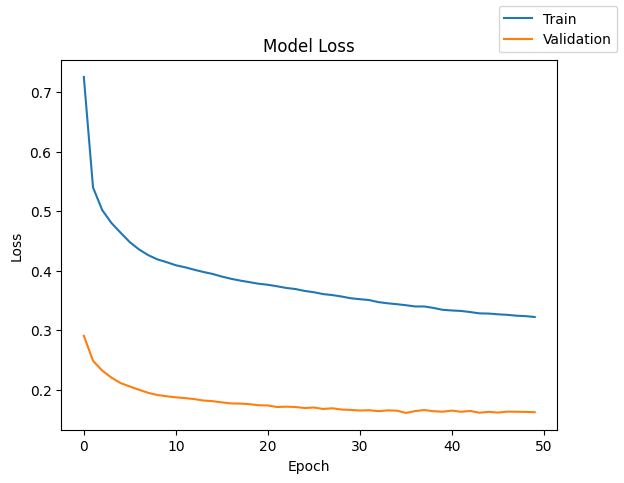

In [74]:
plot(history,'loss')

#### - def **Performance Classification** and **Threshold:**

In [10]:
def model_performance_classification(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) > threshold
    # pred_temp = model.predict(predictors) > threshold
    # # rounding off the above values to get classes
    # pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

In [75]:
m1_train_perf = model_performance_classification(model, X_train, y_train)
m1_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.958063  0.958063   0.972953  0.962724

In [76]:
m1_valid_perf = model_performance_classification(model, X_val, y_val)
m1_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9635  0.9635   0.973967  0.966854

#### - def Manually Calculating the (Savings) - (Costs) = **Net**:

In [11]:
def compute_confusion_economics(y_true, y_pred_probs, threshold=0.5):
    """
    Computes TP, TN, FP, FN for binary classification from predicted probabilities,
    and calculates economic impact based on the company's cost structure.

    Economic Logic:
    - True Positives (TP): Save $500 (prevented $1000 replacement with $500 repair)
    - True Negatives (TN): Save $60 (30% inspection rate × $200 per inspection)
    - False Negatives (FN): Cost $1000 (undetected failure = replacement)
    - False Positives (FP): Cost $500 (unnecessary repair)

    Returns:
    A dictionary with class counts and net economic outcome.
    """

    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    # Masks
    tp_mask = (y_pred == 1) & (y_true == 1)
    tn_mask = (y_pred == 0) & (y_true == 0)
    fn_mask = (y_pred == 0) & (y_true == 1)
    fp_mask = (y_pred == 1) & (y_true == 0)

    # Counts
    tp = np.sum(tp_mask)
    tn = np.sum(tn_mask)
    fn = np.sum(fn_mask)
    fp = np.sum(fp_mask)

    # Economic Parameters
    SAVINGS_PER_TP = 500                   # Prevented replacement
    SAVINGS_PER_TN = 0.3 * 200             # Avoided inspection (30% rate)
    COST_PER_FN = 1000                     # Failure not detected
    COST_PER_FP = 500                      # Unnecessary repair

    # Calculations
    total_savings = (tp * SAVINGS_PER_TP) + (tn * SAVINGS_PER_TN)
    total_costs = (fn * COST_PER_FN) + (fp * COST_PER_FP)
    net_impact = total_savings - total_costs

    return {
        "Net Economic Impact": f"${net_impact:,.2f}",
        "training_time_sec": end - start,
        "False Negatives": f"{fn:,}",
        "False Positives": f"{fp:,}",
        "True Positives": f"{tp:,}",
        "True Negatives": f"{tn:,}",
        "Total Savings": f"${total_savings:,.2f}",
        "Total Costs": f"${total_costs:,.2f}",
    }

In [77]:
y_pred_probs = model.predict(X_val).flatten()
results1 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}


### - **Model Building:** (m2)

In [79]:
tf.keras.backend.clear_session()

In [80]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

In [81]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [83]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5477 - val_loss: 0.2815
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5835 - val_loss: 0.2333
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5224 - val_loss: 0.2065
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4872 - val_loss: 0.1911
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4602 - val_loss: 0.1817
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4422 - val_loss: 0.1756
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4284 - val_loss: 0.1701
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4175 - val_loss: 0.1657
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4091 - val_loss: 0.1636
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4038 - val_loss: 0.1613
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3973 - val_loss: 0.1592
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [84]:
print("Time taken in seconds ",end-start)

Time taken in seconds  63.81275916099548


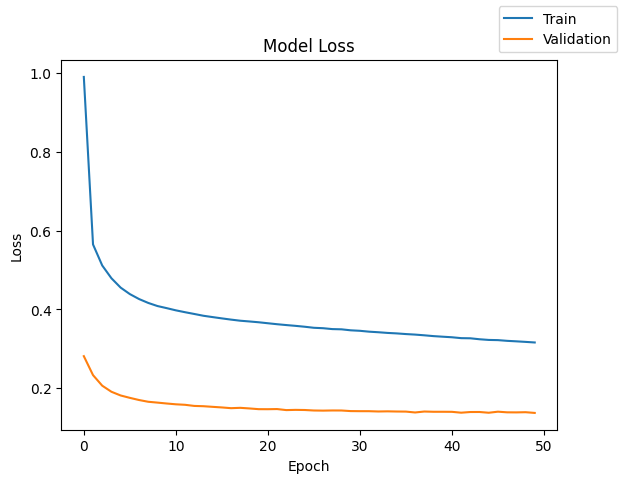

In [85]:
plot(history,'loss')

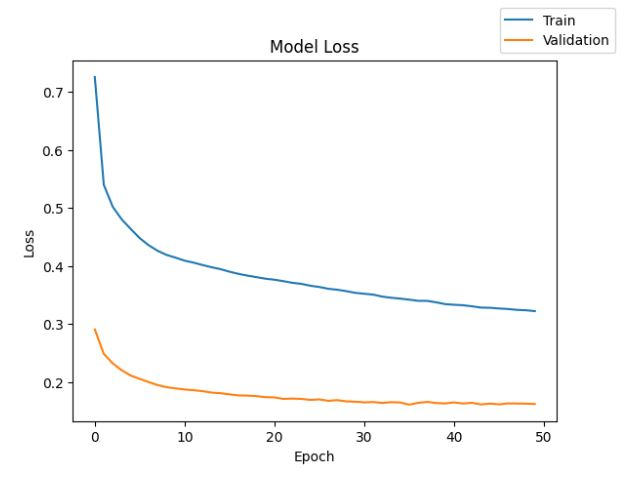

- Slight improvement in the gap between val and train

#### - **Performance Classification:** (m2)

In [86]:
m2_train_perf = model_performance_classification(model, X_train, y_train)
m2_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.969812  0.969812   0.977098  0.972126

In [87]:
m2_valid_perf = model_performance_classification(model, X_val, y_val)
m2_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

In [88]:
m1_valid_perf

Accuracy  Recall  Precision  F1 Score
0    0.9635  0.9635   0.973967  0.966854

#### - **Net Savings:** (m2)

In [89]:
y_pred_probs = model.predict(X_val).flatten()
results2 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results2)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}


In [90]:
print(results1)

{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}


- Increase in both Net Savings and validation performance, continuing with **m2**

### - **Model Building:** (m3)

In [92]:
# Changing Batch Size to view how Loss Graph changes due to this hyperparameter tuning
epochs = 50
batch_size = 16

In [93]:
tf.keras.backend.clear_session()

In [94]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

In [95]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [97]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2114 - val_loss: 0.2724
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5351 - val_loss: 0.2335
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4817 - val_loss: 0.2141
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4543 - val_loss: 0.2037
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4376 - val_loss: 0.1993
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4238 - val_loss: 0.1903
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4131 - val_loss: 0.1882
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4011 - val_loss: 0.1854
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3937 - val_loss: 0.1845
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3872 - val_loss: 0.1812
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3841 - val_loss: 0.1794
Epoch 12/50
1000/1000 ━━━━━━━━

In [98]:
print("Time taken in seconds ",end-start)

Time taken in seconds  220.43154215812683


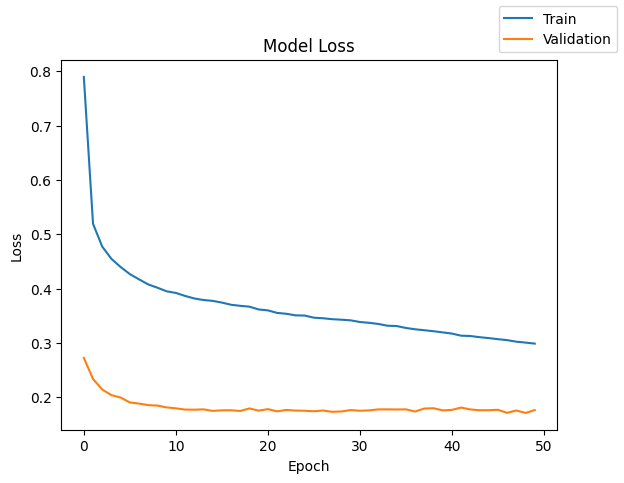

In [99]:
plot(history,'loss')

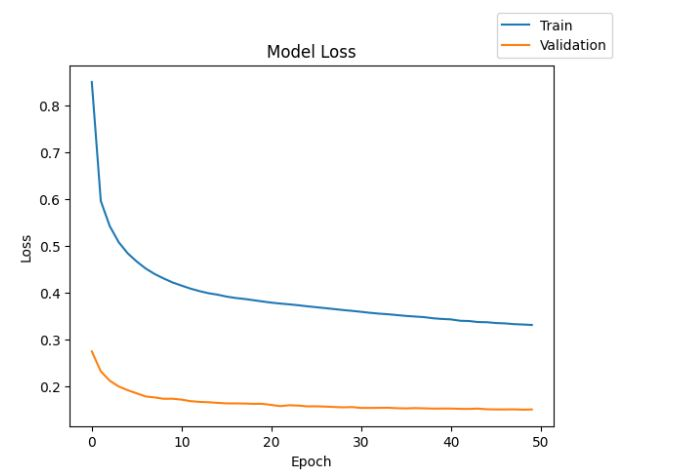

- Model might be starting to overfit in late epochs, consider adding early stop to avoid this
  - Run time huge **mi1**: 227 *sec* vs **m2**: 62 *sec*

#### - **Performance Classification:** (m3)

In [100]:
m3_train_perf = model_performance_classification(model, X_train, y_train)
m3_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.953875  0.953875   0.972021  0.959535

In [101]:
m3_valid_perf = model_performance_classification(model, X_val, y_val)
m3_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9455  0.9455   0.967538  0.952696

In [58]:
m2_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

- No improvement in these parameters, moving back to **m2** settings

#### - **Net Savings:** (m3)

In [102]:
y_pred_probs = model.predict(X_val).flatten()
results3 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results3)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$197,740.00', 'training_time_sec': 220.43154215812683, 'False Negatives': '19', 'False Positives': '199', 'True Positives': '203', 'True Negatives': '3,579', 'Total Savings': '$316,240.00', 'Total Costs': '$118,500.00'}


In [103]:
print(results2)
print(results1)

{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}


- **m2** Will be chosen to move forward

### - **Model Building:** (m4)

In [105]:
epochs = 50
batch_size = 64

In [106]:
tf.keras.backend.clear_session()

In [107]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

In [108]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [110]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8247 - val_loss: 0.2604
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5193 - val_loss: 0.2263
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4681 - val_loss: 0.2114
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4401 - val_loss: 0.2029
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4220 - val_loss: 0.1983
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4078 - val_loss: 0.1945
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3973 - val_loss: 0.1907
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3875 - val_loss: 0.1882
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3799 - val_loss: 0.1870
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3733 - val_loss: 0.1840
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3661 - val_loss: 0.1824
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

In [111]:
print("Time taken in seconds ",end-start)

Time taken in seconds  59.138675689697266


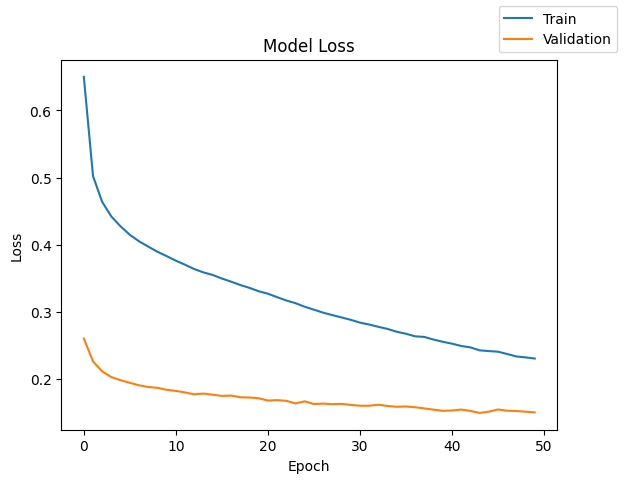

In [112]:
plot(history,'loss')

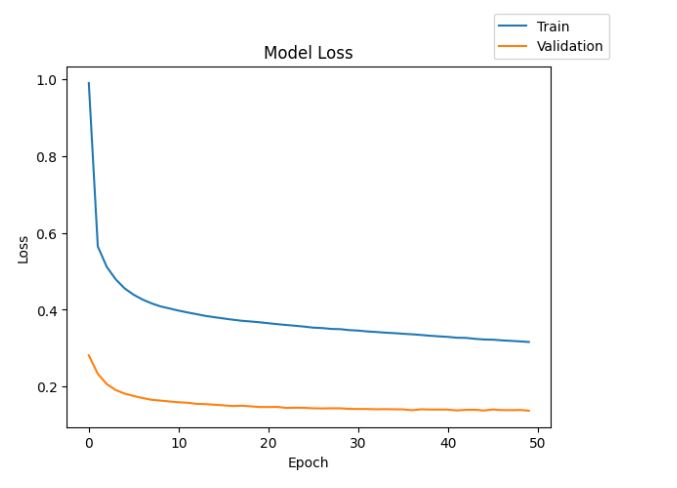

In [113]:
m4_train_perf = model_performance_classification(model, X_train, y_train)
m4_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy   Recall  Precision  F1 Score
0   0.96525  0.96525   0.976586  0.968677

In [114]:
m4_valid_perf = model_performance_classification(model, X_val, y_val)
m4_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy   Recall  Precision  F1 Score
0   0.95425  0.95425   0.970501  0.959486

In [115]:
m2_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

- No improvements, best model yet= **m2**

In [116]:
y_pred_probs = model.predict(X_val).flatten()
results4 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results4)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$218,280.00', 'training_time_sec': 59.138675689697266, 'False Negatives': '18', 'False Positives': '165', 'True Positives': '204', 'True Negatives': '3,613', 'Total Savings': '$318,780.00', 'Total Costs': '$100,500.00'}


In [118]:
print(results2)
print(results1)
print(results3)

{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$197,740.00', 'training_time_sec': 220.43154215812683, 'False Negatives': '19', 'False Positives': '199', 'True Positives': '203', 'True Negatives': '3,579', 'Total Savings': '$316,240.00', 'Total Costs': '$118,500.00'}


- Utilizing **m2** as a base

# - **Checkpoint 4:**

## **Method 2:**


#### - **Models** (m):

  - **m2** has better performance according to loss, **Why?:** It generalizes better (narrower gap), shows no overfitting, and both losses decrease smoothly.
    - Has the best **performance metrics**
    - Has the highest **net savings**
  - The increase in capacity (neurons) did not show improvements.
  - The larger batch size (64) seems to stabilize training and smooth out gradient updates.
  - There is a noticeable reduction in training loss that is continuing through more epochs, so we will be trying out more epochs first:
    - **m5** : Using optimal architecture of model from previous evaluations but increasing Epochs (**m5**)
      - Batch size = 64
      - Neurons = 32
      - Optimizer = Adam
      - **Epochs** = 100
    - **m6** : Using optimal architecture from previous evaluations but including additional Hidden Layer (**m6**)
      - Batch size = 64
      - Neurons1 = 32
      - **Neurons2** = 16
      - Optimizer = Adam
      - Epochs = 50
    - **m7** : Using optimal previous architecture but adding Dropout and Early Stop (**m7**)
      - **Early Stop**
      - Batch size = 64
      - Neurons1 = 32
        - **Dropout** = 40%
      - Optimizer = Adam
      - Epochs = 50

    - **m8** : Using optimal previous architecture but adding a Normalization (**m8**)
      - Early Stop
      - Batch size = 64
      - Neurons1 = 32
        - Dropout = 40%
        - **Normalization**
      - Optimizer = Adam
      - Epochs = 50
    - **m9** : Increasing Dense, Neurons and Dropout (**m9**)
      - Early Stop
      - Batch size = 64
      - **Neurons1** = 128
        - Dropout = 40%
      - **Neurons1** = 64
        - Dropout = 30%
      - Optimizer = Adam
      - Epochs = 50
    - **m10**: Tweak Learning Rate from Adam (**m10**)
      - Early Stop
      - Batch size = 64
      - Neurons1 = 128
        - Dropout = 40%
      - Neurons1 = 64
        - Dropout = 30%
      - Optimizer = Adam
      - Epochs = 50
      - **Learning Rate**= 0.0005
    - **m11**: Trying out a Complex Architecture (**m11**)
      - Early Stop
      - Batch size = 64
      - **Neurons1** = 128
         - Dropout = 40%
      - **Neurons2** = 64
        - Dropout 30%
      - **Neurons3** = 32
        - Dropout 30%
      - Optimizer = Adam
      - Epochs = 50
    - **m12**: Controlling Learning Rate, balancing Dropout  (**m12**)
      - Early Stop
      - Batch size = 64
      - Neurons1 = 128
        - Dropout = 40%
      - Neurons2 = 64
        - Dropout = 30%
      - Neurons3 = 32
        - **Dropout** 20%
      - Optimizer = Adam
      - Epochs = 50
      - **Learning Rate**= 0.0003
      - Patience = 5
    - **m13**: Allowing more epochs for deeper training + increasing Patience (**m13**)
      - Early Stop
      - Batch size = 64
      - **Neurons1** = 128
        - Dropout = 40%
      - **Neurons1** = 64
        - Dropout = 30%
      - Optimizer = Adam
      - Epochs = 50
      - **Epochs** = 100
      - Learning Rate= 0.0003
      - **Patience** = 10


### - **Model Building:** (m5)

In [120]:
epochs = 100
batch_size = 64

In [121]:
tf.keras.backend.clear_session()

In [122]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
])

In [123]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [125]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5477 - val_loss: 0.2815
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5835 - val_loss: 0.2333
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5224 - val_loss: 0.2065
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4872 - val_loss: 0.1911
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4602 - val_loss: 0.1817
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4422 - val_loss: 0.1756
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4284 - val_loss: 0.1701
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4175 - val_loss: 0.1657
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4091 - val_loss: 0.1636
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4038 - val_loss: 0.1613
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3973 - val_loss: 0.1592
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [126]:
print("Time taken in seconds ",end-start)

Time taken in seconds  123.38553786277771


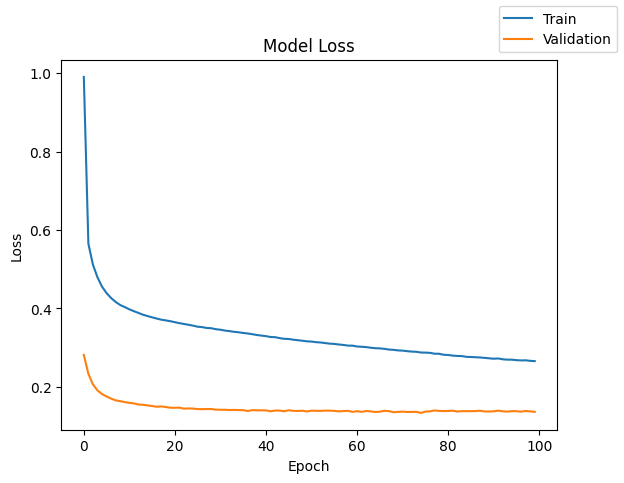

In [127]:
plot(history,'loss')

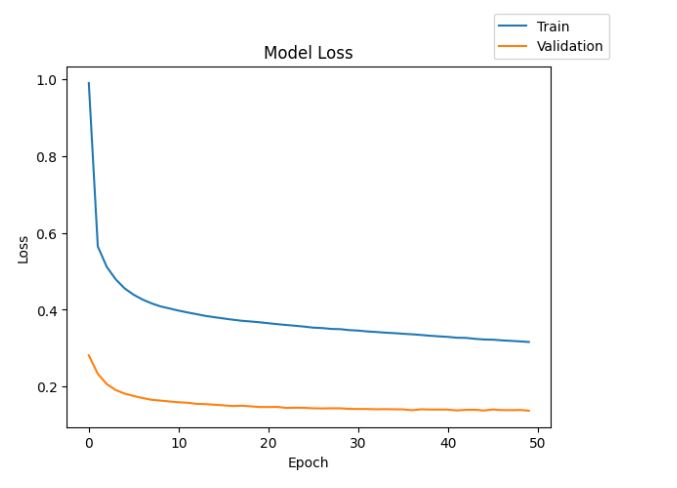

- When permitting additional epochs, the training loss seems to be diminishing
  - But validation plateau is not improved through more epochs
  - there does seem to be a decrease in the gap between validation and training over time, but is this valuable?
    - We shall see through Validation Performance and Net Savings

In [128]:
m5_train_perf = model_performance_classification(model, X_train, y_train)
m5_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy    Recall  Precision  F1 Score
0  0.968688  0.968688   0.977168  0.971318

In [129]:
m5_valid_perf = model_performance_classification(model, X_val, y_val)
m5_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy  Recall  Precision  F1 Score
0     0.962   0.962   0.973133  0.965591

In [130]:
m2_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

In [131]:
y_pred_probs = model.predict(X_val).flatten()
results5 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results5)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
{'Net Economic Impact': '$234,700.00', 'training_time_sec': 123.38553786277771, 'False Negatives': '19', 'False Positives': '133', 'True Positives': '203', 'True Negatives': '3,645', 'Total Savings': '$320,200.00', 'Total Costs': '$85,500.00'}


In [132]:
print(results2)
print(results1)
print(results4)
print(results3)

{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$218,280.00', 'training_time_sec': 59.138675689697266, 'False Negatives': '18', 'False Positives': '165', 'True Positives': '204', 'True Negatives': '3,613', 'Total Savings': '$318,780.00', 'Total Costs': '$100,500.00'}
{'Net Economic Impact': '$197,740.00', 'training_time_sec': 220.43154215812683, 'False Negatives': '19', 'False Positives': '199', 'True Positives': '203', 'True Negatives': '3,579', 'Total Savings': '$316,240.00', 'Total Costs': '$118,500.00'}


  - **Model choosing**:
    - There is a decrease in F1 score
    - There is a decrease Net Savings
    - Computation time increase
      - Continuing with **m2**

### - **Model Building:** (m6)

In [134]:
epochs = 50
batch_size = 64

In [135]:
tf.keras.backend.clear_session()

In [136]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [137]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [139]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9532 - val_loss: 0.2500
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4852 - val_loss: 0.1970
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4234 - val_loss: 0.1755
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3926 - val_loss: 0.1674
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3703 - val_loss: 0.1557
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3516 - val_loss: 0.1501
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3380 - val_loss: 0.1462
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3256 - val_loss: 0.1422
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3149 - val_loss: 0.1395
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3062 - val_loss: 0.1339
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2977 - val_loss: 0.1348
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [140]:
print("Time taken in seconds ",end-start)

Time taken in seconds  66.69106793403625


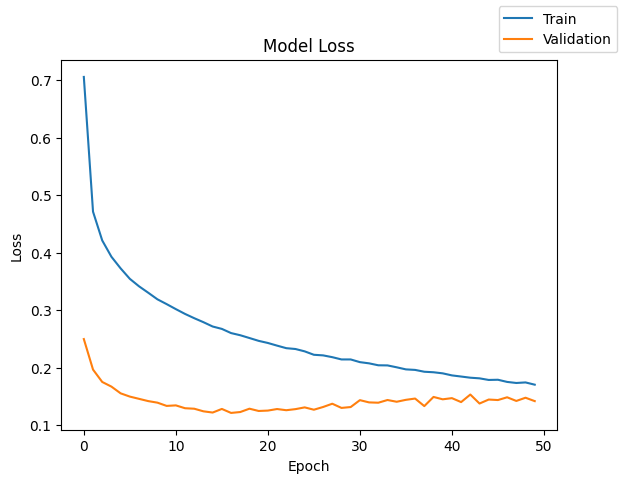

In [141]:
plot(history,'loss')

- m2 Loss below:

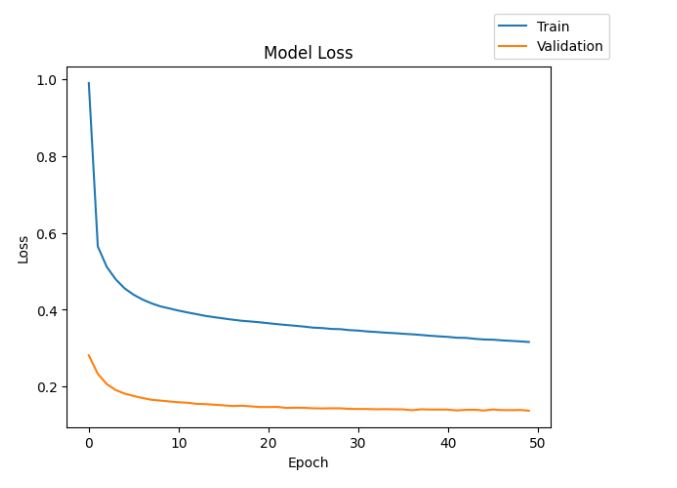

- **Loss Interpretation**:
  - **m2** shows better generalization. The validation loss is both lower and more stable.
  - **m6** is likely too complex. The extra hidden layer may have introduced unnecessary capacity, allowing it to overfit the training data while not improving — or possibly worsening — generalization.

In [142]:
m6_train_perf = model_performance_classification(model, X_train, y_train)
m6_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy    Recall  Precision  F1 Score
0  0.969187  0.969187   0.978566  0.971973

In [143]:
m6_valid_perf = model_performance_classification(model, X_val, y_val)
m6_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0   0.96025  0.96025   0.972666  0.964233

In [144]:
m2_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

In [145]:
y_pred_probs = model.predict(X_val).flatten()
results6 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results6)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$231,720.00', 'training_time_sec': 66.69106793403625, 'False Negatives': '18', 'False Positives': '141', 'True Positives': '204', 'True Negatives': '3,637', 'Total Savings': '$320,220.00', 'Total Costs': '$88,500.00'}


In [146]:
print(results2)
print(results1)
print(results5)
print(results4)
print(results3)

{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$234,700.00', 'training_time_sec': 123.38553786277771, 'False Negatives': '19', 'False Positives': '133', 'True Positives': '203', 'True Negatives': '3,645', 'Total Savings': '$320,200.00', 'Total Costs': '$85,500.00'}
{'Net Economic Impact': '$218,280.00', 'training_time_sec': 59.138675689697266, 'False Negatives': '18', 'False Positives': '165', 'True Positives': '204', 'True Negatives': '3,613', 'Total Savings': '$318,780.00', 'Total Costs': '$100,500.00'}
{'Net Economic Impact': 

- **Model Selection:**
  - **m6**:
    - It outperforms m6 in classification (higher F1, Precision, Recall).

    - It has identical economic utility, so there's no tradeoff.

    - It likely generalizes better given the performance and the loss plot comparison you showed earlier.

    - Less computation time as well

### - **Model Building:** (m7)

In [148]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [149]:
tf.keras.backend.clear_session()

In [150]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),  # Dropout after first dense layer
    Dense(1, activation='sigmoid')
])

In [151]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [153]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=1)
end=time.time()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.5405 - val_loss: 0.2581
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7975 - val_loss: 0.2144
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6317 - val_loss: 0.1973
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6331 - val_loss: 0.1890
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5609 - val_loss: 0.1971
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5502 - val_loss: 0.1888
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5440 - val_loss: 0.1853
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5238 - val_loss: 0.1752
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5083 - val_loss: 0.1825
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5096 - val_loss: 0.1781
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5088 - val_loss: 0.1880
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/s

In [154]:
print("Time taken in seconds ",end-start)

Time taken in seconds  41.614991426467896


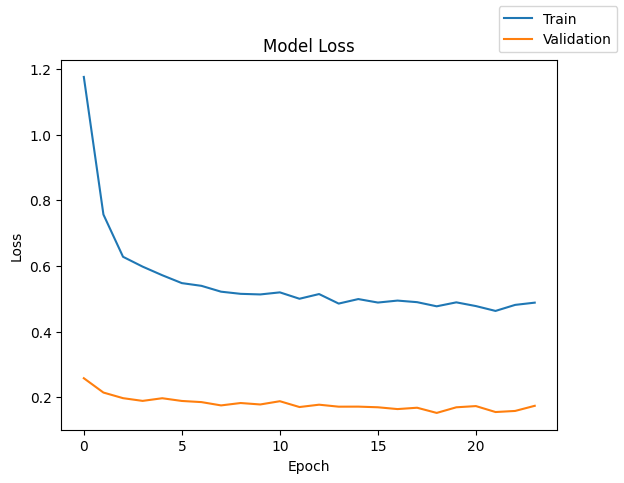

In [155]:
plot(history,'loss')

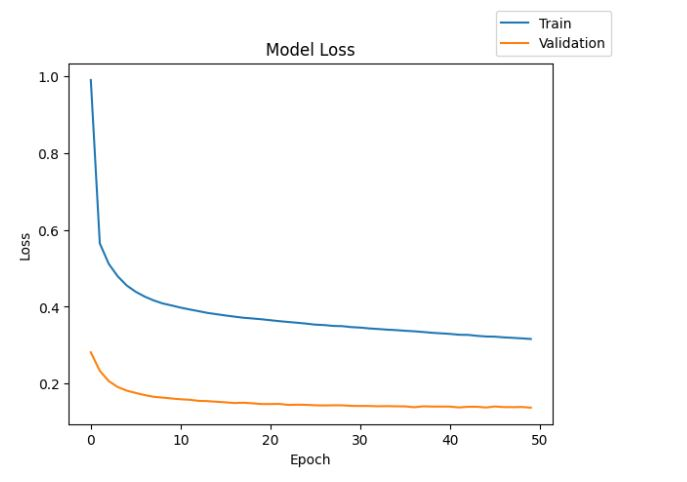

- **Loss Improvements**:
  - There are no erratic spikes in **m7**, nor is there a moment in which there are signals of overfitting, but m2 has a smoother curve
    - No signs of overfitting
    - No signs of noise divergence or erratic jumps
    - Less epochs

In [156]:
m7_train_perf = model_performance_classification(model, X_train, y_train)
m7_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


Accuracy    Recall  Precision  F1 Score
0  0.969437  0.969437   0.975521  0.971487

In [157]:
m7_valid_perf = model_performance_classification(model, X_val, y_val)
m7_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0   0.97375  0.97375   0.978475  0.975312

In [158]:
m2_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.96975  0.96975   0.976776  0.972008

In [159]:
y_pred_probs = model.predict(X_val).flatten()
results7 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results7)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}


In [160]:
print(results2)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$234,700.00', 'training_time_sec': 123.38553786277771, 'False Negatives': '19', 'False Positives': '133', 'True Positives': '203', 'True Negatives': '3,645', 'Total Savings': '$320,200.00', 'Total Costs': '$85,500.00'}
{'Net Economic Impact': '$231,720.00', 'training_time_sec': 66.69106793403625, 'False Negatives': '18', 'False Positives': '141', 'True Positives': '204', 'True Negatives': '3,637', 'Total Savings': '$320,220.00', 'Total Costs': '$88,500.00'}
{'Net Economic Impact': '$

- **Improvements in**:
  - Validation Performance Metrics
  - Economic Net Value
    - At last we are able to best m2
      - Reducing False Positives, but a small increase in False Negatives
      - Increase in f1 score
    - Moving forward with **m7**

### - **Model Building:** (m8)

In [162]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [163]:
tf.keras.backend.clear_session()

In [164]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [165]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 64 (256.00 B)

In [166]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [167]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=2)
end=time.time()

Epoch 1/50
250/250 - 3s - 13ms/step - loss: 0.9857 - val_loss: 0.2951
Epoch 2/50
250/250 - 2s - 7ms/step - loss: 0.6946 - val_loss: 0.2204
Epoch 3/50
250/250 - 1s - 5ms/step - loss: 0.5966 - val_loss: 0.1930
Epoch 4/50
250/250 - 1s - 5ms/step - loss: 0.5852 - val_loss: 0.1795
Epoch 5/50
250/250 - 1s - 4ms/step - loss: 0.5648 - val_loss: 0.1770
Epoch 6/50
250/250 - 1s - 4ms/step - loss: 0.5637 - val_loss: 0.1795
Epoch 7/50
250/250 - 1s - 5ms/step - loss: 0.5371 - val_loss: 0.1673
Epoch 8/50
250/250 - 1s - 6ms/step - loss: 0.5199 - val_loss: 0.1637
Epoch 9/50
250/250 - 1s - 6ms/step - loss: 0.5249 - val_loss: 0.1708
Epoch 10/50
250/250 - 2s - 7ms/step - loss: 0.5228 - val_loss: 0.1645
Epoch 11/50
250/250 - 2s - 7ms/step - loss: 0.5321 - val_loss: 0.1678
Epoch 12/50
250/250 - 1s - 4ms/step - loss: 0.5132 - val_loss: 0.1709
Epoch 13/50
250/250 - 1s - 6ms/step - loss: 0.5237 - val_loss: 0.1749


In [168]:
print("Time taken in seconds ",end-start)

Time taken in seconds  19.958323001861572


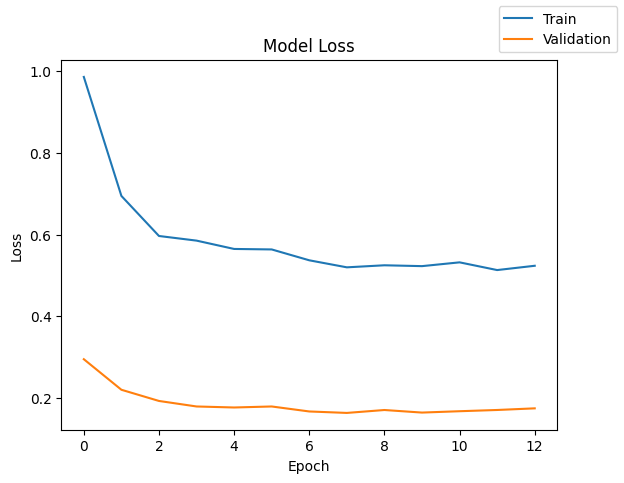

In [169]:
plot(history,'loss')

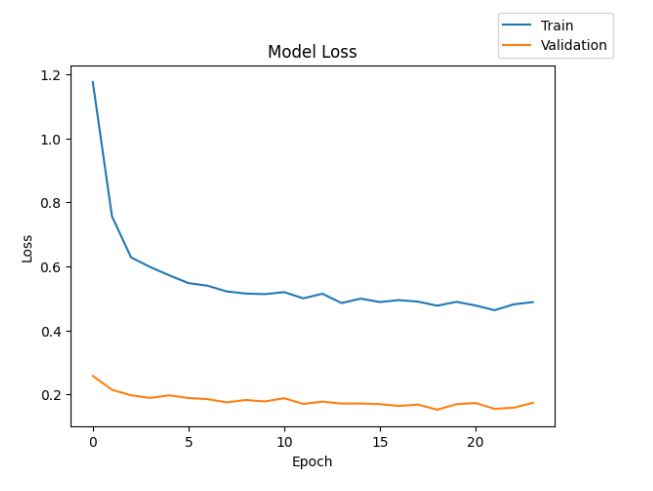

- **Loss Observations**:
  - Unlike m7, where the validation loss appears to slightly flatten or creep up near the end (minor overfitting risk), m8 shows a stable or slightly descending validation loss until the last epoch.

In [170]:
m8_train_perf = model_performance_classification(model, X_train, y_train)
m8_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.965562  0.965562   0.973297  0.968177

In [171]:
m8_valid_perf = model_performance_classification(model, X_val, y_val)
m8_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0   0.96825  0.96825   0.975664  0.970666

In [172]:
m7_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.97375  0.97375   0.978475  0.975312

In [173]:
y_pred_probs = model.predict(X_val).flatten()
results8 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results8)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
{'Net Economic Impact': '$247,760.00', 'training_time_sec': 19.958323001861572, 'False Negatives': '20', 'False Positives': '107', 'True Positives': '202', 'True Negatives': '3,671', 'Total Savings': '$321,260.00', 'Total Costs': '$73,500.00'}


In [174]:
print(results7)
print(results2)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}
{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$234,700.00', 'training_time_sec': 123.38553786277771, 'False Negatives': '19', 'False Positives': '133', 'True Positives': '203', 'True Negatives': '3,645', 'Total Savings': '$320,200.00', 'Total Costs': '$85,500.00'}
{'Net Economic Impact': '$

- **Conclusions of Normalization:**
  - Drop in Validation Precision
  - Drop in Economic Net Value
    - Moving forward with **m7**

### - **Model Building:** (m9)

In [180]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [181]:
tf.keras.backend.clear_session()

In [182]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [183]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
optimizer = tf.keras.optimizers.Adam()  # using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [185]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=1)
end=time.time()

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.7552 - val_loss: 0.3472
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6950 - val_loss: 0.2683
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6027 - val_loss: 0.2177
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5444 - val_loss: 0.2067
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5173 - val_loss: 0.1973
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4793 - val_loss: 0.1674
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4543 - val_loss: 0.1714
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4473 - val_loss: 0.1831
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4443 - val_loss: 0.1692
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4251 - val_loss: 0.1501
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4044 - val_loss: 0.1796
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [186]:
print("Time taken in seconds ",end-start)

Time taken in seconds  39.99464678764343


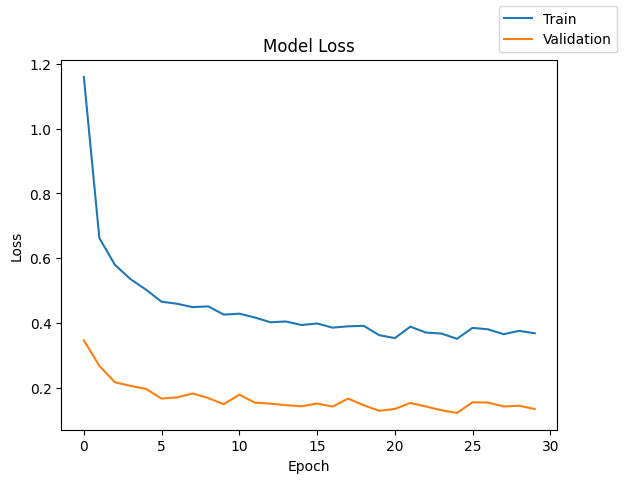

In [187]:
plot(history,'loss')

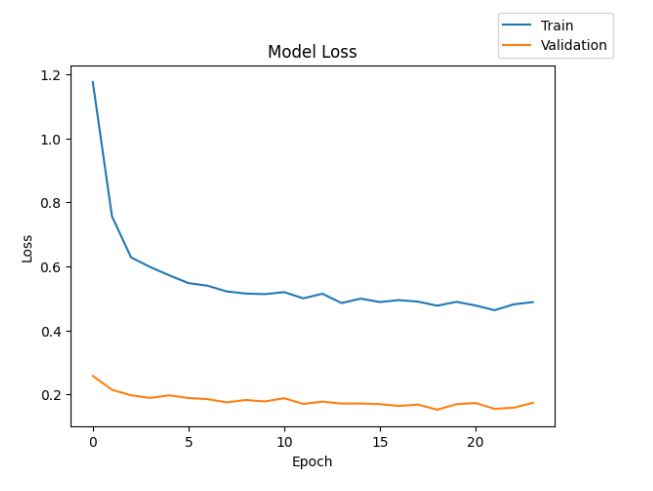

- **Loss Improvements**:
  - There are no erratic spikes in **m9**, nor is there a moment in which there are signals of overfitting
  - Training Loss appears to continue a downards path towards less gap

In [188]:
m9_train_perf = model_performance_classification(model, X_train, y_train)
m9_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.990875  0.990875    0.99083  0.990851

In [189]:
m9_valid_perf = model_performance_classification(model, X_val, y_val)
m9_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075   0.990731   0.99074

In [192]:
m7_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.97375  0.97375   0.978475  0.975312

In [190]:
y_pred_probs = model.predict(X_val).flatten()
results9 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results9)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$299,100.00', 'training_time_sec': 39.99464678764343, 'False Negatives': '19', 'False Positives': '18', 'True Positives': '203', 'True Negatives': '3,760', 'Total Savings': '$327,100.00', 'Total Costs': '$28,000.00'}


In [191]:
print(results7)
print(results2)
print(results8)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}
{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$247,760.00', 'training_time_sec': 19.958323001861572, 'False Negatives': '20', 'False Positives': '107', 'True Positives': '202', 'True Negatives': '3,671', 'Total Savings': '$321,260.00', 'Total Costs': '$73,500.00'}
{'Net Economic Impact': '$239,000.00', 'training_time_sec': 50.663920640945435, 'False Negatives': '18', 'False Positives': '128', 'True Positives': '204', 'True Negatives': '3,650', 'Total Savings': '$321,000.00', 'Total Costs': '$82,000.00'}
{'Net Economic Impact': '$

- **Next Model:**
  - Definitely **m9**

# **Checkpoint 5**

### - **Model Building:** (m10)

In [195]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [196]:
tf.keras.backend.clear_session()

In [197]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),  # Dropout after first dense layer
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [198]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [200]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=4)
end=time.time()

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50


In [201]:
print("Time taken in seconds ",end-start)

Time taken in seconds  31.5425226688385


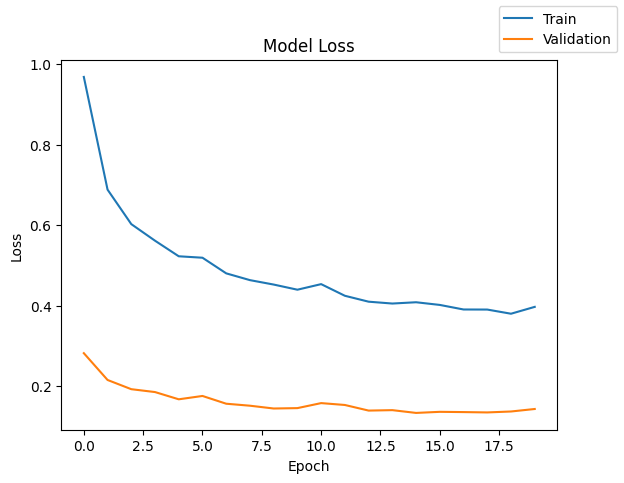

In [202]:
plot(history,'loss')

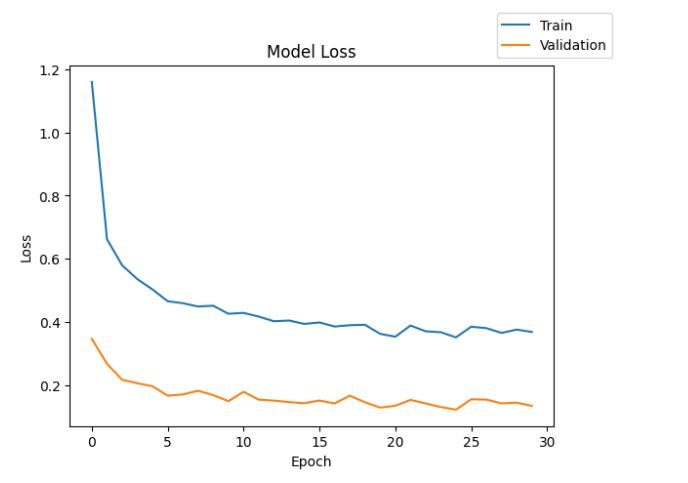

In [203]:
m10_train_perf = model_performance_classification(model, X_train, y_train)
m10_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy    Recall  Precision  F1 Score
0  0.985625  0.985625   0.986287  0.985881

In [204]:
m10_valid_perf = model_performance_classification(model, X_val, y_val)
m10_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9875  0.9875    0.98781  0.987629

In [206]:
m9_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075   0.990731   0.99074

In [207]:
y_pred_probs = model.predict(X_val).flatten()
results10 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results10)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
{'Net Economic Impact': '$290,880.00', 'training_time_sec': 31.5425226688385, 'False Negatives': '20', 'False Positives': '30', 'True Positives': '202', 'True Negatives': '3,748', 'Total Savings': '$325,880.00', 'Total Costs': '$35,000.00'}


In [209]:
print(results9)
print(results7)
print(results2)
print(results8)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$299,100.00', 'training_time_sec': 39.99464678764343, 'False Negatives': '19', 'False Positives': '18', 'True Positives': '203', 'True Negatives': '3,760', 'Total Savings': '$327,100.00', 'Total Costs': '$28,000.00'}
{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}
{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$247,760.00', 'training_time_sec': 19.958323001861572, 'False Negatives': '20', 'False Positives': '107', 'True Positives': '202', 'True Negatives': '3,671', 'Total Savings': '$321,260.00', 'Total Costs': '$73,500.00'}
{'Net Economic Impact': '$23

- **Best Model yet:**
  - **m9** continues to overperform the other models so avoid learning rate for now

### - **Model Building:** (m11)

In [211]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [212]:
tf.keras.backend.clear_session()

In [213]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [214]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

In [215]:
optimizer = tf.keras.optimizers.Adam()  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [216]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=4)
end=time.time()

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50


In [217]:
print("Time taken in seconds ",end-start)

Time taken in seconds  43.32077765464783


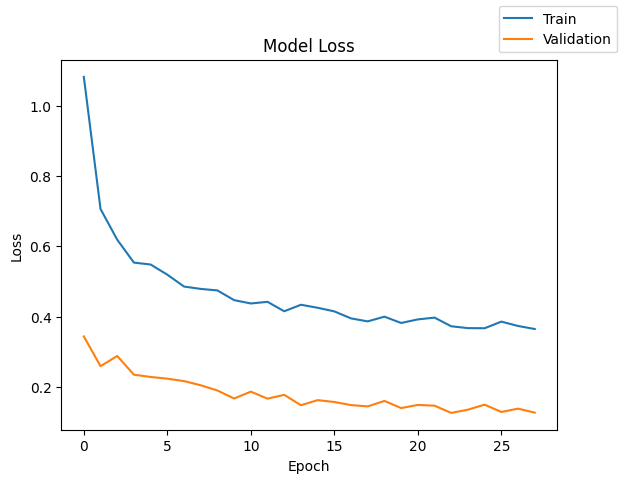

In [218]:
plot(history,'loss')

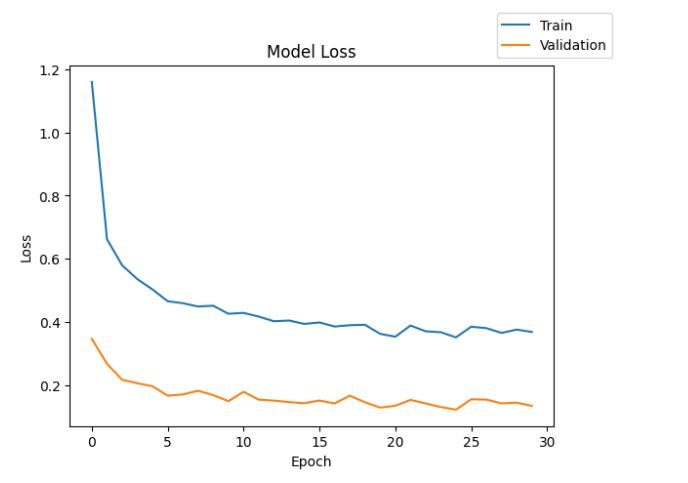

In [219]:
m11_train_perf = model_performance_classification(model, X_train, y_train)
m11_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.989563  0.989563   0.989627  0.989593

In [220]:
m11_valid_perf = model_performance_classification(model, X_val, y_val)
m11_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Accuracy  Recall  Precision  F1 Score
0     0.988   0.988   0.988109   0.98805

In [221]:
m9_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075   0.990731   0.99074

In [222]:
y_pred_probs = model.predict(X_val).flatten()
results11 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results11)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$290,120.00', 'training_time_sec': 43.32077765464783, 'False Negatives': '22', 'False Positives': '26', 'True Positives': '200', 'True Negatives': '3,752', 'Total Savings': '$325,120.00', 'Total Costs': '$35,000.00'}


In [224]:
print(results9)
print(results10)
print(results7)
print(results2)
print(results8)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$299,100.00', 'training_time_sec': 39.99464678764343, 'False Negatives': '19', 'False Positives': '18', 'True Positives': '203', 'True Negatives': '3,760', 'Total Savings': '$327,100.00', 'Total Costs': '$28,000.00'}
{'Net Economic Impact': '$290,880.00', 'training_time_sec': 31.5425226688385, 'False Negatives': '20', 'False Positives': '30', 'True Positives': '202', 'True Negatives': '3,748', 'Total Savings': '$325,880.00', 'Total Costs': '$35,000.00'}
{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}
{'Net Economic Impact': '$253,000.00', 'training_time_sec': 63.81275916099548, 'False Negatives': '18', 'False Positives': '103', 'True Positives': '204', 'True Negatives': '3,675', 'Total Savings': '$322,500.00', 'Total Costs': '$69,500.00'}
{'Net Economic Impact': '$247,7

- **Best Model yet:**
  - **m9** continues to have the best performance yet with a faster training time

### - **Model Building:** (m12)

In [247]:
epochs = 50
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [248]:
tf.keras.backend.clear_session()

In [249]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [250]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

In [251]:
optimizer = tf.keras.optimizers.Adam(0.0003)  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [252]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=4)
end=time.time()

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50


In [253]:
print("Time taken in seconds ",end-start)

Time taken in seconds  36.17595458030701


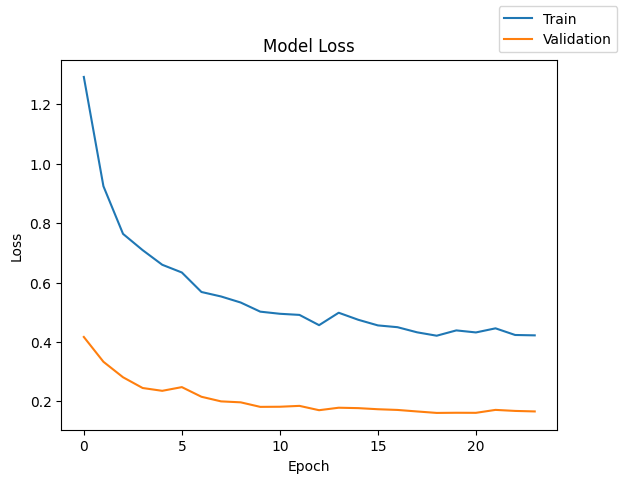

In [254]:
plot(history,'loss')

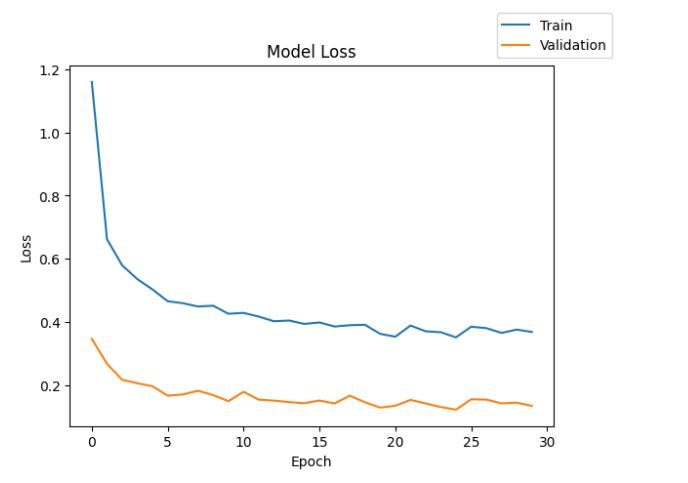

In [255]:
m12_train_perf = model_performance_classification(model, X_train, y_train)
m12_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy  Recall  Precision  F1 Score
0     0.985   0.985   0.985683  0.985267

In [256]:
m12_valid_perf = model_performance_classification(model, X_val, y_val)
m12_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy  Recall  Precision  F1 Score
0     0.987   0.987   0.987472  0.987187

In [257]:
m9_valid_perf

Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075   0.990731   0.99074

In [258]:
y_pred_probs = model.predict(X_val).flatten()
results12 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results12)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$290,700.00', 'training_time_sec': 36.17595458030701, 'False Negatives': '19', 'False Positives': '33', 'True Positives': '203', 'True Negatives': '3,745', 'Total Savings': '$326,200.00', 'Total Costs': '$35,500.00'}


In [244]:
print(results9)
print(results10)
print(results11)
print(results7)
print(results2)
print(results8)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$299,100.00', 'training_time_sec': 39.99464678764343, 'False Negatives': '19', 'False Positives': '18', 'True Positives': '203', 'True Negatives': '3,760', 'Total Savings': '$327,100.00', 'Total Costs': '$28,000.00'}
{'Net Economic Impact': '$290,880.00', 'training_time_sec': 31.5425226688385, 'False Negatives': '20', 'False Positives': '30', 'True Positives': '202', 'True Negatives': '3,748', 'Total Savings': '$325,880.00', 'Total Costs': '$35,000.00'}
{'Net Economic Impact': '$290,120.00', 'training_time_sec': 43.32077765464783, 'False Negatives': '22', 'False Positives': '26', 'True Positives': '200', 'True Negatives': '3,752', 'Total Savings': '$325,120.00', 'Total Costs': '$35,000.00'}
{'Net Economic Impact': '$260,080.00', 'training_time_sec': 41.614991426467896, 'False Negatives': '20', 'False Positives': '85', 'True Positives': '202', 'True Negatives': '3,693', 'Total Savings': '$322,580.00', 'Total Costs': '$62,500.00'}
{'Net Economic Impact': '$253,00

- **Best Model yet:**
  - As observed, changing the learning rate to 0.0003 made an improvement from m11
    - Evaluation metrics seem to have reached a top alongside Economic value
    - Moving forward with **m12**
    - Will play around with methods to reduce gap between validatin and training loss

### - **Model Building:** (m13)

In [59]:
# Calculate class weights for imbalanced dataset
cw = (y_train.shape[0]) / np.bincount(y_train)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: np.float64(1.0587612493382743), 1: np.float64(18.01801801801802)}

In [60]:
epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
tf.keras.backend.clear_session()

In [62]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
optimizer = tf.keras.optimizers.Adam()  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [65]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=2)
end=time.time()

Epoch 1/100
250/250 - 2s - 9ms/step - loss: 0.8641 - val_loss: 0.2793
Epoch 2/100
250/250 - 1s - 5ms/step - loss: 0.6082 - val_loss: 0.2306
Epoch 3/100
250/250 - 1s - 3ms/step - loss: 0.5370 - val_loss: 0.1949
Epoch 4/100
250/250 - 1s - 6ms/step - loss: 0.5099 - val_loss: 0.1803
Epoch 5/100
250/250 - 2s - 8ms/step - loss: 0.4716 - val_loss: 0.1638
Epoch 6/100
250/250 - 2s - 7ms/step - loss: 0.4753 - val_loss: 0.1817
Epoch 7/100
250/250 - 1s - 3ms/step - loss: 0.4365 - val_loss: 0.1703
Epoch 8/100
250/250 - 1s - 6ms/step - loss: 0.4284 - val_loss: 0.1498
Epoch 9/100
250/250 - 1s - 4ms/step - loss: 0.4295 - val_loss: 0.1538
Epoch 10/100
250/250 - 1s - 4ms/step - loss: 0.4122 - val_loss: 0.1411
Epoch 11/100
250/250 - 1s - 5ms/step - loss: 0.4184 - val_loss: 0.1600
Epoch 12/100
250/250 - 1s - 5ms/step - loss: 0.3967 - val_loss: 0.1427
Epoch 13/100
250/250 - 1s - 3ms/step - loss: 0.3984 - val_loss: 0.1499
Epoch 14/100
250/250 - 1s - 4ms/step - loss: 0.3878 - val_loss: 0.1411
Epoch 15/100
25

In [66]:
print("Time taken in seconds ",end-start)

Time taken in seconds  48.752161741256714


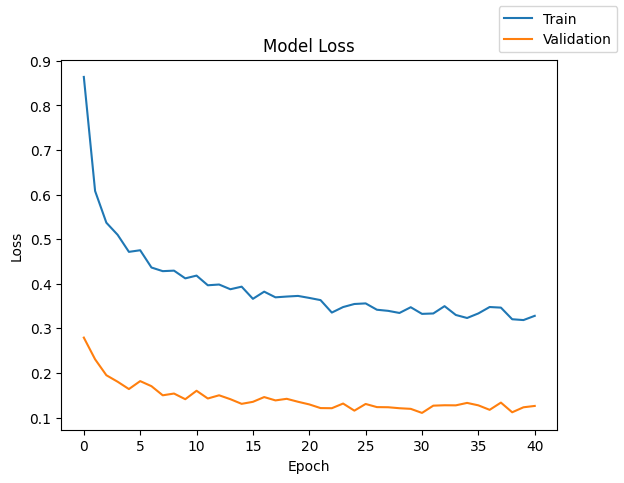

In [67]:
plot(history,'loss')

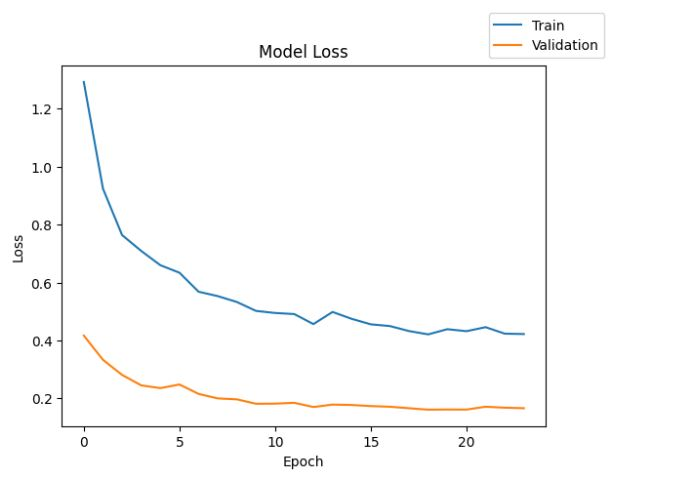

In [68]:
m13_train_perf = model_performance_classification(model, X_train, y_train)
m13_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.991375  0.991375   0.991325  0.991347

In [47]:
m13_valid_perf = model_performance_classification(model, X_val, y_val)
m13_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075    0.99077   0.99076

In [69]:
y_pred_probs = model.predict(X_val).flatten()
results13 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results13)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$300,040.00', 'training_time_sec': 48.752161741256714, 'False Negatives': '18', 'False Positives': '19', 'True Positives': '204', 'True Negatives': '3,759', 'Total Savings': '$327,540.00', 'Total Costs': '$27,500.00'}


In [70]:
model.save("m13.keras")

In [275]:
print(results9)
print(results10)
print(results12)
print(results11)
print(results7)
print(results2)
print(results8)
print(results1)
print(results5)
print(results6)
print(results4)
print(results3)

{'Net Economic Impact': '$299,100.00', 'training_time_sec': 39.99464678764343, 'False Negatives': '19', 'False Positives': '18', 'True Positives': '203', 'True Negatives': '3,760', 'Total Savings': '$327,100.00', 'Total Costs': '$28,000.00'}
{'Net Economic Impact': '$290,880.00', 'training_time_sec': 31.5425226688385, 'False Negatives': '20', 'False Positives': '30', 'True Positives': '202', 'True Negatives': '3,748', 'Total Savings': '$325,880.00', 'Total Costs': '$35,000.00'}
{'Net Economic Impact': '$290,700.00', 'training_time_sec': 36.17595458030701, 'False Negatives': '19', 'False Positives': '33', 'True Positives': '203', 'True Negatives': '3,745', 'Total Savings': '$326,200.00', 'Total Costs': '$35,500.00'}
{'Net Economic Impact': '$290,120.00', 'training_time_sec': 43.32077765464783, 'False Negatives': '22', 'False Positives': '26', 'True Positives': '200', 'True Negatives': '3,752', 'Total Savings': '$325,120.00', 'Total Costs': '$35,000.00'}
{'Net Economic Impact': '$260,080

- **Best Model yet:**
  - Most definitely **m13** has not-so significant improvements compare to m9
    - Increase in Training Time though

# **Checkpoint 6**

# **Model Performance Comparison and Final Architecture Selection**

### - **Validation Metrics:**

In [276]:
models_valid_comp_df = pd.concat(
    [
        m1_valid_perf.T,
        m2_valid_perf.T,
        m3_valid_perf.T,
        m4_valid_perf.T,
        m5_valid_perf.T,
        m6_valid_perf.T,
        m7_valid_perf.T,
        m8_valid_perf.T,
        m9_valid_perf.T,
        m10_valid_perf.T,
        m11_valid_perf.T,
        m12_valid_perf.T,
        m13_valid_perf.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "m1",
    "m2",
    "m3",
    "m4",
    "m5",
    "m6",
    "m7",
    "m8",
    "m9",
    "m10",
    "m11",
    "m12",
    "m13"
]

In [277]:
models_valid_comp_df

m1        m2        m3        m4        m5        m6  \
Accuracy   0.963500  0.969750  0.945500  0.954250  0.962000  0.960250   
Recall     0.963500  0.969750  0.945500  0.954250  0.962000  0.960250   
Precision  0.973967  0.976776  0.967538  0.970501  0.973133  0.972666   
F1 Score   0.966854  0.972008  0.952696  0.959486  0.965591  0.964233   

                 m7        m8        m9       m10       m11       m12      m13  
Accuracy   0.973750  0.968250  0.990750  0.987500  0.988000  0.987000  0.99075  
Recall     0.973750  0.968250  0.990750  0.987500  0.988000  0.987000  0.99075  
Precision  0.978475  0.975664  0.990731  0.987810  0.988109  0.987472  0.99077  
F1 Score   0.975312  0.970666  0.990740  0.987629  0.988050  0.987187  0.99076

#### - According to **Recall**:
  - **m9 & m13** models

In [278]:
models_valid_comp_df_sorted_Recall = models_valid_comp_df.sort_values(by="Recall", axis=1, ascending=False)

In [279]:
models_valid_comp_df_sorted_Recall

m9      m13       m11       m10       m12        m7  \
Accuracy   0.990750  0.99075  0.988000  0.987500  0.987000  0.973750   
Recall     0.990750  0.99075  0.988000  0.987500  0.987000  0.973750   
Precision  0.990731  0.99077  0.988109  0.987810  0.987472  0.978475   
F1 Score   0.990740  0.99076  0.988050  0.987629  0.987187  0.975312   

                 m2        m8        m1        m5        m6        m4  \
Accuracy   0.969750  0.968250  0.963500  0.962000  0.960250  0.954250   
Recall     0.969750  0.968250  0.963500  0.962000  0.960250  0.954250   
Precision  0.976776  0.975664  0.973967  0.973133  0.972666  0.970501   
F1 Score   0.972008  0.970666  0.966854  0.965591  0.964233  0.959486   

                 m3  
Accuracy   0.945500  
Recall     0.945500  
Precision  0.967538  
F1 Score   0.952696

  - **Recall** is related to the most expensive outcome: **False Negatives**
    - This would represent a missed repair that ended up in a replacement -1000

#### - Accoring to **F1**:
  - **m9 & m13** model

In [280]:
models_valid_comp_df_sorted_f1 = models_valid_comp_df.sort_values(by="F1 Score", axis=1, ascending=False)

In [281]:
models_valid_comp_df_sorted_f1

m13        m9       m11       m10       m12        m7  \
Accuracy   0.99075  0.990750  0.988000  0.987500  0.987000  0.973750   
Recall     0.99075  0.990750  0.988000  0.987500  0.987000  0.973750   
Precision  0.99077  0.990731  0.988109  0.987810  0.987472  0.978475   
F1 Score   0.99076  0.990740  0.988050  0.987629  0.987187  0.975312   

                 m2        m8        m1        m5        m6        m4  \
Accuracy   0.969750  0.968250  0.963500  0.962000  0.960250  0.954250   
Recall     0.969750  0.968250  0.963500  0.962000  0.960250  0.954250   
Precision  0.976776  0.975664  0.973967  0.973133  0.972666  0.970501   
F1 Score   0.972008  0.970666  0.966854  0.965591  0.964233  0.959486   

                 m3  
Accuracy   0.945500  
Recall     0.945500  
Precision  0.967538  
F1 Score   0.952696

  - F1 is the balance between **FN** and **FP**
    - It considers all unnecessary repairs as a cost -500
    - Also considers replacements due to non detected repairs -1000

### - Reviewing Assumed **Economic Value**:

In [283]:

# Gather all results in a list
all_results = [results1, results2, results3, results4, results5,
               results6, results7, results8, results9, results10, results11, results12, results13]

# Convert list of dicts to DataFrame
economic_comparison_df = pd.DataFrame(all_results)

# Add model identifiers (assuming order corresponds to m1, m2, ..., m10)
economic_comparison_df.index = [f"m{i}" for i in range(1, 14)]

# Optional: Move index to a column
economic_comparison_df.reset_index(inplace=True)
economic_comparison_df.rename(columns={'index': 'Model'}, inplace=True)



In [284]:
display(economic_comparison_df)

Model Net Economic Impact  training_time_sec False Negatives  \
0     m1         $239,000.00          50.663921              18   
1     m2         $253,000.00          63.812759              18   
2     m3         $197,740.00         220.431542              19   
3     m4         $218,280.00          59.138676              18   
4     m5         $234,700.00         123.385538              19   
5     m6         $231,720.00          66.691068              18   
6     m7         $260,080.00          41.614991              20   
7     m8         $247,760.00          19.958323              20   
8     m9         $299,100.00          39.994647              19   
9    m10         $290,880.00          31.542523              20   
10   m11         $290,120.00          43.320778              22   
11   m12         $290,700.00          36.175955              19   
12   m13         $300,040.00          51.205192              18   

   False Positives True Positives True Negatives Total Savings  Total Costs  
0              128            204          3,650   $321,000.00   $82,000.00  
1              103            204          3,675   $322,500.00   $69,500.00  
2              199            203          3,579   $316,240.00  $118,500.00  
3              165            204          3,613   $318,780.00  $100,500.00  
4              133            203          3,645   $320,200.00   $85,500.00  
5              141            204          3,637   $320,220.00   $88,500.00  
6               85            202          3,693   $322,580.00   $62,500.00  
7              107            202          3,671   $321,260.00   $73,500.00  
8               18            203          3,760   $327,100.00   $28,000.00  
9               30            202          3,748   $325,880.00   $35,000.00  
10              26            200          3,752   $325,120.00   $35,000.00  
11              33            203          3,745   $326,200.00   $35,500.00  
12              19            204          3,759   $327,540.00   $27,500.00

In [285]:
# Step 1: Convert list of dictionaries to DataFrame
all_results = [results1, results2, results3, results4, results5,
               results6, results7, results8, results9, results10, results11, results12, results13]

economic_comparison_df = pd.DataFrame(all_results)

# Step 2: Add model labels as a new column (no index)
economic_comparison_df.insert(0, "Model", [f"m{i}" for i in range(1, 14)])

# Step 3: Convert Net Economic Impact to float for sorting
economic_comparison_df["Net Economic Impact Float"] = (
    economic_comparison_df["Net Economic Impact"]
    .replace('[\$,]', '', regex=True).astype(float)
)

# Step 4: Sort by Net Economic Impact (descending)
economic_comparison_df_sorted = economic_comparison_df.sort_values(
    by="Net Economic Impact Float", ascending=False
).drop(columns="Net Economic Impact Float")

# Step 5: Reformat monetary columns with "$" and comma formatting
monetary_cols = ["Total Savings", "Total Costs", "Net Economic Impact"]
for col in monetary_cols:
    economic_comparison_df_sorted[col] = (
        economic_comparison_df_sorted[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
        .apply(lambda x: f"${x:,.2f}")
    )



In [286]:
# Step 6: Display the cleaned DataFrame
display(economic_comparison_df_sorted.reset_index(drop=True))

Model Net Economic Impact  training_time_sec False Negatives  \
0    m13         $300,040.00          51.205192              18   
1     m9         $299,100.00          39.994647              19   
2    m10         $290,880.00          31.542523              20   
3    m12         $290,700.00          36.175955              19   
4    m11         $290,120.00          43.320778              22   
5     m7         $260,080.00          41.614991              20   
6     m2         $253,000.00          63.812759              18   
7     m8         $247,760.00          19.958323              20   
8     m1         $239,000.00          50.663921              18   
9     m5         $234,700.00         123.385538              19   
10    m6         $231,720.00          66.691068              18   
11    m4         $218,280.00          59.138676              18   
12    m3         $197,740.00         220.431542              19   

   False Positives True Positives True Negatives Total Savings  Total Costs  
0               19            204          3,759   $327,540.00   $27,500.00  
1               18            203          3,760   $327,100.00   $28,000.00  
2               30            202          3,748   $325,880.00   $35,000.00  
3               33            203          3,745   $326,200.00   $35,500.00  
4               26            200          3,752   $325,120.00   $35,000.00  
5               85            202          3,693   $322,580.00   $62,500.00  
6              103            204          3,675   $322,500.00   $69,500.00  
7              107            202          3,671   $321,260.00   $73,500.00  
8              128            204          3,650   $321,000.00   $82,000.00  
9              133            203          3,645   $320,200.00   $85,500.00  
10             141            204          3,637   $320,220.00   $88,500.00  
11             165            204          3,613   $318,780.00  $100,500.00  
12             199            203          3,579   $316,240.00  $118,500.00

## **Final Architecture:**

- **Economical Logic:**
  - **True Positive (TP):** Saves **\$500**  
    (e.g., prevents a \$1,000 replacement with a \$500 repair)
  - **True Negative (TN):** Saves **\$60**  
    (e.g., avoids unnecessary \$200 inspection due to a 30% inspection rate)
  - **False Negative (FN):** Costs **\$1,000**  
    (e.g., missed defect leads to full replacement)
  - **False Positive (FP):** Costs **\$500**  
    (e.g., wrongly/unnecessary repaired item)

- Model **m13** is clearly the best performer with the **highest Net Economic Impact**.
- It achieves this by:
  - Maintaining a **high TP count**,
  - A **very low FP count** — which is crucial since FPs cost \$500 each,
  - Avoiding **excess FN**, which could otherwise incur \$1,000 penalties per miss.
  - **TN count** gives additional \$60 per unit saved.

  - Under the provided **cost/saving assumptions**, and validated with actual TP/TN/FP/FN outputs, **Model `m13` is the economically optimal choice** for deployment.
  - It balances strong recall and high true detection while minimizing costly mistakes. For scenarios where economic efficiency is the primary business KPI
    - If computational time is a concern, consider moving to **m9**

In [300]:
model.save("Best_Model_Arch_m13.keras")

In [302]:
model.save_weights('model_m13_weights.weights.h5')

  - ⚠️ Important Message

The values used for inspection, repair, and replacement costs in this analysis are **assumed based on logical reasoning**, not actual financial data. These assumptions are mathematically structured to simulate real-world consequences, allowing for a **data-driven economic evaluation** of model performance.

This economic framework provides an **objective criterion** for selecting the best model by:
- Translating classification outcomes (TP, TN, FP, FN) into financial impact,
- Utilizing **validation set counts**, which represent real model performance on unseen data.

However, if the **real cost structure** in your business context differs (e.g., inspections are cheaper, repairs more expensive, etc.), then you should **update the function `compute_confusion_economics()`** to reflect those changes. This ensures that the economic impact remains aligned with your true operational priorities.

**✅ In summary:** The model ranking is flexible and customizable—just adjust the economic parameters in the function to make it fully relevant to your use case.


- Model Selection Based on **Validation Metrics**

If the priority is placed on **pure validation performance** (rather than estimated economic cost/benefit), we shift focus to classical classification metrics such as **Recall, Precision, Accuracy, and F1 Score**.

  - According to the validation metrics:
    - **Model m13** stands out consistently:
      - It ties or leads in **Recall** and **F1 Score**
      - It has strong **Precision** and **Accuracy** as well.
      - It outperforms slightly in F1 compared to m7, indicating a more balanced tradeoff between recall and precision.

#### ⚖️ Why m13?
- The **F1 Score** is especially important when balancing **false negatives and false positives**.
- **Recall** is high, which is essential if detecting positive cases (e.g., faulty parts) is critical.
- **Precision** remains solid, minimizing unnecessary interventions.

#### 📝 Final Verdict:
> ✅ If your organization prioritizes **robust model behavior** across unseen data and aims to generalize well to production—**m13 is the best candidate** based on statistical validation metrics.

📌 Note: This assumes that **validation metrics are a more trustworthy criterion** than economic simulation, especially when cost parameters are uncertain or subject to change.


# - **Method 3:** Threshold & Class Weights tuning

- With current model architecture in place, tuning things like lowering batch size or changing patience will likely yield fraction-of-a-percent

  - Therefore focusing on tuning effort on class-weight + threshold, which directly controls **FP/FN trade-offs**.
    - If **replacement** cost is ~10,000 instead of 1,000 as assumed, then False Negatives will be incredibly hurtful for the company
  - Because FN costs 1 000 vs FP 500, small precision loss can be acceptable.
    - **m14**: m13 - Moving Threshold
    - **m15** : m13 - Increasing Weights on Failures

### - **Model Building:** (m14)

#### - **Threshold Influence:**

In [315]:
tf.keras.backend.clear_session()

In [316]:
from keras.models import load_model
model = load_model("/content/Best_Model_Arch_m13.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,140 (106.02 KB)

In [322]:
m14_train_perf = model_performance_classification(model, X_train, y_train, threshold=0.5)
m14_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy    Recall  Precision  F1 Score
0  0.991375  0.991375   0.991325  0.991347

In [337]:
m14a_train_perf = model_performance_classification(model, X_train, y_train, threshold=0.25)
m14a_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy    Recall  Precision  F1 Score
0  0.976938  0.976938   0.980861  0.978204

In [326]:
m14_valid_perf = model_performance_classification(model, X_val, y_val, threshold=0.5)
m14_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Accuracy   Recall  Precision  F1 Score
0   0.99075  0.99075    0.99077   0.99076

In [338]:
m14a_valid_perf = model_performance_classification(model, X_val, y_val, threshold=0.25)
m14_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9855  0.9855   0.986375  0.985821

In [345]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.1)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
{'Net Economic Impact': '$-353,620.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '11', 'False Positives': '1,205', 'True Positives': '211', 'True Negatives': '2,573', 'Total Savings': '$259,880.00', 'Total Costs': '$613,500.00'}


In [346]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.25)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$267,940.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '17', 'False Positives': '79', 'True Positives': '205', 'True Negatives': '3,699', 'Total Savings': '$324,440.00', 'Total Costs': '$56,500.00'}


In [347]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.4)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
{'Net Economic Impact': '$295,000.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '18', 'False Positives': '28', 'True Positives': '204', 'True Negatives': '3,750', 'Total Savings': '$327,000.00', 'Total Costs': '$32,000.00'}


In [329]:
print(results13)

{'Net Economic Impact': '$300,040.00', 'training_time_sec': 50.2359516620636, 'False Negatives': '18', 'False Positives': '19', 'True Positives': '204', 'True Negatives': '3,759', 'Total Savings': '$327,540.00', 'Total Costs': '$27,500.00'}


In [348]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.6)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$296,660.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '21', 'False Positives': '17', 'True Positives': '201', 'True Negatives': '3,761', 'Total Savings': '$326,160.00', 'Total Costs': '$29,500.00'}


In [351]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.85)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
{'Net Economic Impact': '$301,700.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '21', 'False Positives': '8', 'True Positives': '201', 'True Negatives': '3,770', 'Total Savings': '$326,700.00', 'Total Costs': '$25,000.00'}


In [350]:
y_pred_probs = model.predict(X_val).flatten()
results14 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.9)
print(results14)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
{'Net Economic Impact': '$302,260.00', 'training_time_sec': 14.168551206588745, 'False Negatives': '21', 'False Positives': '7', 'True Positives': '201', 'True Negatives': '3,771', 'Total Savings': '$326,760.00', 'Total Costs': '$24,500.00'}


- **Conclusions on changing Threshold:**
  - This makes the model say "yes" more often
  - This increases recall, as observed in decrease False Negatives
  - But at the cost of more false positives (more noise)
    - **Do not use Threshold lower than 0.5 if False Positives have a considerable cost to the company**
      - If **replace** wants to be avoided at maximum:
        - With a Threshold of 0.1 you will reduce about 40% of False Negatives
        - It will cost you 1,000 False Positives though
          - Consider using Class Weights

### - **Model Building:** (m15 & 16)

#### - **Class Weights:**

##### - **m15**:

In [162]:
cw_dict = {
    0: 1.0,
    1: 30.0  # or try 25, 40, etc., depending on how sensitive you want the model
}
cw_dict

{0: 1.0, 1: 30.0}

In [163]:
epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [164]:
tf.keras.backend.clear_session()

In [165]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [166]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
optimizer = tf.keras.optimizers.Adam()  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [168]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=1)
end=time.time()

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4138 - val_loss: 0.4106
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8869 - val_loss: 0.3344
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7223 - val_loss: 0.2879
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7196 - val_loss: 0.2709
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6357 - val_loss: 0.2408
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6560 - val_loss: 0.2661
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6168 - val_loss: 0.2303
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5906 - val_loss: 0.2280
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5824 - val_loss: 0.2285
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5463 - val_loss: 0.2090
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5671 - val_loss: 0.2309
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [169]:
print("Time taken in seconds ",end-start)

Time taken in seconds  55.10142946243286


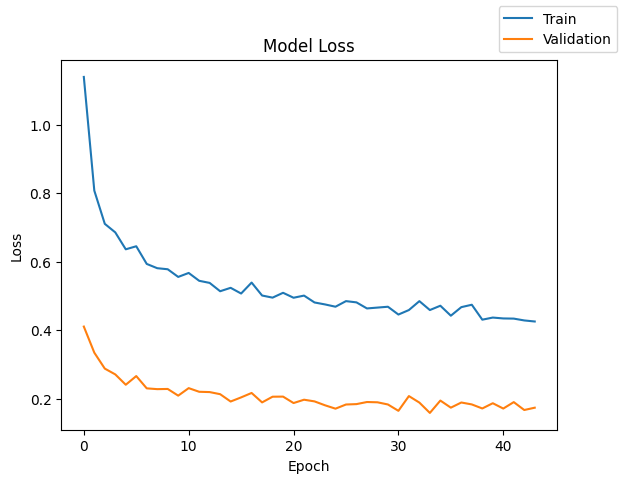

In [170]:
plot(history,'loss')

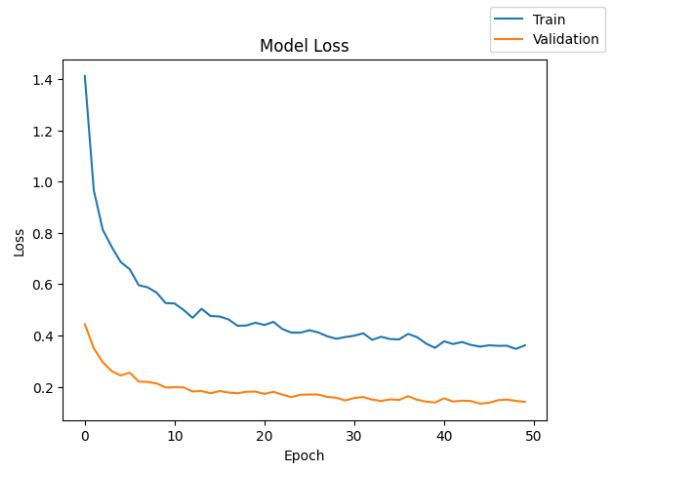

###### - Class Weights **{0:1 , 1:30}** :

In [171]:
m15_valid_perf = model_performance_classification(model, X_val, y_val)
m15_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Accuracy   Recall  Precision  F1 Score
0   0.98525  0.98525   0.986185  0.985591

In [44]:
m13_valid_perf

Accuracy  Recall  Precision  F1 Score
0     0.991   0.991      0.991     0.991

In [98]:
y_pred_probs = model.predict(X_val).flatten()
results15 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results15)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$290,700.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '19', 'False Positives': '33', 'True Positives': '203', 'True Negatives': '3,745', 'Total Savings': '$326,200.00', 'Total Costs': '$35,500.00'}


In [102]:
y_pred_probs = model.predict(X_val).flatten()
results15a = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.15)
print(results15a)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$-366,880.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '12', 'False Positives': '1,226', 'True Positives': '210', 'True Negatives': '2,552', 'Total Savings': '$258,120.00', 'Total Costs': '$625,000.00'}


In [109]:
y_pred_probs = model.predict(X_val).flatten()
results15b = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.85)
print(results15b)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$302,080.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '20', 'False Positives': '10', 'True Positives': '202', 'True Negatives': '3,768', 'Total Savings': '$327,080.00', 'Total Costs': '$25,000.00'}


In [176]:
from tensorflow.keras.models import save_model
save_model(model,'m15.keras')

In [103]:
print(results13)
print(results15)
print(results15a)
print(results15b)

{'Net Economic Impact': '$300,600.00', 'training_time_sec': 101.43746495246887, 'False Negatives': '18', 'False Positives': '18', 'True Positives': '204', 'True Negatives': '3,760', 'Total Savings': '$327,600.00', 'Total Costs': '$27,000.00'}
{'Net Economic Impact': '$290,700.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '19', 'False Positives': '33', 'True Positives': '203', 'True Negatives': '3,745', 'Total Savings': '$326,200.00', 'Total Costs': '$35,500.00'}
{'Net Economic Impact': '$-366,880.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '12', 'False Positives': '1,226', 'True Positives': '210', 'True Negatives': '2,552', 'Total Savings': '$258,120.00', 'Total Costs': '$625,000.00'}
{'Net Economic Impact': '$302,080.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '20', 'False Positives': '10', 'True Positives': '202', 'True Negatives': '3,768', 'Total Savings': '$327,080.00', 'Total Costs': '$25,000.00'}


 - Use model **15a** *ONLY IF*: **False Negatives are Extremely expensive**
  - Huge increase on False Positives (Unnecessary Repairs)

- Use model **15b** *ONLY IF*: **False Positives are Very expensive**
  - Highest False Negatives, but not a huge increase

##### - **m16**:

In [136]:
cw_dict = {
    0: 1.0,
    1: 60.0  # or try 25, 40, etc., depending on how sensitive you want the model
}
cw_dict

{0: 1.0, 1: 60.0}

In [137]:
epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [138]:
tf.keras.backend.clear_session()

In [139]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [140]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
optimizer = tf.keras.optimizers.Adam()  # Manipulating Learning Rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [142]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict, callbacks=[early_stop], verbose=1)
end=time.time()

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.1019 - val_loss: 0.6165
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3279 - val_loss: 0.5055
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0687 - val_loss: 0.4316
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0808 - val_loss: 0.4362
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9297 - val_loss: 0.3708
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9574 - val_loss: 0.3962
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9352 - val_loss: 0.3690
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8547 - val_loss: 0.3499
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8409 - val_loss: 0.3461
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8194 - val_loss: 0.3370
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8277 - val_loss: 0.3606
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [143]:
print("Time taken in seconds ",end-start)

Time taken in seconds  52.72643232345581


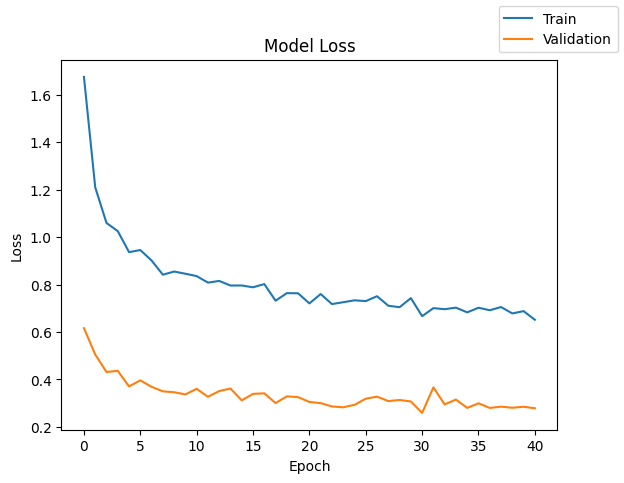

In [144]:
plot(history,'loss')

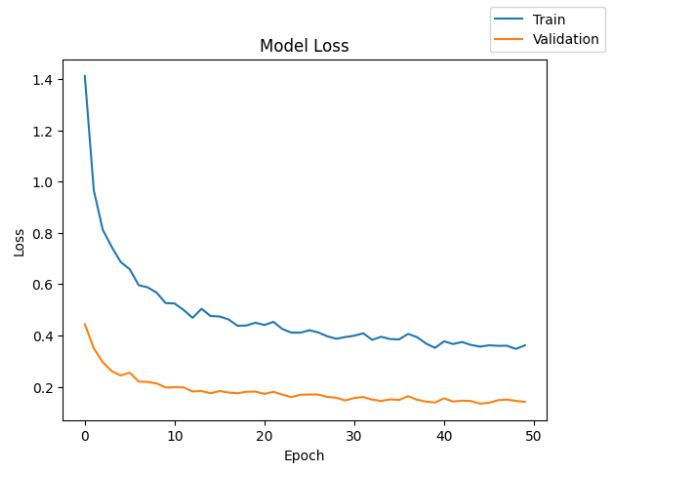

###### - Class Weights **{0:1 , 1:60}** :

In [145]:
m16_valid_perf = model_performance_classification(model, X_val, y_val)
m16_valid_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy   Recall  Precision  F1 Score
0   0.97625  0.97625    0.98022  0.977549

In [122]:
m15_valid_perf

Accuracy  Recall  Precision  F1 Score
0     0.987   0.987   0.987472  0.987187

In [85]:
m13_valid_perf

Accuracy  Recall  Precision  F1 Score
0     0.991   0.991      0.991     0.991

- As the weight increases for value=1, the F1 Score decreases

In [104]:
y_pred_probs = model.predict(X_val).flatten()
results16 = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.5)
print(results16)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$278,940.00', 'training_time_sec': 52.43073892593384, 'False Negatives': '19', 'False Positives': '54', 'True Positives': '203', 'True Negatives': '3,724', 'Total Savings': '$324,940.00', 'Total Costs': '$46,000.00'}


In [124]:
y_pred_probs = model.predict(X_val).flatten()
results16a = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.15)
print(results16a)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$-1,345,520.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '4', 'False Positives': '2,995', 'True Positives': '218', 'True Negatives': '783', 'Total Savings': '$155,980.00', 'Total Costs': '$1,501,500.00'}


In [125]:
y_pred_probs = model.predict(X_val).flatten()
results16b = compute_confusion_economics(y_val.values, y_pred_probs, threshold=0.85)
print(results16b)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$291,420.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '23', 'False Positives': '21', 'True Positives': '199', 'True Negatives': '3,757', 'Total Savings': '$324,920.00', 'Total Costs': '$33,500.00'}


In [126]:
print(results15)
print(results15a)
print(results15b)
print(results13)

{'Net Economic Impact': '$290,700.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '19', 'False Positives': '33', 'True Positives': '203', 'True Negatives': '3,745', 'Total Savings': '$326,200.00', 'Total Costs': '$35,500.00'}
{'Net Economic Impact': '$-366,880.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '12', 'False Positives': '1,226', 'True Positives': '210', 'True Negatives': '2,552', 'Total Savings': '$258,120.00', 'Total Costs': '$625,000.00'}
{'Net Economic Impact': '$302,080.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '20', 'False Positives': '10', 'True Positives': '202', 'True Negatives': '3,768', 'Total Savings': '$327,080.00', 'Total Costs': '$25,000.00'}
{'Net Economic Impact': '$300,600.00', 'training_time_sec': 101.43746495246887, 'False Negatives': '18', 'False Positives': '18', 'True Positives': '204', 'True Negatives': '3,760', 'Total Savings': '$327,600.00', 'Total Costs': '$27,000.00'}


In [127]:
print(results16)
print(results16a)
print(results16b)
print(results13)

{'Net Economic Impact': '$252,440.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '18', 'False Positives': '104', 'True Positives': '204', 'True Negatives': '3,674', 'Total Savings': '$322,440.00', 'Total Costs': '$70,000.00'}
{'Net Economic Impact': '$-1,345,520.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '4', 'False Positives': '2,995', 'True Positives': '218', 'True Negatives': '783', 'Total Savings': '$155,980.00', 'Total Costs': '$1,501,500.00'}
{'Net Economic Impact': '$291,420.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '23', 'False Positives': '21', 'True Positives': '199', 'True Negatives': '3,757', 'Total Savings': '$324,920.00', 'Total Costs': '$33,500.00'}
{'Net Economic Impact': '$300,600.00', 'training_time_sec': 101.43746495246887, 'False Negatives': '18', 'False Positives': '18', 'True Positives': '204', 'True Negatives': '3,760', 'Total Savings': '$327,600.00', 'Total Costs': '$27,000.00'}


In [148]:
from tensorflow.keras.models import save_model

save_model(model, "m16.keras")

- We have 3 Methods to proceed:
  - 1: Prioritize **False Negatives** with the assumption that replacing cost is extreme
    - (Ex: A repair would've cost 500, but to replace would've cost 200,000)
  - 2: Prioritize **F1 Score** for balance
    - Using proper evaluation metrics based on highest F1 Score
  - 3: Prioritize **Net Savings**
    - Using the assumed costs might be a high risk

# - **Choosing Final Model:**

In [128]:
models_valid_comp_df = pd.concat(
    [
        m15_valid_perf.T,
        m16_valid_perf.T,
        m13_valid_perf.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "m15",
    "m16",
    "m13"
]

In [130]:
models_valid_comp_df.T

Accuracy  Recall  Precision  F1 Score
m15    0.9870  0.9870   0.987472  0.987187
m16    0.9695  0.9695   0.976655  0.971799
m13    0.9910  0.9910   0.991000  0.991000

In [133]:
print(results16a)
print(results15a)

{'Net Economic Impact': '$-1,345,520.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '4', 'False Positives': '2,995', 'True Positives': '218', 'True Negatives': '783', 'Total Savings': '$155,980.00', 'Total Costs': '$1,501,500.00'}
{'Net Economic Impact': '$-366,880.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '12', 'False Positives': '1,226', 'True Positives': '210', 'True Negatives': '2,552', 'Total Savings': '$258,120.00', 'Total Costs': '$625,000.00'}


In [132]:
print(results15b)
print(results13)
print(results16b)


{'Net Economic Impact': '$302,080.00', 'training_time_sec': 69.55288624763489, 'False Negatives': '20', 'False Positives': '10', 'True Positives': '202', 'True Negatives': '3,768', 'Total Savings': '$327,080.00', 'Total Costs': '$25,000.00'}
{'Net Economic Impact': '$300,600.00', 'training_time_sec': 101.43746495246887, 'False Negatives': '18', 'False Positives': '18', 'True Positives': '204', 'True Negatives': '3,760', 'Total Savings': '$327,600.00', 'Total Costs': '$27,000.00'}
{'Net Economic Impact': '$291,420.00', 'training_time_sec': 28.817887783050537, 'False Negatives': '23', 'False Positives': '21', 'True Positives': '199', 'True Negatives': '3,757', 'Total Savings': '$324,920.00', 'Total Costs': '$33,500.00'}


- **Influence of Class Weights and Final Model Selection**:
  - **False Negatives** Score:
    - **(m16a)**
      - FN = 4, avoiding missing any potential repairs needed
        - m13 Architecture
          - 2 Hidden (128, 64) + Dropout + Adam
        - CW= {0:1 , 1:50}
        - Threshold = 0.15
  - **F1** Score:
    - **(m13)**
      - Perfect balance between False Positives and False Negatives with highest Recall and F1 scores
        - m13 Architecture
          - 2 Hidden (128, 64) + Dropout + Adam
        - CW= {0:1 , 1:18}
        - Threshold = 0.5
  - **Net Economic Value** Score:
    - **(m15b)**
      - Very little False Positives to avoid unnecessary repairs, somewhat high count of replacements but a lot of savings
        - m13 Architecture
          - 2 Hidden (128, 64) + Dropout + Adam
        - CW= {0:1 , 1:30}
        - Threshold = 0.85

# - **Checkpoint 7:**

## **Testing Final Model:**

### - Using **F1** Score prioritization (**m13**):

Now, let's check the performance of the final model on the test set.

In [149]:
dtest = pd.read_csv('/content/dtest1.csv')

In [150]:
X_test = dtest.drop(columns=["Target"])
y_test = dtest["Target"]

In [151]:
tf.keras.backend.clear_session()

In [152]:
from tensorflow.keras.models import load_model
model = load_model('/content/m13.keras')

In [82]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,140 (106.02 KB)

In [83]:
y_pred_probs = model.predict(X_test).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [84]:
f1_final = model_performance_classification(model, X_test, y_test)
f1_final

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Accuracy  Recall  Precision  F1 Score
0     0.989   0.989    0.98877  0.988819

In [86]:
y_pred_probs = model.predict(X_test).flatten()
f1_economic_final = compute_confusion_economics(y_test.values, y_pred_probs, threshold=0.5)
print(f1_economic_final)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
{'Net Economic Impact': '$358,500.00', 'training_time_sec': 48.752161741256714, 'False Negatives': '37', 'False Positives': '18', 'True Positives': '245', 'True Negatives': '4,700', 'Total Savings': '$404,500.00', 'Total Costs': '$46,000.00'}


### - Using **FN** Score prioritization (**m16a**):

  - "**a**" refers to Threshold= 0.15

In [153]:
dtest = pd.read_csv('/content/dtest1.csv')

In [154]:
X_test = dtest.drop(columns=["Target"])
y_test = dtest["Target"]

In [155]:
tf.keras.backend.clear_session()

In [156]:
from tensorflow.keras.models import load_model
model = load_model('/content/m16.keras')

In [157]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,140 (106.02 KB)

In [158]:
y_pred_probs = model.predict(X_test).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [159]:
f2_final = model_performance_classification(model, X_test, y_test)
f2_final

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9772  0.9772   0.979377  0.978004

In [160]:
y_pred_probs = model.predict(X_test).flatten()
f2_economic_final = compute_confusion_economics(y_test.values, y_pred_probs, threshold=0.15)
print(f2_economic_final)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'Net Economic Impact': '$-1,425,120.00', 'training_time_sec': 52.72643232345581, 'False Negatives': '12', 'False Positives': '3,270', 'True Positives': '270', 'True Negatives': '1,448', 'Total Savings': '$221,880.00', 'Total Costs': '$1,647,000.00'}


In [121]:
print(f1_economic_final)

{'Net Economic Impact': '$358,500.00', 'training_time_sec': 48.752161741256714, 'False Negatives': '37', 'False Positives': '18', 'True Positives': '245', 'True Negatives': '4,700', 'Total Savings': '$404,500.00', 'Total Costs': '$46,000.00'}


### - Using **FN** Score prioritization (**m15b**):

  - "**b**" refers to Threshold= 0.85

In [177]:
dtest = pd.read_csv('/content/dtest1.csv')

In [178]:
X_test = dtest.drop(columns=["Target"])
y_test = dtest["Target"]

In [179]:
tf.keras.backend.clear_session()

In [180]:
from tensorflow.keras.models import load_model
model = load_model('/content/m15.keras')

In [181]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,140 (106.02 KB)

In [182]:
y_pred_probs = model.predict(X_test).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [183]:
f3_final = model_performance_classification(model, X_test, y_test)
f3_final

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Accuracy  Recall  Precision  F1 Score
0    0.9832  0.9832   0.983714  0.983417

In [188]:
y_pred_probs = model.predict(X_test).flatten()
f3_economic_final = compute_confusion_economics(y_test.values, y_pred_probs, threshold=0.85)
print(f3_economic_final)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'Net Economic Impact': '$353,060.00', 'training_time_sec': 55.10142946243286, 'False Negatives': '41', 'False Positives': '17', 'True Positives': '241', 'True Negatives': '4,701', 'Total Savings': '$402,560.00', 'Total Costs': '$49,500.00'}


In [186]:
print(f1_economic_final)
print(f2_economic_final)

{'Net Economic Impact': '$358,500.00', 'training_time_sec': 48.752161741256714, 'False Negatives': '37', 'False Positives': '18', 'True Positives': '245', 'True Negatives': '4,700', 'Total Savings': '$404,500.00', 'Total Costs': '$46,000.00'}
{'Net Economic Impact': '$-1,425,120.00', 'training_time_sec': 52.72643232345581, 'False Negatives': '12', 'False Positives': '3,270', 'True Positives': '270', 'True Negatives': '1,448', 'Total Savings': '$221,880.00', 'Total Costs': '$1,647,000.00'}


# **Actionable Insights and Recommendations**

- **m13**:
  - Best results overall, with a very good balance between False Negatives and False Positives
    - Use if there is a comparable cost between repair ~ replace
-**m16**:
  - Use in case equipment is incredibly expensive:
    - **If**
      - Replacing costs = 200,000 - False Negatives
      - Unnecessary work = 100 - False Positives
        - **Then:**
          - (200,000)*12 + (100)*3270= **Mistake Cost m16**
            - (2,400,000 + 327,000)= 2,727,000
              - Vs.
          - (200,000)*48 + (100)*245= **Mistake Cost m13**
            - (9,600,000) + (24,500)= 9,624,500
-**m15**:
  - Use in case you would like to avoid false positives as much as possible
    - If False Positives cost > False Negatives cost